# Introduction to Neural Networks with TensorFlow and Keras Layers

## _Important_ if you let this run on Colab switch on the GPU option, because otherwise this part will take quite some time

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print(pd.__version__)

0.23.4


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.10.0


In [5]:
# let's see what compute devices we have available, hopefully a GPU 
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [6]:
# a small sane check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print(sess.run(hello))

b'Hello TF!'


## Loading and preparing our data set for classification

In [14]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 26800  100 26800    0     0   281k      0 --:--:-- --:--:-- --:--:--  281k


In [8]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')

In [9]:
df.head()

,speed,age,miles,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


In [10]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.952667,30.344000,0.998667
std,17.604333,17.191727,15.463152,0.816768
min,68.000000,9.000000,-21.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,102.000000,84.000000,2.000000


## First important concept: You train a machine with your data to make it learn the relationship between some input data and a certain label - this is called supervised learning

In [11]:
# we deliberately decide this is going to be our label, it is often called lower case y
y = df['group']

In [12]:
# since 'group' is now the label we want to predict, we need to remove it from the training data 
df.drop('group', axis='columns', inplace=True)

In [13]:
# input data often is named upper case X, the upper case indicates, that each row is a vector
X = df.as_matrix()

## Second important concept: To have an idea how well the training worked, we save some data to test our model on previously unseen data. 

* The real objective is to have a generalized model that works well on the test data.
* How well it performs on this test data as opposed to the training data tells us quite a bit as well.
* Typical splits are 60% for training and 40% for testing or 80/20
* It is important that we do not use the test data to tweak the hyper parameters of our learning strategy - in this case the test data would (indirectly) influence the training and can no longer tell how well we did
* evaluate the test date set only once at the end of your experiment

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# using stratify we get a balanced number of samples per category (important!)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [21]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [22]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2], dtype=int64), array([301, 300, 299], dtype=int64))

In [23]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2], dtype=int64), array([200, 200, 200], dtype=int64))

In [87]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#EEEE44'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25
title_font_size=40

def meshGrid(x_data, y_data):
    h = 1  # step size in the mesh
    x_min, x_max = x_data.min() - 1, x_data.max() + 1
    y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plot_prediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                          mesh=True, fixed=None, fname=None, print=False):
    xx,yy = meshGrid(x_data, y_data)
    fig, ax = plt.subplots(figsize=(20,10))

    if clf and mesh:
        grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
        if fixed:
            fill_values = np.full((len(grid_X), 1), fixed)
            grid_X = np.append(grid_X, fill_values, axis=1)
        Z = clf.predict(grid_X)
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    if print:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_bold, s=100, marker='o', edgecolors='k')
        
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    if fname:
        fig.savefig('figures/'+fname)
        
def plot_history(history, samples=100):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = history.params['epochs']
    every_sample =  int(epochs / samples)

    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]
    loss = pd.DataFrame(loss).iloc[::every_sample, :]
    val_loss = pd.DataFrame(val_loss).iloc[::every_sample, :]

    fig, ax = plt.subplots(nrows=2, figsize=(20,10))

    ax[0].plot(acc, 'bo', label='Training acc')
    ax[0].plot(val_acc, 'b', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()

    ax[1].plot(loss, 'bo', label='Training loss')
    ax[1].plot(val_loss, 'b', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()

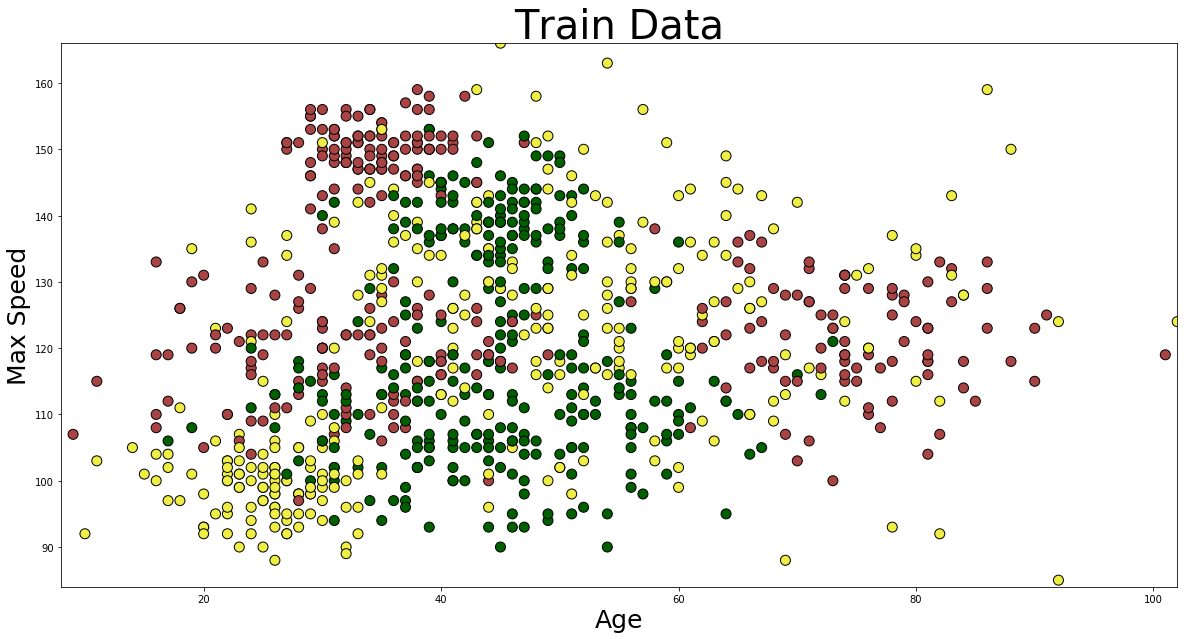

In [25]:
plot_prediction(None, X_train[:, 1], X_train[:, 0], 
               'Age', 'Max Speed', y_train, mesh=False,
                title="Train Data")

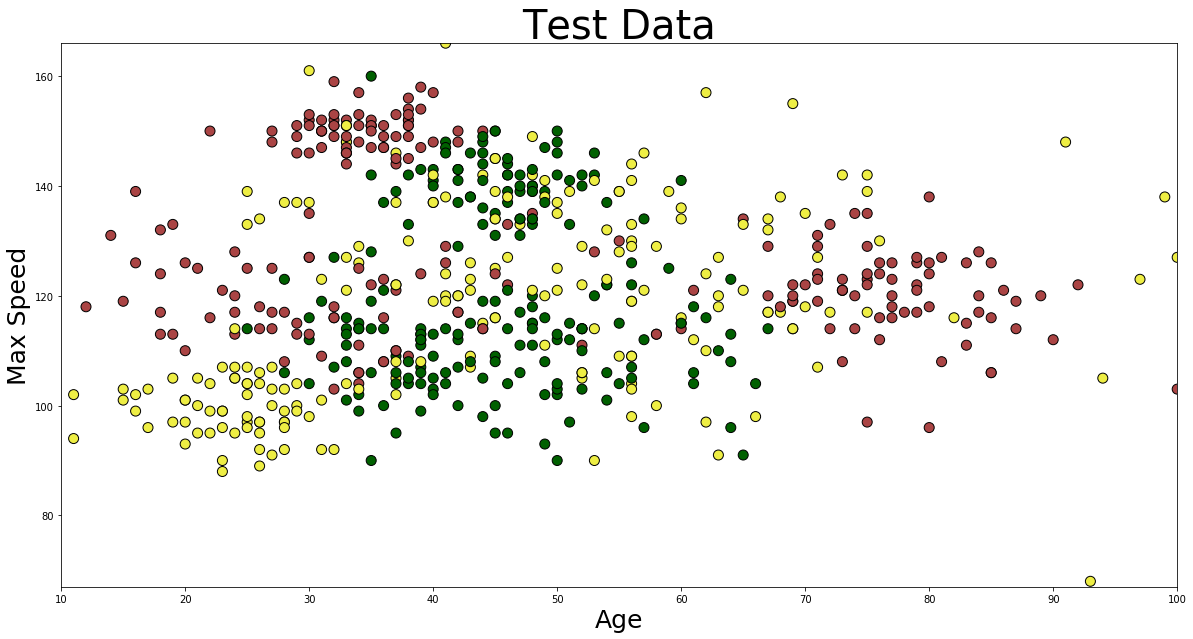

In [26]:
plot_prediction(None, X_test[:, 1], X_test[:, 0], 
               'Age', 'Max Speed', y_test, mesh=False,
                title="Test Data")

## Neural Networks using TensorFlow and Keras Layers
* Neural Networks consist of artificial neurons you organize in layers
* each neuron is very simple, but, theoretically, having enough of them in a single layer can approximate any funtion
* practically, we use 2 or 3 layers, as this has turned out to work well
* the more neurons and the more layers you use the longer the network takes to train
* neural networks often are no longer approachable using cross validation and grid search to find suitable hyper parameters

## Neuron (aka node or unit)

A neuron takes a number of numerical inputs, multiplies each with a weight, sums up all weighted input and adds bias (constant) to that sum. From this it creates a single numerical output. For one input (one dimension) this would be a description of a line. For more dimensions this describes a hyper plane that can serve as a decision boundary. Typically, this output is transformed using an activation function which compresses the output to a value between 0 and 1 (sigmoid), or between -1 and 1 (tanh) or sets all negative values to zero (relu).

It is not really important to understand the details of a neural network. Practically how you configure them to form something more powerful is much more important. This, however, is still a very experimental domain, so there really is no conscise explanation and understanding how they work.


### For now, we restrict the input to the two dimensions seen before to be able to plot decision boudaries

In [27]:
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

num_categories = 3

### We use a sequential mode, that means data flows without junctions from in to out

In [28]:
model = tf.keras.Sequential()

### We start with two layers each having 500 neurons, this should be more than enough capacity

In [29]:
model.add(tf.keras.layers.Dense(500, name='hidden1', activation='tanh', input_dim=2))
model.add(tf.keras.layers.Dense(500, name='hidden2', activation='tanh'))

### The final layer just transforms to likelyhood for each of our 3 classes

In [30]:
model.add(tf.keras.layers.Dense(num_categories, name='softmax', activation='softmax'))

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
softmax (Dense)              (None, 3)                 1503      
Total params: 253,503
Trainable params: 253,503
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [33]:
# only if you are running this locally

# https://keras.io/callbacks/#tensorboard
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./tf_log')
# To start tensorboard
# tensorboard --logdir=./tf_log
# open http://localhost:6006

In [34]:
BATCH_SIZE=1000
EPOCHS = 15000

# only if you are running this locally
# !rm -rf ./tf_log
# %time model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])

%time history = model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 720 samples, validate on 180 samples
Epoch 1/15000
720/720 [==============================] - 1s 1ms/step - loss: 1.3568 - acc: 0.3361 - val_loss: 2.5298 - val_acc: 0.3333
Epoch 2/15000
720/720 [==============================] - 0s 24us/step - loss: 2.5474 - acc: 0.3333 - val_loss: 3.2694 - val_acc: 0.3389
Epoch 3/15000
720/720 [==============================] - 0s 10us/step - loss: 3.2905 - acc: 0.3306 - val_loss: 1.6124 - val_acc: 0.3333
Epoch 4/15000
720/720 [==============================] - 0s 13us/step - loss: 1.6113 - acc: 0.3292 - val_loss: 1.4759 - val_acc: 0.4222
Epoch 5/15000
720/720 [==============================] - 0s 10us/step - loss: 1.4490 - acc: 0.4181 - val_loss: 2.2828 - val_acc: 0.3278
Epoch 6/15000
720/720 [==============================] - 0s 11us/step - loss: 2.2197 - acc: 0.3361 - val_loss: 2.0668 - val_acc: 0.3278
Epoch 7/15000
720/720 [==============================] - 0s 24us/step - loss: 1.9983 - acc: 0.3361 - val_loss: 1.3646 - val_acc: 0.4556
Epo

Epoch 61/15000
720/720 [==============================] - 0s 10us/step - loss: 0.8800 - acc: 0.6056 - val_loss: 0.9756 - val_acc: 0.5444
Epoch 62/15000
720/720 [==============================] - 0s 11us/step - loss: 0.8781 - acc: 0.6000 - val_loss: 0.9749 - val_acc: 0.5444
Epoch 63/15000
720/720 [==============================] - 0s 13us/step - loss: 0.8762 - acc: 0.5986 - val_loss: 0.9759 - val_acc: 0.5667
Epoch 64/15000
720/720 [==============================] - 0s 24us/step - loss: 0.8757 - acc: 0.5972 - val_loss: 0.9772 - val_acc: 0.5667
Epoch 65/15000
720/720 [==============================] - 0s 10us/step - loss: 0.8757 - acc: 0.5986 - val_loss: 0.9769 - val_acc: 0.5611
Epoch 66/15000
720/720 [==============================] - 0s 11us/step - loss: 0.8748 - acc: 0.6000 - val_loss: 0.9748 - val_acc: 0.5611
Epoch 67/15000
720/720 [==============================] - 0s 11us/step - loss: 0.8733 - acc: 0.6028 - val_loss: 0.9726 - val_acc: 0.5500
Epoch 68/15000
720/720 [=================

Epoch 121/15000
720/720 [==============================] - 0s 10us/step - loss: 0.8351 - acc: 0.6639 - val_loss: 0.9299 - val_acc: 0.6222
Epoch 122/15000
720/720 [==============================] - 0s 8us/step - loss: 0.8344 - acc: 0.6653 - val_loss: 0.9293 - val_acc: 0.6222
Epoch 123/15000
720/720 [==============================] - 0s 11us/step - loss: 0.8337 - acc: 0.6667 - val_loss: 0.9289 - val_acc: 0.6222
Epoch 124/15000
720/720 [==============================] - 0s 8us/step - loss: 0.8330 - acc: 0.6653 - val_loss: 0.9279 - val_acc: 0.6278
Epoch 125/15000
720/720 [==============================] - 0s 11us/step - loss: 0.8323 - acc: 0.6667 - val_loss: 0.9274 - val_acc: 0.6222
Epoch 126/15000
720/720 [==============================] - 0s 10us/step - loss: 0.8316 - acc: 0.6653 - val_loss: 0.9252 - val_acc: 0.6278
Epoch 127/15000
720/720 [==============================] - 0s 10us/step - loss: 0.8309 - acc: 0.6681 - val_loss: 0.9260 - val_acc: 0.6278
Epoch 128/15000
720/720 [===========

Epoch 181/15000
720/720 [==============================] - 0s 10us/step - loss: 0.8046 - acc: 0.6653 - val_loss: 0.8855 - val_acc: 0.6556
Epoch 182/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7987 - acc: 0.6722 - val_loss: 0.8903 - val_acc: 0.6167
Epoch 183/15000
720/720 [==============================] - 0s 11us/step - loss: 0.8017 - acc: 0.6722 - val_loss: 0.8892 - val_acc: 0.6278
Epoch 184/15000
720/720 [==============================] - 0s 21us/step - loss: 0.8066 - acc: 0.6611 - val_loss: 0.8935 - val_acc: 0.6000
Epoch 185/15000
720/720 [==============================] - 0s 11us/step - loss: 0.8043 - acc: 0.6639 - val_loss: 0.8828 - val_acc: 0.6444
Epoch 186/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7983 - acc: 0.6653 - val_loss: 0.8824 - val_acc: 0.6389
Epoch 187/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7973 - acc: 0.6681 - val_loss: 0.8891 - val_acc: 0.6111
Epoch 188/15000
720/720 [=========

Epoch 241/15000
720/720 [==============================] - 0s 19us/step - loss: 0.7819 - acc: 0.6653 - val_loss: 0.8652 - val_acc: 0.6278
Epoch 242/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7833 - acc: 0.6694 - val_loss: 0.8635 - val_acc: 0.6500
Epoch 243/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7840 - acc: 0.6583 - val_loss: 0.8656 - val_acc: 0.6333
Epoch 244/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7839 - acc: 0.6708 - val_loss: 0.8623 - val_acc: 0.6556
Epoch 245/15000
720/720 [==============================] - 0s 8us/step - loss: 0.7828 - acc: 0.6583 - val_loss: 0.8627 - val_acc: 0.6278
Epoch 246/15000
720/720 [==============================] - 0s 6us/step - loss: 0.7811 - acc: 0.6778 - val_loss: 0.8595 - val_acc: 0.6500
Epoch 247/15000
720/720 [==============================] - 0s 0us/step - loss: 0.7794 - acc: 0.6667 - val_loss: 0.8591 - val_acc: 0.6444
Epoch 248/15000
720/720 [============

Epoch 301/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7792 - acc: 0.6653 - val_loss: 0.8555 - val_acc: 0.6556
Epoch 302/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7746 - acc: 0.6611 - val_loss: 0.8500 - val_acc: 0.6333
Epoch 303/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7695 - acc: 0.6792 - val_loss: 0.8479 - val_acc: 0.6500
Epoch 304/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7667 - acc: 0.6778 - val_loss: 0.8484 - val_acc: 0.6500
Epoch 305/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7671 - acc: 0.6764 - val_loss: 0.8497 - val_acc: 0.6278
Epoch 306/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7695 - acc: 0.6764 - val_loss: 0.8527 - val_acc: 0.6556
Epoch 307/15000
720/720 [==============================] - 0s 21us/step - loss: 0.7717 - acc: 0.6667 - val_loss: 0.8515 - val_acc: 0.6222
Epoch 308/15000
720/720 [=========

Epoch 361/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7623 - acc: 0.6764 - val_loss: 0.8446 - val_acc: 0.6500
Epoch 362/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7620 - acc: 0.6694 - val_loss: 0.8418 - val_acc: 0.6333
Epoch 363/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7616 - acc: 0.6764 - val_loss: 0.8438 - val_acc: 0.6556
Epoch 364/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7612 - acc: 0.6722 - val_loss: 0.8408 - val_acc: 0.6333
Epoch 365/15000
720/720 [==============================] - 0s 21us/step - loss: 0.7607 - acc: 0.6778 - val_loss: 0.8427 - val_acc: 0.6556
Epoch 366/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7603 - acc: 0.6764 - val_loss: 0.8403 - val_acc: 0.6333
Epoch 367/15000
720/720 [==============================] - 0s 8us/step - loss: 0.7599 - acc: 0.6792 - val_loss: 0.8422 - val_acc: 0.6556
Epoch 368/15000
720/720 [==========

Epoch 421/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7525 - acc: 0.6819 - val_loss: 0.8360 - val_acc: 0.6556
Epoch 422/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7523 - acc: 0.6819 - val_loss: 0.8346 - val_acc: 0.6556
Epoch 423/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7522 - acc: 0.6833 - val_loss: 0.8360 - val_acc: 0.6556
Epoch 424/15000
720/720 [==============================] - 0s 22us/step - loss: 0.7522 - acc: 0.6819 - val_loss: 0.8349 - val_acc: 0.6444
Epoch 425/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7522 - acc: 0.6833 - val_loss: 0.8368 - val_acc: 0.6556
Epoch 426/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7523 - acc: 0.6778 - val_loss: 0.8349 - val_acc: 0.6444
Epoch 427/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7525 - acc: 0.6833 - val_loss: 0.8378 - val_acc: 0.6556
Epoch 428/15000
720/720 [=========

Epoch 481/15000
720/720 [==============================] - 0s 8us/step - loss: 0.7466 - acc: 0.6833 - val_loss: 0.8317 - val_acc: 0.6444
Epoch 482/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7466 - acc: 0.6792 - val_loss: 0.8332 - val_acc: 0.6556
Epoch 483/15000
720/720 [==============================] - 0s 8us/step - loss: 0.7465 - acc: 0.6861 - val_loss: 0.8315 - val_acc: 0.6444
Epoch 484/15000
720/720 [==============================] - 0s 12us/step - loss: 0.7463 - acc: 0.6806 - val_loss: 0.8326 - val_acc: 0.6556
Epoch 485/15000
720/720 [==============================] - 0s 22us/step - loss: 0.7462 - acc: 0.6833 - val_loss: 0.8314 - val_acc: 0.6444
Epoch 486/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7460 - acc: 0.6819 - val_loss: 0.8322 - val_acc: 0.6556
Epoch 487/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7458 - acc: 0.6819 - val_loss: 0.8318 - val_acc: 0.6556
Epoch 488/15000
720/720 [===========

Epoch 541/15000
720/720 [==============================] - 0s 8us/step - loss: 0.7413 - acc: 0.6833 - val_loss: 0.8315 - val_acc: 0.6500
Epoch 542/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7414 - acc: 0.6847 - val_loss: 0.8290 - val_acc: 0.6389
Epoch 543/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7413 - acc: 0.6833 - val_loss: 0.8309 - val_acc: 0.6500
Epoch 544/15000
720/720 [==============================] - 0s 8us/step - loss: 0.7411 - acc: 0.6875 - val_loss: 0.8288 - val_acc: 0.6444
Epoch 545/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7407 - acc: 0.6861 - val_loss: 0.8297 - val_acc: 0.6500
Epoch 546/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7405 - acc: 0.6833 - val_loss: 0.8293 - val_acc: 0.6500
Epoch 547/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7403 - acc: 0.6847 - val_loss: 0.8290 - val_acc: 0.6500
Epoch 548/15000
720/720 [===========

Epoch 601/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7364 - acc: 0.6847 - val_loss: 0.8258 - val_acc: 0.6500
Epoch 602/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7355 - acc: 0.6875 - val_loss: 0.8278 - val_acc: 0.6500
Epoch 603/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7360 - acc: 0.6903 - val_loss: 0.8260 - val_acc: 0.6333
Epoch 604/15000
720/720 [==============================] - 0s 21us/step - loss: 0.7367 - acc: 0.6847 - val_loss: 0.8303 - val_acc: 0.6500
Epoch 605/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7366 - acc: 0.6889 - val_loss: 0.8264 - val_acc: 0.6500
Epoch 606/15000
720/720 [==============================] - 0s 8us/step - loss: 0.7357 - acc: 0.6889 - val_loss: 0.8267 - val_acc: 0.6500
Epoch 607/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7351 - acc: 0.6875 - val_loss: 0.8268 - val_acc: 0.6500
Epoch 608/15000
720/720 [==========

Epoch 661/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7425 - acc: 0.6708 - val_loss: 0.8370 - val_acc: 0.6444
Epoch 662/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7364 - acc: 0.6917 - val_loss: 0.8266 - val_acc: 0.6500
Epoch 663/15000
720/720 [==============================] - 0s 8us/step - loss: 0.7308 - acc: 0.6958 - val_loss: 0.8261 - val_acc: 0.6389
Epoch 664/15000
720/720 [==============================] - 0s 8us/step - loss: 0.7320 - acc: 0.6889 - val_loss: 0.8375 - val_acc: 0.6444
Epoch 665/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7362 - acc: 0.6903 - val_loss: 0.8292 - val_acc: 0.6389
Epoch 666/15000
720/720 [==============================] - 0s 8us/step - loss: 0.7367 - acc: 0.6847 - val_loss: 0.8312 - val_acc: 0.6500
Epoch 667/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7320 - acc: 0.6889 - val_loss: 0.8267 - val_acc: 0.6500
Epoch 668/15000
720/720 [============

Epoch 721/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7254 - acc: 0.6931 - val_loss: 0.8206 - val_acc: 0.6500
Epoch 722/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7254 - acc: 0.6944 - val_loss: 0.8239 - val_acc: 0.6500
Epoch 723/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7256 - acc: 0.6903 - val_loss: 0.8205 - val_acc: 0.6444
Epoch 724/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7259 - acc: 0.6958 - val_loss: 0.8257 - val_acc: 0.6500
Epoch 725/15000
720/720 [==============================] - 0s 8us/step - loss: 0.7265 - acc: 0.6931 - val_loss: 0.8210 - val_acc: 0.6333
Epoch 726/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7275 - acc: 0.6875 - val_loss: 0.8295 - val_acc: 0.6444
Epoch 727/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7289 - acc: 0.6903 - val_loss: 0.8232 - val_acc: 0.6389
Epoch 728/15000
720/720 [==========

Epoch 781/15000
720/720 [==============================] - 0s 8us/step - loss: 0.7202 - acc: 0.6972 - val_loss: 0.8211 - val_acc: 0.6500
Epoch 782/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7203 - acc: 0.6917 - val_loss: 0.8178 - val_acc: 0.6500
Epoch 783/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7205 - acc: 0.6972 - val_loss: 0.8221 - val_acc: 0.6500
Epoch 784/15000
720/720 [==============================] - 0s 24us/step - loss: 0.7207 - acc: 0.6903 - val_loss: 0.8178 - val_acc: 0.6389
Epoch 785/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7214 - acc: 0.6944 - val_loss: 0.8247 - val_acc: 0.6444
Epoch 786/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7222 - acc: 0.6917 - val_loss: 0.8187 - val_acc: 0.6500
Epoch 787/15000
720/720 [==============================] - 0s 8us/step - loss: 0.7240 - acc: 0.6903 - val_loss: 0.8303 - val_acc: 0.6444
Epoch 788/15000
720/720 [===========

Epoch 841/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7156 - acc: 0.6972 - val_loss: 0.8190 - val_acc: 0.6500
Epoch 842/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7158 - acc: 0.6875 - val_loss: 0.8142 - val_acc: 0.6389
Epoch 843/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7162 - acc: 0.6958 - val_loss: 0.8209 - val_acc: 0.6444
Epoch 844/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7167 - acc: 0.6917 - val_loss: 0.8147 - val_acc: 0.6444
Epoch 845/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7176 - acc: 0.6944 - val_loss: 0.8240 - val_acc: 0.6444
Epoch 846/15000
720/720 [==============================] - 0s 24us/step - loss: 0.7187 - acc: 0.6917 - val_loss: 0.8159 - val_acc: 0.6556
Epoch 847/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7205 - acc: 0.6917 - val_loss: 0.8287 - val_acc: 0.6444
Epoch 848/15000
720/720 [=========

Epoch 901/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7267 - acc: 0.6778 - val_loss: 0.8400 - val_acc: 0.6333
Epoch 902/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7282 - acc: 0.6750 - val_loss: 0.8211 - val_acc: 0.6611
Epoch 903/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7283 - acc: 0.6764 - val_loss: 0.8336 - val_acc: 0.6444
Epoch 904/15000
720/720 [==============================] - 0s 13us/step - loss: 0.7212 - acc: 0.6819 - val_loss: 0.8140 - val_acc: 0.6444
Epoch 905/15000
720/720 [==============================] - 0s 24us/step - loss: 0.7139 - acc: 0.6889 - val_loss: 0.8172 - val_acc: 0.6556
Epoch 906/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7103 - acc: 0.7000 - val_loss: 0.8187 - val_acc: 0.6389
Epoch 907/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7118 - acc: 0.6889 - val_loss: 0.8152 - val_acc: 0.6500
Epoch 908/15000
720/720 [=========

Epoch 961/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7091 - acc: 0.6833 - val_loss: 0.8152 - val_acc: 0.6667
Epoch 962/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7114 - acc: 0.7028 - val_loss: 0.8141 - val_acc: 0.6278
Epoch 963/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7128 - acc: 0.6861 - val_loss: 0.8199 - val_acc: 0.6667
Epoch 964/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7142 - acc: 0.7056 - val_loss: 0.8123 - val_acc: 0.6389
Epoch 965/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7124 - acc: 0.6861 - val_loss: 0.8203 - val_acc: 0.6611
Epoch 966/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7112 - acc: 0.7042 - val_loss: 0.8081 - val_acc: 0.6333
Epoch 967/15000
720/720 [==============================] - 0s 12us/step - loss: 0.7100 - acc: 0.6889 - val_loss: 0.8245 - val_acc: 0.6444
Epoch 968/15000
720/720 [=========

Epoch 1021/15000
720/720 [==============================] - 0s 3us/step - loss: 0.7003 - acc: 0.6944 - val_loss: 0.8054 - val_acc: 0.6556
Epoch 1022/15000
720/720 [==============================] - 0s 0us/step - loss: 0.7002 - acc: 0.6958 - val_loss: 0.8046 - val_acc: 0.6444
Epoch 1023/15000
720/720 [==============================] - 0s 0us/step - loss: 0.7002 - acc: 0.6931 - val_loss: 0.8063 - val_acc: 0.6556
Epoch 1024/15000
720/720 [==============================] - 0s 20us/step - loss: 0.7002 - acc: 0.6972 - val_loss: 0.8037 - val_acc: 0.6389
Epoch 1025/15000
720/720 [==============================] - 0s 13us/step - loss: 0.7001 - acc: 0.6931 - val_loss: 0.8056 - val_acc: 0.6556
Epoch 1026/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7000 - acc: 0.6958 - val_loss: 0.8038 - val_acc: 0.6444
Epoch 1027/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6999 - acc: 0.6931 - val_loss: 0.8060 - val_acc: 0.6500
Epoch 1028/15000
720/720 [====

Epoch 1081/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6959 - acc: 0.6903 - val_loss: 0.8028 - val_acc: 0.6556
Epoch 1082/15000
720/720 [==============================] - 0s 12us/step - loss: 0.6960 - acc: 0.7042 - val_loss: 0.8016 - val_acc: 0.6389
Epoch 1083/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6963 - acc: 0.6944 - val_loss: 0.8042 - val_acc: 0.6611
Epoch 1084/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6968 - acc: 0.7028 - val_loss: 0.8022 - val_acc: 0.6333
Epoch 1085/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6975 - acc: 0.6958 - val_loss: 0.8061 - val_acc: 0.6611
Epoch 1086/15000
720/720 [==============================] - 0s 12us/step - loss: 0.6987 - acc: 0.7069 - val_loss: 0.8047 - val_acc: 0.6278
Epoch 1087/15000
720/720 [==============================] - 0s 12us/step - loss: 0.7000 - acc: 0.6931 - val_loss: 0.8090 - val_acc: 0.6667
Epoch 1088/15000
720/720 [=

Epoch 1140/15000
720/720 [==============================] - 0s 13us/step - loss: 0.6915 - acc: 0.6944 - val_loss: 0.8026 - val_acc: 0.6611
Epoch 1141/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6925 - acc: 0.7042 - val_loss: 0.7968 - val_acc: 0.6444
Epoch 1142/15000
720/720 [==============================] - 0s 12us/step - loss: 0.6933 - acc: 0.7000 - val_loss: 0.8032 - val_acc: 0.6611
Epoch 1143/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6928 - acc: 0.7000 - val_loss: 0.7961 - val_acc: 0.6389
Epoch 1144/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6914 - acc: 0.7014 - val_loss: 0.7975 - val_acc: 0.6500
Epoch 1145/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6908 - acc: 0.6986 - val_loss: 0.8008 - val_acc: 0.6556
Epoch 1146/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6913 - acc: 0.7000 - val_loss: 0.7979 - val_acc: 0.6444
Epoch 1147/15000
720/720 [=

Epoch 1199/15000
720/720 [==============================] - 0s 22us/step - loss: 0.6886 - acc: 0.7042 - val_loss: 0.7989 - val_acc: 0.6611
Epoch 1200/15000
720/720 [==============================] - 0s 12us/step - loss: 0.6885 - acc: 0.7069 - val_loss: 0.7946 - val_acc: 0.6444
Epoch 1201/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6878 - acc: 0.7056 - val_loss: 0.7981 - val_acc: 0.6611
Epoch 1202/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6874 - acc: 0.7014 - val_loss: 0.7928 - val_acc: 0.6500
Epoch 1203/15000
720/720 [==============================] - 0s 12us/step - loss: 0.6872 - acc: 0.7069 - val_loss: 0.7988 - val_acc: 0.6556
Epoch 1204/15000
720/720 [==============================] - 0s 18us/step - loss: 0.6875 - acc: 0.6972 - val_loss: 0.7932 - val_acc: 0.6500
Epoch 1205/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6882 - acc: 0.7097 - val_loss: 0.8016 - val_acc: 0.6500
Epoch 1206/15000
720/720 [=

Epoch 1258/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6837 - acc: 0.6917 - val_loss: 0.7949 - val_acc: 0.6611
Epoch 1259/15000
720/720 [==============================] - 0s 12us/step - loss: 0.6837 - acc: 0.7111 - val_loss: 0.7937 - val_acc: 0.6444
Epoch 1260/15000
720/720 [==============================] - 0s 8us/step - loss: 0.6840 - acc: 0.7083 - val_loss: 0.7979 - val_acc: 0.6611
Epoch 1261/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6846 - acc: 0.7083 - val_loss: 0.7933 - val_acc: 0.6444
Epoch 1262/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6850 - acc: 0.7056 - val_loss: 0.8002 - val_acc: 0.6611
Epoch 1263/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6858 - acc: 0.7097 - val_loss: 0.7932 - val_acc: 0.6444
Epoch 1264/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6857 - acc: 0.7069 - val_loss: 0.8003 - val_acc: 0.6611
Epoch 1265/15000
720/720 [==

720/720 [==============================] - 0s 10us/step - loss: 0.6842 - acc: 0.6958 - val_loss: 0.7951 - val_acc: 0.6556
Epoch 1318/15000
720/720 [==============================] - 0s 13us/step - loss: 0.6879 - acc: 0.7111 - val_loss: 0.8062 - val_acc: 0.6389
Epoch 1319/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6889 - acc: 0.6889 - val_loss: 0.7966 - val_acc: 0.6611
Epoch 1320/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6898 - acc: 0.7111 - val_loss: 0.8041 - val_acc: 0.6389
Epoch 1321/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6859 - acc: 0.6931 - val_loss: 0.7915 - val_acc: 0.6667
Epoch 1322/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6823 - acc: 0.7167 - val_loss: 0.7961 - val_acc: 0.6667
Epoch 1323/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6789 - acc: 0.6986 - val_loss: 0.7895 - val_acc: 0.6556
Epoch 1324/15000
720/720 [==================

Epoch 1377/15000
720/720 [==============================] - 0s 0us/step - loss: 0.6737 - acc: 0.7042 - val_loss: 0.7893 - val_acc: 0.6722
Epoch 1378/15000
720/720 [==============================] - 0s 22us/step - loss: 0.6733 - acc: 0.7042 - val_loss: 0.7883 - val_acc: 0.6611
Epoch 1379/15000
720/720 [==============================] - 0s 16us/step - loss: 0.6730 - acc: 0.7097 - val_loss: 0.7890 - val_acc: 0.6611
Epoch 1380/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6729 - acc: 0.7083 - val_loss: 0.7882 - val_acc: 0.6667
Epoch 1381/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6728 - acc: 0.7083 - val_loss: 0.7893 - val_acc: 0.6667
Epoch 1382/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6729 - acc: 0.7083 - val_loss: 0.7886 - val_acc: 0.6722
Epoch 1383/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6731 - acc: 0.7069 - val_loss: 0.7902 - val_acc: 0.6611
Epoch 1384/15000
720/720 [==

Epoch 1437/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6697 - acc: 0.7139 - val_loss: 0.7966 - val_acc: 0.6722
Epoch 1438/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6716 - acc: 0.7097 - val_loss: 0.7858 - val_acc: 0.6611
Epoch 1439/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6727 - acc: 0.7194 - val_loss: 0.7987 - val_acc: 0.6667
Epoch 1440/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6729 - acc: 0.7097 - val_loss: 0.7853 - val_acc: 0.6611
Epoch 1441/15000
720/720 [==============================] - 0s 13us/step - loss: 0.6715 - acc: 0.7153 - val_loss: 0.7940 - val_acc: 0.6667
Epoch 1442/15000
720/720 [==============================] - 0s 12us/step - loss: 0.6697 - acc: 0.7042 - val_loss: 0.7876 - val_acc: 0.6722
Epoch 1443/15000
720/720 [==============================] - 0s 25us/step - loss: 0.6690 - acc: 0.7222 - val_loss: 0.7897 - val_acc: 0.6556
Epoch 1444/15000
720/720 [=

Epoch 1496/15000
720/720 [==============================] - 0s 6us/step - loss: 0.6641 - acc: 0.7208 - val_loss: 0.7895 - val_acc: 0.6778
Epoch 1497/15000
720/720 [==============================] - 0s 0us/step - loss: 0.6637 - acc: 0.7083 - val_loss: 0.7846 - val_acc: 0.6722
Epoch 1498/15000
720/720 [==============================] - 0s 22us/step - loss: 0.6635 - acc: 0.7208 - val_loss: 0.7882 - val_acc: 0.6778
Epoch 1499/15000
720/720 [==============================] - 0s 0us/step - loss: 0.6633 - acc: 0.7167 - val_loss: 0.7850 - val_acc: 0.6722
Epoch 1500/15000
720/720 [==============================] - 0s 22us/step - loss: 0.6632 - acc: 0.7194 - val_loss: 0.7875 - val_acc: 0.6722
Epoch 1501/15000
720/720 [==============================] - 0s 17us/step - loss: 0.6631 - acc: 0.7167 - val_loss: 0.7855 - val_acc: 0.6722
Epoch 1502/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6631 - acc: 0.7181 - val_loss: 0.7874 - val_acc: 0.6667
Epoch 1503/15000
720/720 [====

Epoch 1555/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6591 - acc: 0.7208 - val_loss: 0.7853 - val_acc: 0.6611
Epoch 1556/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6590 - acc: 0.7222 - val_loss: 0.7917 - val_acc: 0.6778
Epoch 1557/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6603 - acc: 0.7125 - val_loss: 0.7823 - val_acc: 0.6611
Epoch 1558/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6611 - acc: 0.7222 - val_loss: 0.7944 - val_acc: 0.6778
Epoch 1559/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6615 - acc: 0.7153 - val_loss: 0.7819 - val_acc: 0.6667
Epoch 1560/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6607 - acc: 0.7250 - val_loss: 0.7919 - val_acc: 0.6778
Epoch 1561/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6597 - acc: 0.7153 - val_loss: 0.7838 - val_acc: 0.6667
Epoch 1562/15000
720/720 [=

Epoch 1614/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6555 - acc: 0.7167 - val_loss: 0.7892 - val_acc: 0.6667
Epoch 1615/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6549 - acc: 0.7208 - val_loss: 0.7813 - val_acc: 0.6611
Epoch 1616/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6546 - acc: 0.7181 - val_loss: 0.7885 - val_acc: 0.6778
Epoch 1617/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6539 - acc: 0.7250 - val_loss: 0.7806 - val_acc: 0.6611
Epoch 1618/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6535 - acc: 0.7208 - val_loss: 0.7875 - val_acc: 0.6778
Epoch 1619/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6531 - acc: 0.7236 - val_loss: 0.7807 - val_acc: 0.6611
Epoch 1620/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6528 - acc: 0.7236 - val_loss: 0.7864 - val_acc: 0.6778
Epoch 1621/15000
720/720 [=

Epoch 1674/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6483 - acc: 0.7125 - val_loss: 0.7820 - val_acc: 0.6722
Epoch 1675/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6481 - acc: 0.7306 - val_loss: 0.7845 - val_acc: 0.6611
Epoch 1676/15000
720/720 [==============================] - 0s 12us/step - loss: 0.6481 - acc: 0.7167 - val_loss: 0.7839 - val_acc: 0.6722
Epoch 1677/15000
720/720 [==============================] - 0s 17us/step - loss: 0.6483 - acc: 0.7264 - val_loss: 0.7819 - val_acc: 0.6667
Epoch 1678/15000
720/720 [==============================] - 0s 18us/step - loss: 0.6492 - acc: 0.7250 - val_loss: 0.7883 - val_acc: 0.6722
Epoch 1679/15000
720/720 [==============================] - 0s 35us/step - loss: 0.6506 - acc: 0.7236 - val_loss: 0.7821 - val_acc: 0.6611
Epoch 1680/15000
720/720 [==============================] - 0s 15us/step - loss: 0.6543 - acc: 0.7250 - val_loss: 0.7968 - val_acc: 0.6722
Epoch 1681/15000
720/720 [=

Epoch 1733/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6419 - acc: 0.7306 - val_loss: 0.7812 - val_acc: 0.6722
Epoch 1734/15000
720/720 [==============================] - 0s 12us/step - loss: 0.6419 - acc: 0.7194 - val_loss: 0.7814 - val_acc: 0.6833
Epoch 1735/15000
720/720 [==============================] - 0s 14us/step - loss: 0.6418 - acc: 0.7319 - val_loss: 0.7804 - val_acc: 0.6722
Epoch 1736/15000
720/720 [==============================] - 0s 26us/step - loss: 0.6418 - acc: 0.7208 - val_loss: 0.7820 - val_acc: 0.6833
Epoch 1737/15000
720/720 [==============================] - 0s 14us/step - loss: 0.6418 - acc: 0.7319 - val_loss: 0.7790 - val_acc: 0.6722
Epoch 1738/15000
720/720 [==============================] - 0s 14us/step - loss: 0.6419 - acc: 0.7278 - val_loss: 0.7836 - val_acc: 0.6833
Epoch 1739/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6422 - acc: 0.7264 - val_loss: 0.7782 - val_acc: 0.6722
Epoch 1740/15000
720/720 [=

Epoch 1792/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6453 - acc: 0.7222 - val_loss: 0.7864 - val_acc: 0.6611
Epoch 1793/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6536 - acc: 0.7208 - val_loss: 0.8029 - val_acc: 0.6556
Epoch 1794/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6577 - acc: 0.7194 - val_loss: 0.7993 - val_acc: 0.6556
Epoch 1795/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6668 - acc: 0.7111 - val_loss: 0.8034 - val_acc: 0.6500
Epoch 1796/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6576 - acc: 0.7167 - val_loss: 0.7933 - val_acc: 0.6667
Epoch 1797/15000
720/720 [==============================] - 0s 26us/step - loss: 0.6493 - acc: 0.7125 - val_loss: 0.7817 - val_acc: 0.6722
Epoch 1798/15000
720/720 [==============================] - 0s 12us/step - loss: 0.6399 - acc: 0.7375 - val_loss: 0.7851 - val_acc: 0.6889
Epoch 1799/15000
720/720 [=

720/720 [==============================] - 0s 24us/step - loss: 0.6332 - acc: 0.7250 - val_loss: 0.7749 - val_acc: 0.6778
Epoch 1852/15000
720/720 [==============================] - 0s 0us/step - loss: 0.6338 - acc: 0.7319 - val_loss: 0.7860 - val_acc: 0.6722
Epoch 1853/15000
720/720 [==============================] - 0s 22us/step - loss: 0.6342 - acc: 0.7236 - val_loss: 0.7752 - val_acc: 0.6778
Epoch 1854/15000
720/720 [==============================] - 0s 0us/step - loss: 0.6350 - acc: 0.7347 - val_loss: 0.7879 - val_acc: 0.6778
Epoch 1855/15000
720/720 [==============================] - 0s 31us/step - loss: 0.6354 - acc: 0.7264 - val_loss: 0.7761 - val_acc: 0.6778
Epoch 1856/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6367 - acc: 0.7375 - val_loss: 0.7894 - val_acc: 0.6722
Epoch 1857/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6367 - acc: 0.7236 - val_loss: 0.7767 - val_acc: 0.6778
Epoch 1858/15000
720/720 [====================

Epoch 1911/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6313 - acc: 0.7375 - val_loss: 0.7877 - val_acc: 0.6667
Epoch 1912/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6323 - acc: 0.7264 - val_loss: 0.7773 - val_acc: 0.6778
Epoch 1913/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6345 - acc: 0.7333 - val_loss: 0.7906 - val_acc: 0.6722
Epoch 1914/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6344 - acc: 0.7222 - val_loss: 0.7778 - val_acc: 0.6778
Epoch 1915/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6355 - acc: 0.7306 - val_loss: 0.7896 - val_acc: 0.6667
Epoch 1916/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6332 - acc: 0.7236 - val_loss: 0.7765 - val_acc: 0.6778
Epoch 1917/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6318 - acc: 0.7389 - val_loss: 0.7844 - val_acc: 0.6722
Epoch 1918/15000
720/720 [=

Epoch 1970/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6237 - acc: 0.7333 - val_loss: 0.7762 - val_acc: 0.6778
Epoch 1971/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6214 - acc: 0.7347 - val_loss: 0.7829 - val_acc: 0.6667
Epoch 1972/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6227 - acc: 0.7306 - val_loss: 0.7747 - val_acc: 0.6778
Epoch 1973/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6241 - acc: 0.7375 - val_loss: 0.7837 - val_acc: 0.6722
Epoch 1974/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6232 - acc: 0.7292 - val_loss: 0.7747 - val_acc: 0.6833
Epoch 1975/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6212 - acc: 0.7361 - val_loss: 0.7783 - val_acc: 0.6611
Epoch 1976/15000
720/720 [==============================] - 0s 10us/step - loss: 0.6218 - acc: 0.7319 - val_loss: 0.7808 - val_acc: 0.6722
Epoch 1977/15000
720/720 [=

Epoch 2030/15000
720/720 [==============================] - 0s 22us/step - loss: 0.6161 - acc: 0.7333 - val_loss: 0.7788 - val_acc: 0.6722
Epoch 2031/15000
720/720 [==============================] - 0s 0us/step - loss: 0.6162 - acc: 0.7361 - val_loss: 0.7751 - val_acc: 0.6778
Epoch 2032/15000
720/720 [==============================] - 0s 22us/step - loss: 0.6164 - acc: 0.7375 - val_loss: 0.7800 - val_acc: 0.6611
Epoch 2033/15000
720/720 [==============================] - 0s 0us/step - loss: 0.6168 - acc: 0.7292 - val_loss: 0.7748 - val_acc: 0.6889
Epoch 2034/15000
720/720 [==============================] - 0s 22us/step - loss: 0.6174 - acc: 0.7347 - val_loss: 0.7818 - val_acc: 0.6611
Epoch 2035/15000
720/720 [==============================] - 0s 21us/step - loss: 0.6181 - acc: 0.7292 - val_loss: 0.7749 - val_acc: 0.6889
Epoch 2036/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6193 - acc: 0.7389 - val_loss: 0.7853 - val_acc: 0.6667
Epoch 2037/15000
720/720 [===

Epoch 2090/15000
720/720 [==============================] - 0s 12us/step - loss: 0.6133 - acc: 0.7264 - val_loss: 0.7750 - val_acc: 0.6833
Epoch 2091/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6145 - acc: 0.7389 - val_loss: 0.7851 - val_acc: 0.6611
Epoch 2092/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6158 - acc: 0.7292 - val_loss: 0.7759 - val_acc: 0.6889
Epoch 2093/15000
720/720 [==============================] - 0s 13us/step - loss: 0.6180 - acc: 0.7375 - val_loss: 0.7898 - val_acc: 0.6611
Epoch 2094/15000
720/720 [==============================] - 0s 12us/step - loss: 0.6194 - acc: 0.7292 - val_loss: 0.7778 - val_acc: 0.6889
Epoch 2095/15000
720/720 [==============================] - 0s 13us/step - loss: 0.6219 - acc: 0.7306 - val_loss: 0.7922 - val_acc: 0.6611
Epoch 2096/15000
720/720 [==============================] - 0s 13us/step - loss: 0.6215 - acc: 0.7278 - val_loss: 0.7785 - val_acc: 0.6722
Epoch 2097/15000
720/720 [=

Epoch 2149/15000
720/720 [==============================] - 0s 0us/step - loss: 0.6107 - acc: 0.7292 - val_loss: 0.7773 - val_acc: 0.6833
Epoch 2150/15000
720/720 [==============================] - 0s 22us/step - loss: 0.6105 - acc: 0.7389 - val_loss: 0.7821 - val_acc: 0.6556
Epoch 2151/15000
720/720 [==============================] - 0s 16us/step - loss: 0.6103 - acc: 0.7319 - val_loss: 0.7819 - val_acc: 0.6778
Epoch 2152/15000
720/720 [==============================] - 0s 12us/step - loss: 0.6113 - acc: 0.7389 - val_loss: 0.7815 - val_acc: 0.6556
Epoch 2153/15000
720/720 [==============================] - 0s 12us/step - loss: 0.6119 - acc: 0.7347 - val_loss: 0.7882 - val_acc: 0.6722
Epoch 2154/15000
720/720 [==============================] - 0s 12us/step - loss: 0.6142 - acc: 0.7264 - val_loss: 0.7825 - val_acc: 0.6500
Epoch 2155/15000
720/720 [==============================] - 0s 13us/step - loss: 0.6142 - acc: 0.7319 - val_loss: 0.7919 - val_acc: 0.6722
Epoch 2156/15000
720/720 [==

Epoch 2208/15000
720/720 [==============================] - 0s 12us/step - loss: 0.6072 - acc: 0.7375 - val_loss: 0.7843 - val_acc: 0.6667
Epoch 2209/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6056 - acc: 0.7236 - val_loss: 0.7772 - val_acc: 0.6833
Epoch 2210/15000
720/720 [==============================] - 0s 7us/step - loss: 0.6044 - acc: 0.7403 - val_loss: 0.7812 - val_acc: 0.6667
Epoch 2211/15000
720/720 [==============================] - 0s 0us/step - loss: 0.6028 - acc: 0.7292 - val_loss: 0.7768 - val_acc: 0.6889
Epoch 2212/15000
720/720 [==============================] - 0s 28us/step - loss: 0.6018 - acc: 0.7375 - val_loss: 0.7793 - val_acc: 0.6722
Epoch 2213/15000
720/720 [==============================] - 0s 0us/step - loss: 0.6010 - acc: 0.7333 - val_loss: 0.7770 - val_acc: 0.6889
Epoch 2214/15000
720/720 [==============================] - 0s 25us/step - loss: 0.6005 - acc: 0.7347 - val_loss: 0.7785 - val_acc: 0.6778
Epoch 2215/15000
720/720 [====

Epoch 2268/15000
720/720 [==============================] - 0s 0us/step - loss: 0.6085 - acc: 0.7361 - val_loss: 0.7983 - val_acc: 0.6778
Epoch 2269/15000
720/720 [==============================] - 0s 22us/step - loss: 0.6100 - acc: 0.7278 - val_loss: 0.7805 - val_acc: 0.6833
Epoch 2270/15000
720/720 [==============================] - 0s 0us/step - loss: 0.6118 - acc: 0.7306 - val_loss: 0.7976 - val_acc: 0.6722
Epoch 2271/15000
720/720 [==============================] - 0s 22us/step - loss: 0.6087 - acc: 0.7278 - val_loss: 0.7776 - val_acc: 0.6833
Epoch 2272/15000
720/720 [==============================] - 0s 0us/step - loss: 0.6050 - acc: 0.7347 - val_loss: 0.7878 - val_acc: 0.6778
Epoch 2273/15000
720/720 [==============================] - 0s 27us/step - loss: 0.5998 - acc: 0.7333 - val_loss: 0.7762 - val_acc: 0.6944
Epoch 2274/15000
720/720 [==============================] - 0s 10us/step - loss: 0.5963 - acc: 0.7403 - val_loss: 0.7794 - val_acc: 0.6833
Epoch 2275/15000
720/720 [====

Epoch 2327/15000
720/720 [==============================] - 0s 21us/step - loss: 0.6197 - acc: 0.7319 - val_loss: 0.8006 - val_acc: 0.6611
Epoch 2328/15000
720/720 [==============================] - 0s 7us/step - loss: 0.6096 - acc: 0.7236 - val_loss: 0.7887 - val_acc: 0.6778
Epoch 2329/15000
720/720 [==============================] - 0s 0us/step - loss: 0.6025 - acc: 0.7278 - val_loss: 0.7820 - val_acc: 0.6556
Epoch 2330/15000
720/720 [==============================] - 0s 22us/step - loss: 0.5967 - acc: 0.7444 - val_loss: 0.7923 - val_acc: 0.6833
Epoch 2331/15000
720/720 [==============================] - 0s 0us/step - loss: 0.5971 - acc: 0.7278 - val_loss: 0.7765 - val_acc: 0.6944
Epoch 2332/15000
720/720 [==============================] - 0s 22us/step - loss: 0.5980 - acc: 0.7444 - val_loss: 0.7976 - val_acc: 0.6778
Epoch 2333/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6004 - acc: 0.7292 - val_loss: 0.7798 - val_acc: 0.6778
Epoch 2334/15000
720/720 [====

Epoch 2386/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5870 - acc: 0.7375 - val_loss: 0.7763 - val_acc: 0.6889
Epoch 2387/15000
720/720 [==============================] - 0s 19us/step - loss: 0.5877 - acc: 0.7403 - val_loss: 0.7897 - val_acc: 0.6833
Epoch 2388/15000
720/720 [==============================] - 0s 8us/step - loss: 0.5886 - acc: 0.7319 - val_loss: 0.7763 - val_acc: 0.6889
Epoch 2389/15000
720/720 [==============================] - 0s 0us/step - loss: 0.5898 - acc: 0.7417 - val_loss: 0.7937 - val_acc: 0.6889
Epoch 2390/15000
720/720 [==============================] - 0s 22us/step - loss: 0.5912 - acc: 0.7292 - val_loss: 0.7773 - val_acc: 0.6889
Epoch 2391/15000
720/720 [==============================] - 0s 0us/step - loss: 0.5929 - acc: 0.7389 - val_loss: 0.7972 - val_acc: 0.6778
Epoch 2392/15000
720/720 [==============================] - 0s 22us/step - loss: 0.5938 - acc: 0.7264 - val_loss: 0.7789 - val_acc: 0.6833
Epoch 2393/15000
720/720 [====

Epoch 2446/15000
720/720 [==============================] - 0s 10us/step - loss: 0.5809 - acc: 0.7417 - val_loss: 0.7878 - val_acc: 0.6833
Epoch 2447/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5822 - acc: 0.7333 - val_loss: 0.7858 - val_acc: 0.6778
Epoch 2448/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5839 - acc: 0.7472 - val_loss: 0.7926 - val_acc: 0.6833
Epoch 2449/15000
720/720 [==============================] - 0s 22us/step - loss: 0.5879 - acc: 0.7306 - val_loss: 0.7929 - val_acc: 0.6722
Epoch 2450/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5904 - acc: 0.7542 - val_loss: 0.8015 - val_acc: 0.6833
Epoch 2451/15000
720/720 [==============================] - 0s 0us/step - loss: 0.5972 - acc: 0.7319 - val_loss: 0.7993 - val_acc: 0.6722
Epoch 2452/15000
720/720 [==============================] - 0s 22us/step - loss: 0.5962 - acc: 0.7486 - val_loss: 0.8025 - val_acc: 0.6833
Epoch 2453/15000
720/720 [==

Epoch 2505/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5832 - acc: 0.7264 - val_loss: 0.7808 - val_acc: 0.6889
Epoch 2506/15000
720/720 [==============================] - 0s 21us/step - loss: 0.5837 - acc: 0.7403 - val_loss: 0.7996 - val_acc: 0.6944
Epoch 2507/15000
720/720 [==============================] - 0s 10us/step - loss: 0.5818 - acc: 0.7264 - val_loss: 0.7824 - val_acc: 0.6889
Epoch 2508/15000
720/720 [==============================] - 0s 14us/step - loss: 0.5794 - acc: 0.7458 - val_loss: 0.7902 - val_acc: 0.6889
Epoch 2509/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5764 - acc: 0.7361 - val_loss: 0.7828 - val_acc: 0.6889
Epoch 2510/15000
720/720 [==============================] - 0s 14us/step - loss: 0.5742 - acc: 0.7389 - val_loss: 0.7823 - val_acc: 0.6889
Epoch 2511/15000
720/720 [==============================] - 0s 19us/step - loss: 0.5734 - acc: 0.7361 - val_loss: 0.7853 - val_acc: 0.6889
Epoch 2512/15000
720/720 [=

Epoch 2564/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5741 - acc: 0.7486 - val_loss: 0.7915 - val_acc: 0.7000
Epoch 2565/15000
720/720 [==============================] - 0s 10us/step - loss: 0.5721 - acc: 0.7431 - val_loss: 0.7872 - val_acc: 0.7056
Epoch 2566/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5712 - acc: 0.7403 - val_loss: 0.7851 - val_acc: 0.6833
Epoch 2567/15000
720/720 [==============================] - 0s 25us/step - loss: 0.5708 - acc: 0.7542 - val_loss: 0.7915 - val_acc: 0.6944
Epoch 2568/15000
720/720 [==============================] - 0s 12us/step - loss: 0.5712 - acc: 0.7389 - val_loss: 0.7830 - val_acc: 0.6889
Epoch 2569/15000
720/720 [==============================] - 0s 15us/step - loss: 0.5711 - acc: 0.7569 - val_loss: 0.7968 - val_acc: 0.7000
Epoch 2570/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5715 - acc: 0.7403 - val_loss: 0.7819 - val_acc: 0.6889
Epoch 2571/15000
720/720 [=

Epoch 2624/15000
720/720 [==============================] - 0s 22us/step - loss: 0.5668 - acc: 0.7417 - val_loss: 0.7872 - val_acc: 0.6944
Epoch 2625/15000
720/720 [==============================] - 0s 0us/step - loss: 0.5697 - acc: 0.7403 - val_loss: 0.8037 - val_acc: 0.6944
Epoch 2626/15000
720/720 [==============================] - 0s 0us/step - loss: 0.5717 - acc: 0.7444 - val_loss: 0.7877 - val_acc: 0.7000
Epoch 2627/15000
720/720 [==============================] - 0s 21us/step - loss: 0.5729 - acc: 0.7417 - val_loss: 0.8039 - val_acc: 0.6944
Epoch 2628/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5713 - acc: 0.7444 - val_loss: 0.7847 - val_acc: 0.7000
Epoch 2629/15000
720/720 [==============================] - 0s 10us/step - loss: 0.5698 - acc: 0.7514 - val_loss: 0.7995 - val_acc: 0.7000
Epoch 2630/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5676 - acc: 0.7375 - val_loss: 0.7824 - val_acc: 0.7000
Epoch 2631/15000
720/720 [===

Epoch 2683/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5596 - acc: 0.7500 - val_loss: 0.7892 - val_acc: 0.6889
Epoch 2684/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5584 - acc: 0.7472 - val_loss: 0.7906 - val_acc: 0.6944
Epoch 2685/15000
720/720 [==============================] - 0s 10us/step - loss: 0.5579 - acc: 0.7514 - val_loss: 0.7934 - val_acc: 0.6944
Epoch 2686/15000
720/720 [==============================] - 0s 10us/step - loss: 0.5578 - acc: 0.7458 - val_loss: 0.7881 - val_acc: 0.6833
Epoch 2687/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5581 - acc: 0.7597 - val_loss: 0.7987 - val_acc: 0.7056
Epoch 2688/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5588 - acc: 0.7444 - val_loss: 0.7866 - val_acc: 0.6889
Epoch 2689/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5597 - acc: 0.7569 - val_loss: 0.8045 - val_acc: 0.7056
Epoch 2690/15000
720/720 [=

Epoch 2742/15000
720/720 [==============================] - 0s 12us/step - loss: 0.5556 - acc: 0.7431 - val_loss: 0.7944 - val_acc: 0.6889
Epoch 2743/15000
720/720 [==============================] - 0s 12us/step - loss: 0.5531 - acc: 0.7556 - val_loss: 0.7947 - val_acc: 0.6889
Epoch 2744/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5526 - acc: 0.7611 - val_loss: 0.7963 - val_acc: 0.6944
Epoch 2745/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5536 - acc: 0.7500 - val_loss: 0.7991 - val_acc: 0.7000
Epoch 2746/15000
720/720 [==============================] - 0s 10us/step - loss: 0.5548 - acc: 0.7611 - val_loss: 0.7959 - val_acc: 0.6944
Epoch 2747/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5557 - acc: 0.7472 - val_loss: 0.8025 - val_acc: 0.6944
Epoch 2748/15000
720/720 [==============================] - 0s 10us/step - loss: 0.5554 - acc: 0.7556 - val_loss: 0.7906 - val_acc: 0.6889
Epoch 2749/15000
720/720 [=

Epoch 2802/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5492 - acc: 0.7542 - val_loss: 0.7923 - val_acc: 0.6889
Epoch 2803/15000
720/720 [==============================] - 0s 12us/step - loss: 0.5505 - acc: 0.7653 - val_loss: 0.8128 - val_acc: 0.7111
Epoch 2804/15000
720/720 [==============================] - 0s 13us/step - loss: 0.5523 - acc: 0.7472 - val_loss: 0.7904 - val_acc: 0.6778
Epoch 2805/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5539 - acc: 0.7583 - val_loss: 0.8177 - val_acc: 0.7056
Epoch 2806/15000
720/720 [==============================] - 0s 12us/step - loss: 0.5557 - acc: 0.7472 - val_loss: 0.7899 - val_acc: 0.6944
Epoch 2807/15000
720/720 [==============================] - 0s 12us/step - loss: 0.5565 - acc: 0.7528 - val_loss: 0.8190 - val_acc: 0.7056
Epoch 2808/15000
720/720 [==============================] - 0s 24us/step - loss: 0.5567 - acc: 0.7472 - val_loss: 0.7912 - val_acc: 0.6722
Epoch 2809/15000
720/720 [=

Epoch 2862/15000
720/720 [==============================] - 0s 10us/step - loss: 0.5454 - acc: 0.7597 - val_loss: 0.8135 - val_acc: 0.7111
Epoch 2863/15000
720/720 [==============================] - 0s 10us/step - loss: 0.5457 - acc: 0.7514 - val_loss: 0.7996 - val_acc: 0.6833
Epoch 2864/15000
720/720 [==============================] - 0s 14us/step - loss: 0.5461 - acc: 0.7583 - val_loss: 0.8151 - val_acc: 0.7056
Epoch 2865/15000
720/720 [==============================] - 0s 19us/step - loss: 0.5475 - acc: 0.7486 - val_loss: 0.8027 - val_acc: 0.6889
Epoch 2866/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5473 - acc: 0.7569 - val_loss: 0.8155 - val_acc: 0.7056
Epoch 2867/15000
720/720 [==============================] - 0s 12us/step - loss: 0.5477 - acc: 0.7486 - val_loss: 0.8032 - val_acc: 0.6889
Epoch 2868/15000
720/720 [==============================] - 0s 12us/step - loss: 0.5460 - acc: 0.7639 - val_loss: 0.8121 - val_acc: 0.6944
Epoch 2869/15000
720/720 [=

Epoch 2921/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5396 - acc: 0.7583 - val_loss: 0.7992 - val_acc: 0.6889
Epoch 2922/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5407 - acc: 0.7639 - val_loss: 0.8201 - val_acc: 0.7000
Epoch 2923/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5422 - acc: 0.7528 - val_loss: 0.8003 - val_acc: 0.6944
Epoch 2924/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5439 - acc: 0.7611 - val_loss: 0.8264 - val_acc: 0.7000
Epoch 2925/15000
720/720 [==============================] - 0s 12us/step - loss: 0.5455 - acc: 0.7542 - val_loss: 0.7995 - val_acc: 0.7000
Epoch 2926/15000
720/720 [==============================] - 0s 12us/step - loss: 0.5463 - acc: 0.7556 - val_loss: 0.8252 - val_acc: 0.7000
Epoch 2927/15000
720/720 [==============================] - 0s 12us/step - loss: 0.5457 - acc: 0.7514 - val_loss: 0.7980 - val_acc: 0.6944
Epoch 2928/15000
720/720 [=

Epoch 2981/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5340 - acc: 0.7667 - val_loss: 0.8132 - val_acc: 0.6944
Epoch 2982/15000
720/720 [==============================] - 0s 10us/step - loss: 0.5331 - acc: 0.7611 - val_loss: 0.8132 - val_acc: 0.6944
Epoch 2983/15000
720/720 [==============================] - 0s 13us/step - loss: 0.5332 - acc: 0.7625 - val_loss: 0.8066 - val_acc: 0.6889
Epoch 2984/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5339 - acc: 0.7639 - val_loss: 0.8190 - val_acc: 0.6944
Epoch 2985/15000
720/720 [==============================] - 0s 26us/step - loss: 0.5350 - acc: 0.7583 - val_loss: 0.8033 - val_acc: 0.6944
Epoch 2986/15000
720/720 [==============================] - 0s 14us/step - loss: 0.5365 - acc: 0.7681 - val_loss: 0.8268 - val_acc: 0.7000
Epoch 2987/15000
720/720 [==============================] - 0s 4us/step - loss: 0.5384 - acc: 0.7528 - val_loss: 0.8020 - val_acc: 0.6778
Epoch 2988/15000
720/720 [==

Epoch 3041/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5340 - acc: 0.7556 - val_loss: 0.8248 - val_acc: 0.7000
Epoch 3042/15000
720/720 [==============================] - 0s 10us/step - loss: 0.5308 - acc: 0.7569 - val_loss: 0.8156 - val_acc: 0.6944
Epoch 3043/15000
720/720 [==============================] - 0s 10us/step - loss: 0.5293 - acc: 0.7653 - val_loss: 0.8125 - val_acc: 0.6889
Epoch 3044/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5298 - acc: 0.7639 - val_loss: 0.8245 - val_acc: 0.6944
Epoch 3045/15000
720/720 [==============================] - 0s 13us/step - loss: 0.5316 - acc: 0.7583 - val_loss: 0.8056 - val_acc: 0.7000
Epoch 3046/15000
720/720 [==============================] - 0s 25us/step - loss: 0.5341 - acc: 0.7611 - val_loss: 0.8334 - val_acc: 0.7000
Epoch 3047/15000
720/720 [==============================] - 0s 14us/step - loss: 0.5367 - acc: 0.7528 - val_loss: 0.8051 - val_acc: 0.6833
Epoch 3048/15000
720/720 [=

Epoch 3100/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5256 - acc: 0.7639 - val_loss: 0.8240 - val_acc: 0.7000
Epoch 3101/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5251 - acc: 0.7639 - val_loss: 0.8220 - val_acc: 0.6944
Epoch 3102/15000
720/720 [==============================] - 0s 10us/step - loss: 0.5244 - acc: 0.7653 - val_loss: 0.8206 - val_acc: 0.6833
Epoch 3103/15000
720/720 [==============================] - 0s 10us/step - loss: 0.5241 - acc: 0.7625 - val_loss: 0.8253 - val_acc: 0.6944
Epoch 3104/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5242 - acc: 0.7667 - val_loss: 0.8175 - val_acc: 0.7000
Epoch 3105/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5247 - acc: 0.7667 - val_loss: 0.8277 - val_acc: 0.7000
Epoch 3106/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5253 - acc: 0.7611 - val_loss: 0.8145 - val_acc: 0.6833
Epoch 3107/15000
720/720 [=

Epoch 3159/15000
720/720 [==============================] - 0s 12us/step - loss: 0.5315 - acc: 0.7528 - val_loss: 0.8166 - val_acc: 0.6833
Epoch 3160/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5292 - acc: 0.7542 - val_loss: 0.8462 - val_acc: 0.6944
Epoch 3161/15000
720/720 [==============================] - 0s 1us/step - loss: 0.5265 - acc: 0.7569 - val_loss: 0.8207 - val_acc: 0.6889
Epoch 3162/15000
720/720 [==============================] - 0s 0us/step - loss: 0.5234 - acc: 0.7639 - val_loss: 0.8348 - val_acc: 0.7000
Epoch 3163/15000
720/720 [==============================] - 0s 22us/step - loss: 0.5212 - acc: 0.7611 - val_loss: 0.8254 - val_acc: 0.7000
Epoch 3164/15000
720/720 [==============================] - 0s 22us/step - loss: 0.5199 - acc: 0.7667 - val_loss: 0.8236 - val_acc: 0.6889
Epoch 3165/15000
720/720 [==============================] - 0s 0us/step - loss: 0.5197 - acc: 0.7694 - val_loss: 0.8307 - val_acc: 0.7000
Epoch 3166/15000
720/720 [====

720/720 [==============================] - 0s 14us/step - loss: 0.5275 - acc: 0.7556 - val_loss: 0.8533 - val_acc: 0.6833
Epoch 3219/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5250 - acc: 0.7528 - val_loss: 0.8219 - val_acc: 0.6833
Epoch 3220/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5214 - acc: 0.7667 - val_loss: 0.8407 - val_acc: 0.6833
Epoch 3221/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5181 - acc: 0.7625 - val_loss: 0.8269 - val_acc: 0.6889
Epoch 3222/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5160 - acc: 0.7667 - val_loss: 0.8295 - val_acc: 0.7000
Epoch 3223/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5154 - acc: 0.7639 - val_loss: 0.8348 - val_acc: 0.6944
Epoch 3224/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5160 - acc: 0.7694 - val_loss: 0.8234 - val_acc: 0.6944
Epoch 3225/15000
720/720 [==================

720/720 [==============================] - 0s 22us/step - loss: 0.5151 - acc: 0.7583 - val_loss: 0.8294 - val_acc: 0.6889
Epoch 3278/15000
720/720 [==============================] - 0s 0us/step - loss: 0.5146 - acc: 0.7722 - val_loss: 0.8428 - val_acc: 0.6889
Epoch 3279/15000
720/720 [==============================] - 0s 0us/step - loss: 0.5152 - acc: 0.7694 - val_loss: 0.8342 - val_acc: 0.6833
Epoch 3280/15000
720/720 [==============================] - 0s 21us/step - loss: 0.5168 - acc: 0.7653 - val_loss: 0.8418 - val_acc: 0.6778
Epoch 3281/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5175 - acc: 0.7708 - val_loss: 0.8397 - val_acc: 0.6944
Epoch 3282/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5186 - acc: 0.7653 - val_loss: 0.8426 - val_acc: 0.6778
Epoch 3283/15000
720/720 [==============================] - 0s 10us/step - loss: 0.5168 - acc: 0.7722 - val_loss: 0.8383 - val_acc: 0.6889
Epoch 3284/15000
720/720 [====================

Epoch 3337/15000
720/720 [==============================] - 0s 2us/step - loss: 0.5130 - acc: 0.7667 - val_loss: 0.8591 - val_acc: 0.6889
Epoch 3338/15000
720/720 [==============================] - 0s 22us/step - loss: 0.5152 - acc: 0.7569 - val_loss: 0.8264 - val_acc: 0.6778
Epoch 3339/15000
720/720 [==============================] - 0s 0us/step - loss: 0.5173 - acc: 0.7597 - val_loss: 0.8673 - val_acc: 0.6833
Epoch 3340/15000
720/720 [==============================] - 0s 22us/step - loss: 0.5196 - acc: 0.7542 - val_loss: 0.8281 - val_acc: 0.6833
Epoch 3341/15000
720/720 [==============================] - 0s 0us/step - loss: 0.5199 - acc: 0.7597 - val_loss: 0.8700 - val_acc: 0.6833
Epoch 3342/15000
720/720 [==============================] - 0s 22us/step - loss: 0.5195 - acc: 0.7542 - val_loss: 0.8311 - val_acc: 0.6833
Epoch 3343/15000
720/720 [==============================] - 0s 14us/step - loss: 0.5161 - acc: 0.7611 - val_loss: 0.8604 - val_acc: 0.6889
Epoch 3344/15000
720/720 [====

Epoch 3397/15000
720/720 [==============================] - 0s 13us/step - loss: 0.5147 - acc: 0.7639 - val_loss: 0.8714 - val_acc: 0.6833
Epoch 3398/15000
720/720 [==============================] - 0s 0us/step - loss: 0.5129 - acc: 0.7569 - val_loss: 0.8369 - val_acc: 0.6833
Epoch 3399/15000
720/720 [==============================] - 0s 22us/step - loss: 0.5090 - acc: 0.7653 - val_loss: 0.8597 - val_acc: 0.6833
Epoch 3400/15000
720/720 [==============================] - 0s 0us/step - loss: 0.5057 - acc: 0.7667 - val_loss: 0.8427 - val_acc: 0.7000
Epoch 3401/15000
720/720 [==============================] - 0s 31us/step - loss: 0.5034 - acc: 0.7764 - val_loss: 0.8468 - val_acc: 0.7056
Epoch 3402/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5025 - acc: 0.7750 - val_loss: 0.8495 - val_acc: 0.6944
Epoch 3403/15000
720/720 [==============================] - 0s 3us/step - loss: 0.5029 - acc: 0.7722 - val_loss: 0.8379 - val_acc: 0.7056
Epoch 3404/15000
720/720 [====

Epoch 3456/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5121 - acc: 0.7542 - val_loss: 0.8377 - val_acc: 0.6944
Epoch 3457/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5130 - acc: 0.7653 - val_loss: 0.8814 - val_acc: 0.6778
Epoch 3458/15000
720/720 [==============================] - 0s 28us/step - loss: 0.5132 - acc: 0.7569 - val_loss: 0.8472 - val_acc: 0.6944
Epoch 3459/15000
720/720 [==============================] - 0s 4us/step - loss: 0.5125 - acc: 0.7750 - val_loss: 0.8729 - val_acc: 0.6778
Epoch 3460/15000
720/720 [==============================] - 0s 0us/step - loss: 0.5089 - acc: 0.7694 - val_loss: 0.8514 - val_acc: 0.7000
Epoch 3461/15000
720/720 [==============================] - 0s 0us/step - loss: 0.5048 - acc: 0.7667 - val_loss: 0.8550 - val_acc: 0.6889
Epoch 3462/15000
720/720 [==============================] - 0s 22us/step - loss: 0.5005 - acc: 0.7750 - val_loss: 0.8540 - val_acc: 0.6944
Epoch 3463/15000
720/720 [====

Epoch 3515/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5004 - acc: 0.7708 - val_loss: 0.8691 - val_acc: 0.6722
Epoch 3516/15000
720/720 [==============================] - 0s 14us/step - loss: 0.4972 - acc: 0.7708 - val_loss: 0.8539 - val_acc: 0.6944
Epoch 3517/15000
720/720 [==============================] - 0s 21us/step - loss: 0.4953 - acc: 0.7792 - val_loss: 0.8564 - val_acc: 0.6889
Epoch 3518/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4947 - acc: 0.7778 - val_loss: 0.8615 - val_acc: 0.6944
Epoch 3519/15000
720/720 [==============================] - 0s 13us/step - loss: 0.4952 - acc: 0.7722 - val_loss: 0.8475 - val_acc: 0.7000
Epoch 3520/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4964 - acc: 0.7847 - val_loss: 0.8698 - val_acc: 0.6778
Epoch 3521/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4983 - acc: 0.7667 - val_loss: 0.8437 - val_acc: 0.6944
Epoch 3522/15000
720/720 [=

Epoch 3575/15000
720/720 [==============================] - 0s 13us/step - loss: 0.4938 - acc: 0.7667 - val_loss: 0.8534 - val_acc: 0.6889
Epoch 3576/15000
720/720 [==============================] - 0s 12us/step - loss: 0.4957 - acc: 0.7750 - val_loss: 0.8839 - val_acc: 0.6889
Epoch 3577/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4987 - acc: 0.7583 - val_loss: 0.8540 - val_acc: 0.6778
Epoch 3578/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4994 - acc: 0.7708 - val_loss: 0.8910 - val_acc: 0.6722
Epoch 3579/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5008 - acc: 0.7597 - val_loss: 0.8546 - val_acc: 0.6722
Epoch 3580/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4984 - acc: 0.7694 - val_loss: 0.8860 - val_acc: 0.6833
Epoch 3581/15000
720/720 [==============================] - 0s 25us/step - loss: 0.4964 - acc: 0.7639 - val_loss: 0.8549 - val_acc: 0.6944
Epoch 3582/15000
720/720 [=

Epoch 3634/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4887 - acc: 0.7736 - val_loss: 0.8559 - val_acc: 0.6889
Epoch 3635/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4895 - acc: 0.7806 - val_loss: 0.8828 - val_acc: 0.6778
Epoch 3636/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4910 - acc: 0.7681 - val_loss: 0.8540 - val_acc: 0.7000
Epoch 3637/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4928 - acc: 0.7750 - val_loss: 0.8891 - val_acc: 0.6833
Epoch 3638/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4949 - acc: 0.7750 - val_loss: 0.8523 - val_acc: 0.6889
Epoch 3639/15000
720/720 [==============================] - 0s 14us/step - loss: 0.4965 - acc: 0.7708 - val_loss: 0.8942 - val_acc: 0.6833
Epoch 3640/15000
720/720 [==============================] - 0s 26us/step - loss: 0.4975 - acc: 0.7722 - val_loss: 0.8526 - val_acc: 0.6778
Epoch 3641/15000
720/720 [=

Epoch 3693/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4877 - acc: 0.7708 - val_loss: 0.8948 - val_acc: 0.6778
Epoch 3694/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4899 - acc: 0.7667 - val_loss: 0.8568 - val_acc: 0.6889
Epoch 3695/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4912 - acc: 0.7681 - val_loss: 0.9015 - val_acc: 0.6833
Epoch 3696/15000
720/720 [==============================] - 0s 12us/step - loss: 0.4929 - acc: 0.7611 - val_loss: 0.8578 - val_acc: 0.6889
Epoch 3697/15000
720/720 [==============================] - 0s 12us/step - loss: 0.4928 - acc: 0.7736 - val_loss: 0.9020 - val_acc: 0.6833
Epoch 3698/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4922 - acc: 0.7653 - val_loss: 0.8615 - val_acc: 0.6778
Epoch 3699/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4902 - acc: 0.7750 - val_loss: 0.8944 - val_acc: 0.6722
Epoch 3700/15000
720/720 [=

Epoch 3753/15000
720/720 [==============================] - 0s 25us/step - loss: 0.4857 - acc: 0.7764 - val_loss: 0.8966 - val_acc: 0.6889
Epoch 3754/15000
720/720 [==============================] - 0s 14us/step - loss: 0.4837 - acc: 0.7875 - val_loss: 0.8706 - val_acc: 0.6944
Epoch 3755/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4820 - acc: 0.7819 - val_loss: 0.8872 - val_acc: 0.6833
Epoch 3756/15000
720/720 [==============================] - 0s 0us/step - loss: 0.4803 - acc: 0.7917 - val_loss: 0.8772 - val_acc: 0.6889
Epoch 3757/15000
720/720 [==============================] - 0s 22us/step - loss: 0.4792 - acc: 0.7875 - val_loss: 0.8790 - val_acc: 0.6833
Epoch 3758/15000
720/720 [==============================] - 0s 0us/step - loss: 0.4785 - acc: 0.7875 - val_loss: 0.8835 - val_acc: 0.6944
Epoch 3759/15000
720/720 [==============================] - 0s 22us/step - loss: 0.4783 - acc: 0.7847 - val_loss: 0.8728 - val_acc: 0.6833
Epoch 3760/15000
720/720 [===

Epoch 3812/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4750 - acc: 0.7806 - val_loss: 0.8844 - val_acc: 0.6944
Epoch 3813/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4742 - acc: 0.7903 - val_loss: 0.8824 - val_acc: 0.6889
Epoch 3814/15000
720/720 [==============================] - 0s 26us/step - loss: 0.4744 - acc: 0.7889 - val_loss: 0.8918 - val_acc: 0.6889
Epoch 3815/15000
720/720 [==============================] - 0s 22us/step - loss: 0.4750 - acc: 0.7875 - val_loss: 0.8732 - val_acc: 0.6778
Epoch 3816/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4762 - acc: 0.7875 - val_loss: 0.9012 - val_acc: 0.6778
Epoch 3817/15000
720/720 [==============================] - 0s 12us/step - loss: 0.4780 - acc: 0.7833 - val_loss: 0.8693 - val_acc: 0.6778
Epoch 3818/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4799 - acc: 0.7819 - val_loss: 0.9140 - val_acc: 0.6833
Epoch 3819/15000
720/720 [=

Epoch 3871/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4823 - acc: 0.7806 - val_loss: 0.9254 - val_acc: 0.6778
Epoch 3872/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4818 - acc: 0.7694 - val_loss: 0.8779 - val_acc: 0.6778
Epoch 3873/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4781 - acc: 0.7875 - val_loss: 0.9145 - val_acc: 0.6778
Epoch 3874/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4743 - acc: 0.7806 - val_loss: 0.8854 - val_acc: 0.6944
Epoch 3875/15000
720/720 [==============================] - 0s 13us/step - loss: 0.4714 - acc: 0.7875 - val_loss: 0.8982 - val_acc: 0.6833
Epoch 3876/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4699 - acc: 0.7972 - val_loss: 0.8932 - val_acc: 0.6778
Epoch 3877/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4694 - acc: 0.7903 - val_loss: 0.8854 - val_acc: 0.7000
Epoch 3878/15000
720/720 [=

Epoch 3930/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4759 - acc: 0.7847 - val_loss: 0.8884 - val_acc: 0.6833
Epoch 3931/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4741 - acc: 0.7917 - val_loss: 0.9151 - val_acc: 0.6778
Epoch 3932/15000
720/720 [==============================] - 0s 13us/step - loss: 0.4714 - acc: 0.7917 - val_loss: 0.8962 - val_acc: 0.6889
Epoch 3933/15000
720/720 [==============================] - 0s 25us/step - loss: 0.4694 - acc: 0.7972 - val_loss: 0.9004 - val_acc: 0.6722
Epoch 3934/15000
720/720 [==============================] - 0s 6us/step - loss: 0.4675 - acc: 0.7875 - val_loss: 0.9041 - val_acc: 0.6889
Epoch 3935/15000
720/720 [==============================] - 0s 0us/step - loss: 0.4666 - acc: 0.7903 - val_loss: 0.8894 - val_acc: 0.6833
Epoch 3936/15000
720/720 [==============================] - 0s 22us/step - loss: 0.4664 - acc: 0.7931 - val_loss: 0.9125 - val_acc: 0.6833
Epoch 3937/15000
720/720 [===

Epoch 3990/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4631 - acc: 0.7931 - val_loss: 0.9126 - val_acc: 0.6889
Epoch 3991/15000
720/720 [==============================] - 0s 24us/step - loss: 0.4623 - acc: 0.7903 - val_loss: 0.8935 - val_acc: 0.6833
Epoch 3992/15000
720/720 [==============================] - 0s 13us/step - loss: 0.4624 - acc: 0.7931 - val_loss: 0.9193 - val_acc: 0.6833
Epoch 3993/15000
720/720 [==============================] - 0s 12us/step - loss: 0.4638 - acc: 0.8000 - val_loss: 0.8893 - val_acc: 0.6889
Epoch 3994/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4664 - acc: 0.7903 - val_loss: 0.9279 - val_acc: 0.6833
Epoch 3995/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4695 - acc: 0.8014 - val_loss: 0.8856 - val_acc: 0.6889
Epoch 3996/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4734 - acc: 0.7889 - val_loss: 0.9378 - val_acc: 0.6833
Epoch 3997/15000
720/720 [=

Epoch 4049/15000
720/720 [==============================] - 0s 13us/step - loss: 0.4711 - acc: 0.7792 - val_loss: 0.8874 - val_acc: 0.6778
Epoch 4050/15000
720/720 [==============================] - 0s 21us/step - loss: 0.4693 - acc: 0.7806 - val_loss: 0.9392 - val_acc: 0.6778
Epoch 4051/15000
720/720 [==============================] - 0s 12us/step - loss: 0.4660 - acc: 0.7944 - val_loss: 0.8949 - val_acc: 0.6833
Epoch 4052/15000
720/720 [==============================] - 0s 14us/step - loss: 0.4612 - acc: 0.7958 - val_loss: 0.9209 - val_acc: 0.6833
Epoch 4053/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4575 - acc: 0.8069 - val_loss: 0.9085 - val_acc: 0.6833
Epoch 4054/15000
720/720 [==============================] - 0s 12us/step - loss: 0.4559 - acc: 0.8069 - val_loss: 0.9050 - val_acc: 0.6889
Epoch 4055/15000
720/720 [==============================] - 0s 14us/step - loss: 0.4563 - acc: 0.7986 - val_loss: 0.9229 - val_acc: 0.6778
Epoch 4056/15000
720/720 [=

Epoch 4108/15000
720/720 [==============================] - 0s 0us/step - loss: 0.4536 - acc: 0.8028 - val_loss: 0.9012 - val_acc: 0.6833
Epoch 4109/15000
720/720 [==============================] - 0s 22us/step - loss: 0.4552 - acc: 0.8000 - val_loss: 0.9353 - val_acc: 0.6833
Epoch 4110/15000
720/720 [==============================] - 0s 14us/step - loss: 0.4572 - acc: 0.7917 - val_loss: 0.8969 - val_acc: 0.6889
Epoch 4111/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4591 - acc: 0.7875 - val_loss: 0.9401 - val_acc: 0.6833
Epoch 4112/15000
720/720 [==============================] - 0s 8us/step - loss: 0.4608 - acc: 0.7972 - val_loss: 0.8941 - val_acc: 0.6889
Epoch 4113/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4618 - acc: 0.7861 - val_loss: 0.9432 - val_acc: 0.6778
Epoch 4114/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4621 - acc: 0.8028 - val_loss: 0.8962 - val_acc: 0.6833
Epoch 4115/15000
720/720 [===

Epoch 4168/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4500 - acc: 0.8042 - val_loss: 0.9104 - val_acc: 0.6722
Epoch 4169/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4524 - acc: 0.7986 - val_loss: 0.9430 - val_acc: 0.6889
Epoch 4170/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4560 - acc: 0.8111 - val_loss: 0.9075 - val_acc: 0.6778
Epoch 4171/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4614 - acc: 0.7903 - val_loss: 0.9555 - val_acc: 0.6778
Epoch 4172/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4647 - acc: 0.8028 - val_loss: 0.9031 - val_acc: 0.6722
Epoch 4173/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4693 - acc: 0.7917 - val_loss: 0.9682 - val_acc: 0.6722
Epoch 4174/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4704 - acc: 0.7861 - val_loss: 0.9027 - val_acc: 0.6722
Epoch 4175/15000
720/720 [=

Epoch 4227/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4474 - acc: 0.8014 - val_loss: 0.9368 - val_acc: 0.6667
Epoch 4228/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4447 - acc: 0.8056 - val_loss: 0.9334 - val_acc: 0.6778
Epoch 4229/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4438 - acc: 0.8056 - val_loss: 0.9213 - val_acc: 0.6889
Epoch 4230/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4442 - acc: 0.8042 - val_loss: 0.9439 - val_acc: 0.6611
Epoch 4231/15000
720/720 [==============================] - 0s 13us/step - loss: 0.4457 - acc: 0.8056 - val_loss: 0.9121 - val_acc: 0.6778
Epoch 4232/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4475 - acc: 0.7972 - val_loss: 0.9528 - val_acc: 0.6667
Epoch 4233/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4500 - acc: 0.8056 - val_loss: 0.9081 - val_acc: 0.6722
Epoch 4234/15000
720/720 [=

Epoch 4286/15000
720/720 [==============================] - 0s 13us/step - loss: 0.4401 - acc: 0.8083 - val_loss: 0.9438 - val_acc: 0.6833
Epoch 4287/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4394 - acc: 0.8083 - val_loss: 0.9253 - val_acc: 0.6722
Epoch 4288/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4402 - acc: 0.8083 - val_loss: 0.9508 - val_acc: 0.6722
Epoch 4289/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4426 - acc: 0.8097 - val_loss: 0.9212 - val_acc: 0.6722
Epoch 4290/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4462 - acc: 0.7986 - val_loss: 0.9631 - val_acc: 0.6611
Epoch 4291/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4501 - acc: 0.8056 - val_loss: 0.9160 - val_acc: 0.6778
Epoch 4292/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4552 - acc: 0.7944 - val_loss: 0.9775 - val_acc: 0.6556
Epoch 4293/15000
720/720 [=

Epoch 4346/15000
720/720 [==============================] - 0s 0us/step - loss: 0.4363 - acc: 0.8125 - val_loss: 0.9455 - val_acc: 0.6778
Epoch 4347/15000
720/720 [==============================] - 0s 22us/step - loss: 0.4345 - acc: 0.8028 - val_loss: 0.9532 - val_acc: 0.6611
Epoch 4348/15000
720/720 [==============================] - 0s 14us/step - loss: 0.4354 - acc: 0.8056 - val_loss: 0.9286 - val_acc: 0.6833
Epoch 4349/15000
720/720 [==============================] - 0s 0us/step - loss: 0.4379 - acc: 0.8014 - val_loss: 0.9667 - val_acc: 0.6556
Epoch 4350/15000
720/720 [==============================] - 0s 22us/step - loss: 0.4413 - acc: 0.8028 - val_loss: 0.9198 - val_acc: 0.6722
Epoch 4351/15000
720/720 [==============================] - 0s 12us/step - loss: 0.4440 - acc: 0.8000 - val_loss: 0.9761 - val_acc: 0.6722
Epoch 4352/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4467 - acc: 0.7986 - val_loss: 0.9178 - val_acc: 0.6722
Epoch 4353/15000
720/720 [===

Epoch 4405/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4409 - acc: 0.7986 - val_loss: 0.9834 - val_acc: 0.6778
Epoch 4406/15000
720/720 [==============================] - 0s 14us/step - loss: 0.4431 - acc: 0.8014 - val_loss: 0.9278 - val_acc: 0.6778
Epoch 4407/15000
720/720 [==============================] - 0s 8us/step - loss: 0.4421 - acc: 0.8000 - val_loss: 0.9881 - val_acc: 0.6722
Epoch 4408/15000
720/720 [==============================] - 0s 0us/step - loss: 0.4416 - acc: 0.7972 - val_loss: 0.9367 - val_acc: 0.6722
Epoch 4409/15000
720/720 [==============================] - 0s 22us/step - loss: 0.4386 - acc: 0.8000 - val_loss: 0.9792 - val_acc: 0.6556
Epoch 4410/15000
720/720 [==============================] - 0s 13us/step - loss: 0.4361 - acc: 0.8056 - val_loss: 0.9457 - val_acc: 0.6778
Epoch 4411/15000
720/720 [==============================] - 0s 0us/step - loss: 0.4338 - acc: 0.8042 - val_loss: 0.9632 - val_acc: 0.6611
Epoch 4412/15000
720/720 [====

Epoch 4464/15000
720/720 [==============================] - 0s 22us/step - loss: 0.4333 - acc: 0.8097 - val_loss: 0.9506 - val_acc: 0.6667
Epoch 4465/15000
720/720 [==============================] - 0s 14us/step - loss: 0.4288 - acc: 0.8153 - val_loss: 0.9623 - val_acc: 0.6722
Epoch 4466/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4262 - acc: 0.8069 - val_loss: 0.9643 - val_acc: 0.6667
Epoch 4467/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4261 - acc: 0.8042 - val_loss: 0.9482 - val_acc: 0.6611
Epoch 4468/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4278 - acc: 0.8167 - val_loss: 0.9759 - val_acc: 0.6722
Epoch 4469/15000
720/720 [==============================] - 0s 21us/step - loss: 0.4306 - acc: 0.8097 - val_loss: 0.9374 - val_acc: 0.6778
Epoch 4470/15000
720/720 [==============================] - 0s 14us/step - loss: 0.4343 - acc: 0.8014 - val_loss: 0.9874 - val_acc: 0.6611
Epoch 4471/15000
720/720 [=

Epoch 4524/15000
720/720 [==============================] - 0s 24us/step - loss: 0.4289 - acc: 0.8042 - val_loss: 0.9967 - val_acc: 0.6333
Epoch 4525/15000
720/720 [==============================] - 0s 13us/step - loss: 0.4328 - acc: 0.8069 - val_loss: 0.9430 - val_acc: 0.6833
Epoch 4526/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4370 - acc: 0.8028 - val_loss: 1.0037 - val_acc: 0.6444
Epoch 4527/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4390 - acc: 0.8069 - val_loss: 0.9424 - val_acc: 0.6778
Epoch 4528/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4395 - acc: 0.8056 - val_loss: 0.9998 - val_acc: 0.6611
Epoch 4529/15000
720/720 [==============================] - 0s 13us/step - loss: 0.4354 - acc: 0.8042 - val_loss: 0.9486 - val_acc: 0.6722
Epoch 4530/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4300 - acc: 0.8083 - val_loss: 0.9852 - val_acc: 0.6667
Epoch 4531/15000
720/720 [=

Epoch 4583/15000
720/720 [==============================] - 0s 12us/step - loss: 0.4326 - acc: 0.8028 - val_loss: 0.9580 - val_acc: 0.6722
Epoch 4584/15000
720/720 [==============================] - 0s 13us/step - loss: 0.4305 - acc: 0.8028 - val_loss: 1.0080 - val_acc: 0.6444
Epoch 4585/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4266 - acc: 0.8014 - val_loss: 0.9658 - val_acc: 0.6833
Epoch 4586/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4222 - acc: 0.8097 - val_loss: 0.9914 - val_acc: 0.6611
Epoch 4587/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4187 - acc: 0.8111 - val_loss: 0.9748 - val_acc: 0.6722
Epoch 4588/15000
720/720 [==============================] - 0s 13us/step - loss: 0.4169 - acc: 0.8111 - val_loss: 0.9726 - val_acc: 0.6667
Epoch 4589/15000
720/720 [==============================] - 0s 25us/step - loss: 0.4170 - acc: 0.8125 - val_loss: 0.9844 - val_acc: 0.6500
Epoch 4590/15000
720/720 [=

Epoch 4642/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4174 - acc: 0.8125 - val_loss: 0.9831 - val_acc: 0.6500
Epoch 4643/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4152 - acc: 0.8208 - val_loss: 0.9919 - val_acc: 0.6722
Epoch 4644/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4147 - acc: 0.8139 - val_loss: 0.9716 - val_acc: 0.6500
Epoch 4645/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4155 - acc: 0.8194 - val_loss: 1.0006 - val_acc: 0.6556
Epoch 4646/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4176 - acc: 0.8181 - val_loss: 0.9662 - val_acc: 0.6611
Epoch 4647/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4209 - acc: 0.8153 - val_loss: 1.0113 - val_acc: 0.6500
Epoch 4648/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4243 - acc: 0.8111 - val_loss: 0.9652 - val_acc: 0.6556
Epoch 4649/15000
720/720 [=

Epoch 4702/15000
720/720 [==============================] - 0s 15us/step - loss: 0.4186 - acc: 0.8111 - val_loss: 0.9669 - val_acc: 0.6722
Epoch 4703/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4216 - acc: 0.8069 - val_loss: 1.0303 - val_acc: 0.6389
Epoch 4704/15000
720/720 [==============================] - 0s 12us/step - loss: 0.4245 - acc: 0.8139 - val_loss: 0.9702 - val_acc: 0.6722
Epoch 4705/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4256 - acc: 0.8028 - val_loss: 1.0375 - val_acc: 0.6389
Epoch 4706/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4251 - acc: 0.8139 - val_loss: 0.9776 - val_acc: 0.6722
Epoch 4707/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4211 - acc: 0.8139 - val_loss: 1.0261 - val_acc: 0.6444
Epoch 4708/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4161 - acc: 0.8069 - val_loss: 0.9856 - val_acc: 0.6778
Epoch 4709/15000
720/720 [=

Epoch 4762/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4102 - acc: 0.8153 - val_loss: 0.9936 - val_acc: 0.6778
Epoch 4763/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4065 - acc: 0.8181 - val_loss: 1.0074 - val_acc: 0.6444
Epoch 4764/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4046 - acc: 0.8222 - val_loss: 1.0049 - val_acc: 0.6667
Epoch 4765/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4044 - acc: 0.8292 - val_loss: 0.9909 - val_acc: 0.6444
Epoch 4766/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4055 - acc: 0.8236 - val_loss: 1.0154 - val_acc: 0.6556
Epoch 4767/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4076 - acc: 0.8264 - val_loss: 0.9805 - val_acc: 0.6611
Epoch 4768/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4103 - acc: 0.8222 - val_loss: 1.0280 - val_acc: 0.6500
Epoch 4769/15000
720/720 [=

Epoch 4821/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4021 - acc: 0.8236 - val_loss: 0.9968 - val_acc: 0.6500
Epoch 4822/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4032 - acc: 0.8236 - val_loss: 1.0262 - val_acc: 0.6556
Epoch 4823/15000
720/720 [==============================] - 0s 24us/step - loss: 0.4047 - acc: 0.8208 - val_loss: 0.9905 - val_acc: 0.6611
Epoch 4824/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4067 - acc: 0.8208 - val_loss: 1.0373 - val_acc: 0.6500
Epoch 4825/15000
720/720 [==============================] - 0s 13us/step - loss: 0.4098 - acc: 0.8153 - val_loss: 0.9884 - val_acc: 0.6556
Epoch 4826/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4139 - acc: 0.8111 - val_loss: 1.0491 - val_acc: 0.6444
Epoch 4827/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4177 - acc: 0.8125 - val_loss: 0.9889 - val_acc: 0.6667
Epoch 4828/15000
720/720 [=

Epoch 4880/15000
720/720 [==============================] - 0s 0us/step - loss: 0.4134 - acc: 0.8111 - val_loss: 1.0538 - val_acc: 0.6500
Epoch 4881/15000
720/720 [==============================] - 0s 22us/step - loss: 0.4094 - acc: 0.8153 - val_loss: 1.0048 - val_acc: 0.6667
Epoch 4882/15000
720/720 [==============================] - 0s 0us/step - loss: 0.4043 - acc: 0.8222 - val_loss: 1.0388 - val_acc: 0.6389
Epoch 4883/15000
720/720 [==============================] - 0s 29us/step - loss: 0.3993 - acc: 0.8278 - val_loss: 1.0155 - val_acc: 0.6500
Epoch 4884/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3963 - acc: 0.8250 - val_loss: 1.0192 - val_acc: 0.6444
Epoch 4885/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3956 - acc: 0.8292 - val_loss: 1.0269 - val_acc: 0.6444
Epoch 4886/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3968 - acc: 0.8292 - val_loss: 1.0044 - val_acc: 0.6500
Epoch 4887/15000
720/720 [===

720/720 [==============================] - 0s 11us/step - loss: 0.3956 - acc: 0.8278 - val_loss: 1.0475 - val_acc: 0.6500
Epoch 4940/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3988 - acc: 0.8208 - val_loss: 1.0018 - val_acc: 0.6500
Epoch 4941/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4022 - acc: 0.8208 - val_loss: 1.0574 - val_acc: 0.6556
Epoch 4942/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4054 - acc: 0.8181 - val_loss: 1.0000 - val_acc: 0.6722
Epoch 4943/15000
720/720 [==============================] - 0s 12us/step - loss: 0.4076 - acc: 0.8167 - val_loss: 1.0626 - val_acc: 0.6611
Epoch 4944/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4077 - acc: 0.8181 - val_loss: 1.0063 - val_acc: 0.6556
Epoch 4945/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4058 - acc: 0.8153 - val_loss: 1.0581 - val_acc: 0.6500
Epoch 4946/15000
720/720 [==================

Epoch 4999/15000
720/720 [==============================] - 0s 12us/step - loss: 0.4030 - acc: 0.8194 - val_loss: 1.0686 - val_acc: 0.6611
Epoch 5000/15000
720/720 [==============================] - 0s 13us/step - loss: 0.3997 - acc: 0.8264 - val_loss: 1.0198 - val_acc: 0.6667
Epoch 5001/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3957 - acc: 0.8278 - val_loss: 1.0563 - val_acc: 0.6500
Epoch 5002/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3921 - acc: 0.8250 - val_loss: 1.0301 - val_acc: 0.6667
Epoch 5003/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3897 - acc: 0.8278 - val_loss: 1.0412 - val_acc: 0.6444
Epoch 5004/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3885 - acc: 0.8292 - val_loss: 1.0415 - val_acc: 0.6611
Epoch 5005/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3883 - acc: 0.8333 - val_loss: 1.0265 - val_acc: 0.6500
Epoch 5006/15000
720/720 [=

Epoch 5058/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3945 - acc: 0.8264 - val_loss: 1.0665 - val_acc: 0.6389
Epoch 5059/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3973 - acc: 0.8264 - val_loss: 1.0301 - val_acc: 0.6556
Epoch 5060/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4009 - acc: 0.8222 - val_loss: 1.0744 - val_acc: 0.6333
Epoch 5061/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4007 - acc: 0.8208 - val_loss: 1.0301 - val_acc: 0.6611
Epoch 5062/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3997 - acc: 0.8236 - val_loss: 1.0737 - val_acc: 0.6444
Epoch 5063/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3950 - acc: 0.8250 - val_loss: 1.0312 - val_acc: 0.6333
Epoch 5064/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3906 - acc: 0.8292 - val_loss: 1.0684 - val_acc: 0.6500
Epoch 5065/15000
720/720 [=

Epoch 5117/15000
720/720 [==============================] - 0s 22us/step - loss: 0.3893 - acc: 0.8250 - val_loss: 1.0453 - val_acc: 0.6556
Epoch 5118/15000
720/720 [==============================] - 0s 13us/step - loss: 0.3844 - acc: 0.8306 - val_loss: 1.0711 - val_acc: 0.6444
Epoch 5119/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3809 - acc: 0.8347 - val_loss: 1.0575 - val_acc: 0.6500
Epoch 5120/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3796 - acc: 0.8389 - val_loss: 1.0505 - val_acc: 0.6500
Epoch 5121/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3800 - acc: 0.8347 - val_loss: 1.0697 - val_acc: 0.6556
Epoch 5122/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3821 - acc: 0.8319 - val_loss: 1.0350 - val_acc: 0.6444
Epoch 5123/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3848 - acc: 0.8319 - val_loss: 1.0796 - val_acc: 0.6556
Epoch 5124/15000
720/720 [=

Epoch 5176/15000
720/720 [==============================] - 0s 0us/step - loss: 0.3922 - acc: 0.8278 - val_loss: 1.0375 - val_acc: 0.6556
Epoch 5177/15000
720/720 [==============================] - 0s 24us/step - loss: 0.3942 - acc: 0.8167 - val_loss: 1.1041 - val_acc: 0.6389
Epoch 5178/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3931 - acc: 0.8236 - val_loss: 1.0442 - val_acc: 0.6556
Epoch 5179/15000
720/720 [==============================] - 0s 6us/step - loss: 0.3897 - acc: 0.8250 - val_loss: 1.0993 - val_acc: 0.6389
Epoch 5180/15000
720/720 [==============================] - 0s 18us/step - loss: 0.3844 - acc: 0.8278 - val_loss: 1.0580 - val_acc: 0.6556
Epoch 5181/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3796 - acc: 0.8319 - val_loss: 1.0802 - val_acc: 0.6500
Epoch 5182/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3765 - acc: 0.8375 - val_loss: 1.0712 - val_acc: 0.6556
Epoch 5183/15000
720/720 [===

Epoch 5236/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3820 - acc: 0.8306 - val_loss: 1.0670 - val_acc: 0.6611
Epoch 5237/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3771 - acc: 0.8389 - val_loss: 1.0944 - val_acc: 0.6556
Epoch 5238/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3754 - acc: 0.8389 - val_loss: 1.0848 - val_acc: 0.6389
Epoch 5239/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3750 - acc: 0.8403 - val_loss: 1.0691 - val_acc: 0.6500
Epoch 5240/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3765 - acc: 0.8389 - val_loss: 1.1030 - val_acc: 0.6444
Epoch 5241/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3800 - acc: 0.8292 - val_loss: 1.0501 - val_acc: 0.6444
Epoch 5242/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3862 - acc: 0.8264 - val_loss: 1.1199 - val_acc: 0.6333
Epoch 5243/15000
720/720 [=

Epoch 5295/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3791 - acc: 0.8306 - val_loss: 1.0767 - val_acc: 0.6444
Epoch 5296/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3734 - acc: 0.8417 - val_loss: 1.1014 - val_acc: 0.6389
Epoch 5297/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3691 - acc: 0.8431 - val_loss: 1.0909 - val_acc: 0.6500
Epoch 5298/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3676 - acc: 0.8403 - val_loss: 1.0818 - val_acc: 0.6444
Epoch 5299/15000
720/720 [==============================] - 0s 24us/step - loss: 0.3687 - acc: 0.8472 - val_loss: 1.1024 - val_acc: 0.6500
Epoch 5300/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3711 - acc: 0.8333 - val_loss: 1.0707 - val_acc: 0.6611
Epoch 5301/15000
720/720 [==============================] - 0s 14us/step - loss: 0.3743 - acc: 0.8375 - val_loss: 1.1121 - val_acc: 0.6389
Epoch 5302/15000
720/720 [=

Epoch 5355/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3786 - acc: 0.8250 - val_loss: 1.1345 - val_acc: 0.6444
Epoch 5356/15000
720/720 [==============================] - 0s 13us/step - loss: 0.3796 - acc: 0.8333 - val_loss: 1.0738 - val_acc: 0.6444
Epoch 5357/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3793 - acc: 0.8361 - val_loss: 1.1376 - val_acc: 0.6444
Epoch 5358/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3767 - acc: 0.8333 - val_loss: 1.0820 - val_acc: 0.6444
Epoch 5359/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3727 - acc: 0.8431 - val_loss: 1.1237 - val_acc: 0.6556
Epoch 5360/15000
720/720 [==============================] - 0s 14us/step - loss: 0.3687 - acc: 0.8431 - val_loss: 1.0929 - val_acc: 0.6500
Epoch 5361/15000
720/720 [==============================] - 0s 24us/step - loss: 0.3653 - acc: 0.8417 - val_loss: 1.1063 - val_acc: 0.6556
Epoch 5362/15000
720/720 [=

Epoch 5415/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3628 - acc: 0.8444 - val_loss: 1.1021 - val_acc: 0.6500
Epoch 5416/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3642 - acc: 0.8431 - val_loss: 1.1269 - val_acc: 0.6444
Epoch 5417/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3664 - acc: 0.8375 - val_loss: 1.0881 - val_acc: 0.6444
Epoch 5418/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3701 - acc: 0.8333 - val_loss: 1.1446 - val_acc: 0.6333
Epoch 5419/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3744 - acc: 0.8361 - val_loss: 1.0849 - val_acc: 0.6500
Epoch 5420/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3794 - acc: 0.8250 - val_loss: 1.1599 - val_acc: 0.6278
Epoch 5421/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3825 - acc: 0.8250 - val_loss: 1.0889 - val_acc: 0.6500
Epoch 5422/15000
720/720 [=

Epoch 5474/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3568 - acc: 0.8514 - val_loss: 1.1229 - val_acc: 0.6500
Epoch 5475/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3561 - acc: 0.8486 - val_loss: 1.1340 - val_acc: 0.6556
Epoch 5476/15000
720/720 [==============================] - 0s 13us/step - loss: 0.3575 - acc: 0.8444 - val_loss: 1.1079 - val_acc: 0.6500
Epoch 5477/15000
720/720 [==============================] - 0s 21us/step - loss: 0.3599 - acc: 0.8500 - val_loss: 1.1437 - val_acc: 0.6333
Epoch 5478/15000
720/720 [==============================] - 0s 13us/step - loss: 0.3628 - acc: 0.8431 - val_loss: 1.1001 - val_acc: 0.6444
Epoch 5479/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3666 - acc: 0.8375 - val_loss: 1.1516 - val_acc: 0.6333
Epoch 5480/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3705 - acc: 0.8375 - val_loss: 1.0959 - val_acc: 0.6500
Epoch 5481/15000
720/720 [=

Epoch 5534/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3771 - acc: 0.8264 - val_loss: 1.1048 - val_acc: 0.6500
Epoch 5535/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3810 - acc: 0.8208 - val_loss: 1.1834 - val_acc: 0.6389
Epoch 5536/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3778 - acc: 0.8278 - val_loss: 1.1139 - val_acc: 0.6500
Epoch 5537/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3701 - acc: 0.8333 - val_loss: 1.1654 - val_acc: 0.6389
Epoch 5538/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3599 - acc: 0.8389 - val_loss: 1.1356 - val_acc: 0.6500
Epoch 5539/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3534 - acc: 0.8500 - val_loss: 1.1367 - val_acc: 0.6611
Epoch 5540/15000
720/720 [==============================] - 0s 22us/step - loss: 0.3527 - acc: 0.8542 - val_loss: 1.1604 - val_acc: 0.6556
Epoch 5541/15000
720/720 [=

720/720 [==============================] - 0s 11us/step - loss: 0.3610 - acc: 0.8472 - val_loss: 1.1184 - val_acc: 0.6444
Epoch 5594/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3653 - acc: 0.8375 - val_loss: 1.1806 - val_acc: 0.6333
Epoch 5595/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3681 - acc: 0.8431 - val_loss: 1.1180 - val_acc: 0.6389
Epoch 5596/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3680 - acc: 0.8389 - val_loss: 1.1856 - val_acc: 0.6333
Epoch 5597/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3647 - acc: 0.8417 - val_loss: 1.1289 - val_acc: 0.6389
Epoch 5598/15000
720/720 [==============================] - 0s 14us/step - loss: 0.3600 - acc: 0.8417 - val_loss: 1.1737 - val_acc: 0.6389
Epoch 5599/15000
720/720 [==============================] - 0s 14us/step - loss: 0.3543 - acc: 0.8403 - val_loss: 1.1475 - val_acc: 0.6500
Epoch 5600/15000
720/720 [==================

720/720 [==============================] - 0s 11us/step - loss: 0.3479 - acc: 0.8542 - val_loss: 1.1459 - val_acc: 0.6611
Epoch 5653/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3516 - acc: 0.8458 - val_loss: 1.1820 - val_acc: 0.6444
Epoch 5654/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3559 - acc: 0.8500 - val_loss: 1.1371 - val_acc: 0.6444
Epoch 5655/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3616 - acc: 0.8417 - val_loss: 1.1959 - val_acc: 0.6333
Epoch 5656/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3649 - acc: 0.8486 - val_loss: 1.1368 - val_acc: 0.6389
Epoch 5657/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3668 - acc: 0.8319 - val_loss: 1.1967 - val_acc: 0.6333
Epoch 5658/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3641 - acc: 0.8444 - val_loss: 1.1396 - val_acc: 0.6389
Epoch 5659/15000
720/720 [==================

Epoch 5712/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3420 - acc: 0.8611 - val_loss: 1.1772 - val_acc: 0.6333
Epoch 5713/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3430 - acc: 0.8569 - val_loss: 1.1694 - val_acc: 0.6556
Epoch 5714/15000
720/720 [==============================] - 0s 24us/step - loss: 0.3448 - acc: 0.8500 - val_loss: 1.1871 - val_acc: 0.6389
Epoch 5715/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3465 - acc: 0.8542 - val_loss: 1.1587 - val_acc: 0.6611
Epoch 5716/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3488 - acc: 0.8486 - val_loss: 1.1996 - val_acc: 0.6389
Epoch 5717/15000
720/720 [==============================] - 0s 8us/step - loss: 0.3516 - acc: 0.8472 - val_loss: 1.1480 - val_acc: 0.6389
Epoch 5718/15000
720/720 [==============================] - 0s 0us/step - loss: 0.3558 - acc: 0.8444 - val_loss: 1.2170 - val_acc: 0.6389
Epoch 5719/15000
720/720 [===

Epoch 5771/15000
720/720 [==============================] - 0s 22us/step - loss: 0.3479 - acc: 0.8458 - val_loss: 1.1743 - val_acc: 0.6500
Epoch 5772/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3423 - acc: 0.8569 - val_loss: 1.1994 - val_acc: 0.6444
Epoch 5773/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3388 - acc: 0.8569 - val_loss: 1.1926 - val_acc: 0.6500
Epoch 5774/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3379 - acc: 0.8583 - val_loss: 1.1775 - val_acc: 0.6500
Epoch 5775/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3389 - acc: 0.8542 - val_loss: 1.2039 - val_acc: 0.6500
Epoch 5776/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3414 - acc: 0.8528 - val_loss: 1.1642 - val_acc: 0.6611
Epoch 5777/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3445 - acc: 0.8569 - val_loss: 1.2101 - val_acc: 0.6333
Epoch 5778/15000
720/720 [=

Epoch 5830/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3521 - acc: 0.8500 - val_loss: 1.1748 - val_acc: 0.6444
Epoch 5831/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3498 - acc: 0.8417 - val_loss: 1.2277 - val_acc: 0.6389
Epoch 5832/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3453 - acc: 0.8514 - val_loss: 1.1895 - val_acc: 0.6556
Epoch 5833/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3408 - acc: 0.8569 - val_loss: 1.2138 - val_acc: 0.6333
Epoch 5834/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3368 - acc: 0.8583 - val_loss: 1.2050 - val_acc: 0.6500
Epoch 5835/15000
720/720 [==============================] - 0s 13us/step - loss: 0.3348 - acc: 0.8583 - val_loss: 1.1947 - val_acc: 0.6556
Epoch 5836/15000
720/720 [==============================] - 0s 31us/step - loss: 0.3350 - acc: 0.8542 - val_loss: 1.2137 - val_acc: 0.6389
Epoch 5837/15000
720/720 [=

Epoch 5889/15000
720/720 [==============================] - 0s 13us/step - loss: 0.3426 - acc: 0.8542 - val_loss: 1.1859 - val_acc: 0.6500
Epoch 5890/15000
720/720 [==============================] - 0s 24us/step - loss: 0.3464 - acc: 0.8472 - val_loss: 1.2395 - val_acc: 0.6333
Epoch 5891/15000
720/720 [==============================] - 0s 13us/step - loss: 0.3490 - acc: 0.8556 - val_loss: 1.1905 - val_acc: 0.6444
Epoch 5892/15000
720/720 [==============================] - 0s 0us/step - loss: 0.3502 - acc: 0.8403 - val_loss: 1.2457 - val_acc: 0.6444
Epoch 5893/15000
720/720 [==============================] - 0s 22us/step - loss: 0.3471 - acc: 0.8556 - val_loss: 1.1985 - val_acc: 0.6500
Epoch 5894/15000
720/720 [==============================] - 0s 0us/step - loss: 0.3421 - acc: 0.8528 - val_loss: 1.2362 - val_acc: 0.6500
Epoch 5895/15000
720/720 [==============================] - 0s 22us/step - loss: 0.3357 - acc: 0.8583 - val_loss: 1.2092 - val_acc: 0.6556
Epoch 5896/15000
720/720 [===

Epoch 5948/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3298 - acc: 0.8625 - val_loss: 1.2150 - val_acc: 0.6556
Epoch 5949/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3319 - acc: 0.8583 - val_loss: 1.2434 - val_acc: 0.6389
Epoch 5950/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3349 - acc: 0.8625 - val_loss: 1.2011 - val_acc: 0.6500
Epoch 5951/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3391 - acc: 0.8528 - val_loss: 1.2579 - val_acc: 0.6444
Epoch 5952/15000
720/720 [==============================] - 0s 25us/step - loss: 0.3436 - acc: 0.8514 - val_loss: 1.1967 - val_acc: 0.6333
Epoch 5953/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3470 - acc: 0.8472 - val_loss: 1.2696 - val_acc: 0.6389
Epoch 5954/15000
720/720 [==============================] - 0s 13us/step - loss: 0.3480 - acc: 0.8375 - val_loss: 1.2009 - val_acc: 0.6389
Epoch 5955/15000
720/720 [=

Epoch 6008/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3240 - acc: 0.8639 - val_loss: 1.2466 - val_acc: 0.6500
Epoch 6009/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3250 - acc: 0.8667 - val_loss: 1.2222 - val_acc: 0.6556
Epoch 6010/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3275 - acc: 0.8583 - val_loss: 1.2529 - val_acc: 0.6333
Epoch 6011/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3313 - acc: 0.8611 - val_loss: 1.2169 - val_acc: 0.6444
Epoch 6012/15000
720/720 [==============================] - 0s 13us/step - loss: 0.3357 - acc: 0.8569 - val_loss: 1.2648 - val_acc: 0.6444
Epoch 6013/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3397 - acc: 0.8597 - val_loss: 1.2157 - val_acc: 0.6444
Epoch 6014/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3430 - acc: 0.8458 - val_loss: 1.2768 - val_acc: 0.6444
Epoch 6015/15000
720/720 [=

Epoch 6067/15000
720/720 [==============================] - 0s 26us/step - loss: 0.3202 - acc: 0.8639 - val_loss: 1.2518 - val_acc: 0.6500
Epoch 6068/15000
720/720 [==============================] - 0s 14us/step - loss: 0.3200 - acc: 0.8667 - val_loss: 1.2487 - val_acc: 0.6556
Epoch 6069/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3214 - acc: 0.8639 - val_loss: 1.2619 - val_acc: 0.6389
Epoch 6070/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3234 - acc: 0.8667 - val_loss: 1.2364 - val_acc: 0.6556
Epoch 6071/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3260 - acc: 0.8611 - val_loss: 1.2713 - val_acc: 0.6500
Epoch 6072/15000
720/720 [==============================] - 0s 26us/step - loss: 0.3289 - acc: 0.8653 - val_loss: 1.2287 - val_acc: 0.6500
Epoch 6073/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3322 - acc: 0.8556 - val_loss: 1.2831 - val_acc: 0.6500
Epoch 6074/15000
720/720 [=

Epoch 6127/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3209 - acc: 0.8736 - val_loss: 1.2775 - val_acc: 0.6611
Epoch 6128/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3169 - acc: 0.8597 - val_loss: 1.2691 - val_acc: 0.6611
Epoch 6129/15000
720/720 [==============================] - 0s 22us/step - loss: 0.3164 - acc: 0.8667 - val_loss: 1.2570 - val_acc: 0.6611
Epoch 6130/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3183 - acc: 0.8667 - val_loss: 1.2812 - val_acc: 0.6667
Epoch 6131/15000
720/720 [==============================] - 0s 13us/step - loss: 0.3213 - acc: 0.8583 - val_loss: 1.2422 - val_acc: 0.6389
Epoch 6132/15000
720/720 [==============================] - 0s 13us/step - loss: 0.3232 - acc: 0.8611 - val_loss: 1.2822 - val_acc: 0.6500
Epoch 6133/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3253 - acc: 0.8625 - val_loss: 1.2412 - val_acc: 0.6389
Epoch 6134/15000
720/720 [=

Epoch 6186/15000
720/720 [==============================] - 0s 0us/step - loss: 0.3320 - acc: 0.8583 - val_loss: 1.3104 - val_acc: 0.6500
Epoch 6187/15000
720/720 [==============================] - 0s 22us/step - loss: 0.3304 - acc: 0.8542 - val_loss: 1.2543 - val_acc: 0.6278
Epoch 6188/15000
720/720 [==============================] - 0s 0us/step - loss: 0.3252 - acc: 0.8583 - val_loss: 1.3048 - val_acc: 0.6556
Epoch 6189/15000
720/720 [==============================] - 0s 22us/step - loss: 0.3192 - acc: 0.8625 - val_loss: 1.2693 - val_acc: 0.6444
Epoch 6190/15000
720/720 [==============================] - 0s 22us/step - loss: 0.3148 - acc: 0.8722 - val_loss: 1.2839 - val_acc: 0.6611
Epoch 6191/15000
720/720 [==============================] - 0s 0us/step - loss: 0.3132 - acc: 0.8639 - val_loss: 1.2857 - val_acc: 0.6611
Epoch 6192/15000
720/720 [==============================] - 0s 22us/step - loss: 0.3142 - acc: 0.8694 - val_loss: 1.2606 - val_acc: 0.6556
Epoch 6193/15000
720/720 [====

Epoch 6245/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3188 - acc: 0.8681 - val_loss: 1.3132 - val_acc: 0.6556
Epoch 6246/15000
720/720 [==============================] - 0s 22us/step - loss: 0.3236 - acc: 0.8569 - val_loss: 1.2614 - val_acc: 0.6278
Epoch 6247/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3255 - acc: 0.8639 - val_loss: 1.3232 - val_acc: 0.6444
Epoch 6248/15000
720/720 [==============================] - 0s 13us/step - loss: 0.3262 - acc: 0.8583 - val_loss: 1.2659 - val_acc: 0.6333
Epoch 6249/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3258 - acc: 0.8667 - val_loss: 1.3257 - val_acc: 0.6500
Epoch 6250/15000
720/720 [==============================] - 0s 14us/step - loss: 0.3244 - acc: 0.8556 - val_loss: 1.2757 - val_acc: 0.6444
Epoch 6251/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3216 - acc: 0.8625 - val_loss: 1.3115 - val_acc: 0.6500
Epoch 6252/15000
720/720 [=

Epoch 6305/15000
720/720 [==============================] - 0s 6us/step - loss: 0.3126 - acc: 0.8667 - val_loss: 1.3067 - val_acc: 0.6667
Epoch 6306/15000
720/720 [==============================] - 0s 14us/step - loss: 0.3107 - acc: 0.8764 - val_loss: 1.2905 - val_acc: 0.6500
Epoch 6307/15000
720/720 [==============================] - 0s 0us/step - loss: 0.3075 - acc: 0.8694 - val_loss: 1.2975 - val_acc: 0.6500
Epoch 6308/15000
720/720 [==============================] - 0s 22us/step - loss: 0.3054 - acc: 0.8722 - val_loss: 1.3052 - val_acc: 0.6667
Epoch 6309/15000
720/720 [==============================] - 0s 22us/step - loss: 0.3058 - acc: 0.8736 - val_loss: 1.2900 - val_acc: 0.6500
Epoch 6310/15000
720/720 [==============================] - 0s 0us/step - loss: 0.3081 - acc: 0.8694 - val_loss: 1.3174 - val_acc: 0.6667
Epoch 6311/15000
720/720 [==============================] - 0s 22us/step - loss: 0.3108 - acc: 0.8722 - val_loss: 1.2863 - val_acc: 0.6278
Epoch 6312/15000
720/720 [====

Epoch 6364/15000
720/720 [==============================] - 0s 0us/step - loss: 0.3201 - acc: 0.8667 - val_loss: 1.2901 - val_acc: 0.6333
Epoch 6365/15000
720/720 [==============================] - 0s 26us/step - loss: 0.3226 - acc: 0.8681 - val_loss: 1.3533 - val_acc: 0.6500
Epoch 6366/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3256 - acc: 0.8556 - val_loss: 1.2909 - val_acc: 0.6500
Epoch 6367/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3274 - acc: 0.8597 - val_loss: 1.3523 - val_acc: 0.6500
Epoch 6368/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3242 - acc: 0.8514 - val_loss: 1.2871 - val_acc: 0.6500
Epoch 6369/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3190 - acc: 0.8667 - val_loss: 1.3373 - val_acc: 0.6500
Epoch 6370/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3140 - acc: 0.8667 - val_loss: 1.2940 - val_acc: 0.6389
Epoch 6371/15000
720/720 [==

Epoch 6424/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3099 - acc: 0.8681 - val_loss: 1.3472 - val_acc: 0.6500
Epoch 6425/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3127 - acc: 0.8681 - val_loss: 1.3000 - val_acc: 0.6278
Epoch 6426/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3152 - acc: 0.8667 - val_loss: 1.3561 - val_acc: 0.6500
Epoch 6427/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3171 - acc: 0.8667 - val_loss: 1.3020 - val_acc: 0.6333
Epoch 6428/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3159 - acc: 0.8667 - val_loss: 1.3568 - val_acc: 0.6556
Epoch 6429/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3127 - acc: 0.8653 - val_loss: 1.3068 - val_acc: 0.6444
Epoch 6430/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3076 - acc: 0.8736 - val_loss: 1.3457 - val_acc: 0.6556
Epoch 6431/15000
720/720 [=

Epoch 6483/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2977 - acc: 0.8722 - val_loss: 1.3318 - val_acc: 0.6500
Epoch 6484/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2958 - acc: 0.8764 - val_loss: 1.3290 - val_acc: 0.6556
Epoch 6485/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2967 - acc: 0.8708 - val_loss: 1.3468 - val_acc: 0.6667
Epoch 6486/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2993 - acc: 0.8792 - val_loss: 1.3180 - val_acc: 0.6444
Epoch 6487/15000
720/720 [==============================] - 0s 17us/step - loss: 0.3021 - acc: 0.8764 - val_loss: 1.3590 - val_acc: 0.6500
Epoch 6488/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3057 - acc: 0.8708 - val_loss: 1.3161 - val_acc: 0.6444
Epoch 6489/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3094 - acc: 0.8750 - val_loss: 1.3716 - val_acc: 0.6500
Epoch 6490/15000
720/720 [===

Epoch 6543/15000
720/720 [==============================] - 0s 13us/step - loss: 0.3112 - acc: 0.8694 - val_loss: 1.3758 - val_acc: 0.6444
Epoch 6544/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3059 - acc: 0.8736 - val_loss: 1.3346 - val_acc: 0.6500
Epoch 6545/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2995 - acc: 0.8694 - val_loss: 1.3553 - val_acc: 0.6556
Epoch 6546/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2941 - acc: 0.8806 - val_loss: 1.3493 - val_acc: 0.6722
Epoch 6547/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2920 - acc: 0.8750 - val_loss: 1.3353 - val_acc: 0.6444
Epoch 6548/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2936 - acc: 0.8722 - val_loss: 1.3626 - val_acc: 0.6556
Epoch 6549/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2976 - acc: 0.8806 - val_loss: 1.3273 - val_acc: 0.6556
Epoch 6550/15000
720/720 [=

Epoch 6603/15000
720/720 [==============================] - 0s 16us/step - loss: 0.3050 - acc: 0.8736 - val_loss: 1.3412 - val_acc: 0.6222
Epoch 6604/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3072 - acc: 0.8681 - val_loss: 1.3933 - val_acc: 0.6500
Epoch 6605/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3092 - acc: 0.8694 - val_loss: 1.3424 - val_acc: 0.6333
Epoch 6606/15000
720/720 [==============================] - 0s 13us/step - loss: 0.3095 - acc: 0.8639 - val_loss: 1.3910 - val_acc: 0.6500
Epoch 6607/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3067 - acc: 0.8722 - val_loss: 1.3438 - val_acc: 0.6500
Epoch 6608/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3010 - acc: 0.8681 - val_loss: 1.3721 - val_acc: 0.6556
Epoch 6609/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2945 - acc: 0.8833 - val_loss: 1.3500 - val_acc: 0.6556
Epoch 6610/15000
720/720 [=

Epoch 6662/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2867 - acc: 0.8833 - val_loss: 1.3684 - val_acc: 0.6500
Epoch 6663/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2882 - acc: 0.8708 - val_loss: 1.3744 - val_acc: 0.6778
Epoch 6664/15000
720/720 [==============================] - 0s 13us/step - loss: 0.2889 - acc: 0.8833 - val_loss: 1.3626 - val_acc: 0.6333
Epoch 6665/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2886 - acc: 0.8778 - val_loss: 1.3849 - val_acc: 0.6500
Epoch 6666/15000
720/720 [==============================] - 0s 13us/step - loss: 0.2902 - acc: 0.8847 - val_loss: 1.3602 - val_acc: 0.6333
Epoch 6667/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2928 - acc: 0.8778 - val_loss: 1.3952 - val_acc: 0.6500
Epoch 6668/15000
720/720 [==============================] - 0s 15us/step - loss: 0.2948 - acc: 0.8806 - val_loss: 1.3584 - val_acc: 0.6389
Epoch 6669/15000
720/720 [=

720/720 [==============================] - 0s 12us/step - loss: 0.2925 - acc: 0.8764 - val_loss: 1.4011 - val_acc: 0.6556
Epoch 6722/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2958 - acc: 0.8736 - val_loss: 1.3625 - val_acc: 0.6278
Epoch 6723/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2982 - acc: 0.8681 - val_loss: 1.4040 - val_acc: 0.6611
Epoch 6724/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2999 - acc: 0.8708 - val_loss: 1.3667 - val_acc: 0.6333
Epoch 6725/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2975 - acc: 0.8750 - val_loss: 1.4039 - val_acc: 0.6556
Epoch 6726/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2945 - acc: 0.8792 - val_loss: 1.3710 - val_acc: 0.6389
Epoch 6727/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2906 - acc: 0.8778 - val_loss: 1.3943 - val_acc: 0.6500
Epoch 6728/15000
720/720 [==================

720/720 [==============================] - 0s 12us/step - loss: 0.2827 - acc: 0.8847 - val_loss: 1.3891 - val_acc: 0.6389
Epoch 6781/15000
720/720 [==============================] - 0s 3us/step - loss: 0.2799 - acc: 0.8833 - val_loss: 1.3882 - val_acc: 0.6444
Epoch 6782/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2808 - acc: 0.8750 - val_loss: 1.4046 - val_acc: 0.6556
Epoch 6783/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2844 - acc: 0.8847 - val_loss: 1.3767 - val_acc: 0.6333
Epoch 6784/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2888 - acc: 0.8778 - val_loss: 1.4128 - val_acc: 0.6611
Epoch 6785/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2934 - acc: 0.8792 - val_loss: 1.3744 - val_acc: 0.6278
Epoch 6786/15000
720/720 [==============================] - 0s 26us/step - loss: 0.2966 - acc: 0.8694 - val_loss: 1.4193 - val_acc: 0.6556
Epoch 6787/15000
720/720 [=====================

Epoch 6840/15000
720/720 [==============================] - 0s 25us/step - loss: 0.2816 - acc: 0.8806 - val_loss: 1.4068 - val_acc: 0.6667
Epoch 6841/15000
720/720 [==============================] - 0s 13us/step - loss: 0.2772 - acc: 0.8889 - val_loss: 1.4045 - val_acc: 0.6556
Epoch 6842/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2764 - acc: 0.8833 - val_loss: 1.3928 - val_acc: 0.6444
Epoch 6843/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2786 - acc: 0.8778 - val_loss: 1.4166 - val_acc: 0.6556
Epoch 6844/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2826 - acc: 0.8833 - val_loss: 1.3881 - val_acc: 0.6278
Epoch 6845/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2868 - acc: 0.8750 - val_loss: 1.4246 - val_acc: 0.6611
Epoch 6846/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2915 - acc: 0.8750 - val_loss: 1.3883 - val_acc: 0.6278
Epoch 6847/15000
720/720 [=

Epoch 6899/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2931 - acc: 0.8778 - val_loss: 1.4484 - val_acc: 0.6611
Epoch 6900/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2922 - acc: 0.8750 - val_loss: 1.3965 - val_acc: 0.6333
Epoch 6901/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2881 - acc: 0.8819 - val_loss: 1.4377 - val_acc: 0.6611
Epoch 6902/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2834 - acc: 0.8764 - val_loss: 1.4022 - val_acc: 0.6444
Epoch 6903/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2778 - acc: 0.8917 - val_loss: 1.4184 - val_acc: 0.6722
Epoch 6904/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2741 - acc: 0.8819 - val_loss: 1.4165 - val_acc: 0.6500
Epoch 6905/15000
720/720 [==============================] - 0s 29us/step - loss: 0.2733 - acc: 0.8833 - val_loss: 1.4045 - val_acc: 0.6389
Epoch 6906/15000
720/720 [====

Epoch 6958/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2768 - acc: 0.8792 - val_loss: 1.4407 - val_acc: 0.6611
Epoch 6959/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2806 - acc: 0.8819 - val_loss: 1.4109 - val_acc: 0.6333
Epoch 6960/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2833 - acc: 0.8764 - val_loss: 1.4466 - val_acc: 0.6667
Epoch 6961/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2861 - acc: 0.8764 - val_loss: 1.4093 - val_acc: 0.6389
Epoch 6962/15000
720/720 [==============================] - 0s 14us/step - loss: 0.2862 - acc: 0.8847 - val_loss: 1.4520 - val_acc: 0.6611
Epoch 6963/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2860 - acc: 0.8806 - val_loss: 1.4090 - val_acc: 0.6278
Epoch 6964/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2831 - acc: 0.8861 - val_loss: 1.4506 - val_acc: 0.6611
Epoch 6965/15000
720/720 [=

Epoch 7018/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2673 - acc: 0.8875 - val_loss: 1.4298 - val_acc: 0.6389
Epoch 7019/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2675 - acc: 0.8903 - val_loss: 1.4427 - val_acc: 0.6611
Epoch 7020/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2691 - acc: 0.8889 - val_loss: 1.4259 - val_acc: 0.6333
Epoch 7021/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2706 - acc: 0.8889 - val_loss: 1.4515 - val_acc: 0.6611
Epoch 7022/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2717 - acc: 0.8889 - val_loss: 1.4259 - val_acc: 0.6278
Epoch 7023/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2731 - acc: 0.8847 - val_loss: 1.4561 - val_acc: 0.6556
Epoch 7024/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2757 - acc: 0.8861 - val_loss: 1.4248 - val_acc: 0.6278
Epoch 7025/15000
720/720 [=

Epoch 7077/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2746 - acc: 0.8861 - val_loss: 1.4643 - val_acc: 0.6611
Epoch 7078/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2735 - acc: 0.8875 - val_loss: 1.4323 - val_acc: 0.6389
Epoch 7079/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2720 - acc: 0.8889 - val_loss: 1.4628 - val_acc: 0.6611
Epoch 7080/15000
720/720 [==============================] - 0s 13us/step - loss: 0.2704 - acc: 0.8833 - val_loss: 1.4368 - val_acc: 0.6278
Epoch 7081/15000
720/720 [==============================] - 0s 25us/step - loss: 0.2682 - acc: 0.8889 - val_loss: 1.4545 - val_acc: 0.6667
Epoch 7082/15000
720/720 [==============================] - 0s 14us/step - loss: 0.2658 - acc: 0.8931 - val_loss: 1.4472 - val_acc: 0.6444
Epoch 7083/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2643 - acc: 0.8917 - val_loss: 1.4436 - val_acc: 0.6444
Epoch 7084/15000
720/720 [=

Epoch 7137/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2819 - acc: 0.8792 - val_loss: 1.4362 - val_acc: 0.6444
Epoch 7138/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2779 - acc: 0.8875 - val_loss: 1.4719 - val_acc: 0.6556
Epoch 7139/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2711 - acc: 0.8819 - val_loss: 1.4462 - val_acc: 0.6444
Epoch 7140/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2642 - acc: 0.8958 - val_loss: 1.4543 - val_acc: 0.6611
Epoch 7141/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2621 - acc: 0.8931 - val_loss: 1.4727 - val_acc: 0.6667
Epoch 7142/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2646 - acc: 0.8944 - val_loss: 1.4436 - val_acc: 0.6333
Epoch 7143/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2692 - acc: 0.8903 - val_loss: 1.4792 - val_acc: 0.6611
Epoch 7144/15000
720/720 [=

Epoch 7196/15000
720/720 [==============================] - 0s 0us/step - loss: 0.3308 - acc: 0.8458 - val_loss: 1.5621 - val_acc: 0.6444
Epoch 7197/15000
720/720 [==============================] - 0s 22us/step - loss: 0.3776 - acc: 0.8153 - val_loss: 1.4695 - val_acc: 0.6444
Epoch 7198/15000
720/720 [==============================] - 0s 0us/step - loss: 0.4509 - acc: 0.7875 - val_loss: 1.6368 - val_acc: 0.6222
Epoch 7199/15000
720/720 [==============================] - 0s 22us/step - loss: 0.5119 - acc: 0.7736 - val_loss: 1.5207 - val_acc: 0.6167
Epoch 7200/15000
720/720 [==============================] - 0s 22us/step - loss: 0.4681 - acc: 0.7792 - val_loss: 1.5345 - val_acc: 0.6556
Epoch 7201/15000
720/720 [==============================] - 0s 0us/step - loss: 0.3432 - acc: 0.8403 - val_loss: 1.5253 - val_acc: 0.6500
Epoch 7202/15000
720/720 [==============================] - 0s 22us/step - loss: 0.3320 - acc: 0.8500 - val_loss: 1.4593 - val_acc: 0.6333
Epoch 7203/15000
720/720 [====

Epoch 7256/15000
720/720 [==============================] - 0s 13us/step - loss: 0.2586 - acc: 0.8972 - val_loss: 1.4597 - val_acc: 0.6444
Epoch 7257/15000
720/720 [==============================] - 0s 13us/step - loss: 0.2595 - acc: 0.8889 - val_loss: 1.4804 - val_acc: 0.6500
Epoch 7258/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2586 - acc: 0.9000 - val_loss: 1.4654 - val_acc: 0.6500
Epoch 7259/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2575 - acc: 0.8986 - val_loss: 1.4699 - val_acc: 0.6556
Epoch 7260/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2567 - acc: 0.8972 - val_loss: 1.4765 - val_acc: 0.6611
Epoch 7261/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2572 - acc: 0.8958 - val_loss: 1.4627 - val_acc: 0.6389
Epoch 7262/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2577 - acc: 0.8958 - val_loss: 1.4752 - val_acc: 0.6500
Epoch 7263/15000
720/720 [=

Epoch 7315/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2535 - acc: 0.8972 - val_loss: 1.4835 - val_acc: 0.6556
Epoch 7316/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2534 - acc: 0.9000 - val_loss: 1.4827 - val_acc: 0.6556
Epoch 7317/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2534 - acc: 0.8958 - val_loss: 1.4839 - val_acc: 0.6556
Epoch 7318/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2533 - acc: 0.8986 - val_loss: 1.4835 - val_acc: 0.6556
Epoch 7319/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2533 - acc: 0.8958 - val_loss: 1.4842 - val_acc: 0.6556
Epoch 7320/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2532 - acc: 0.9000 - val_loss: 1.4839 - val_acc: 0.6556
Epoch 7321/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2532 - acc: 0.8986 - val_loss: 1.4845 - val_acc: 0.6556
Epoch 7322/15000
720/720 [=

Epoch 7374/15000
720/720 [==============================] - 0s 28us/step - loss: 0.3447 - acc: 0.8389 - val_loss: 1.4723 - val_acc: 0.6500
Epoch 7375/15000
720/720 [==============================] - 0s 14us/step - loss: 0.3377 - acc: 0.8556 - val_loss: 1.5985 - val_acc: 0.6056
Epoch 7376/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4903 - acc: 0.7722 - val_loss: 1.4306 - val_acc: 0.6556
Epoch 7377/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3599 - acc: 0.8250 - val_loss: 1.4265 - val_acc: 0.6278
Epoch 7378/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3164 - acc: 0.8681 - val_loss: 1.5130 - val_acc: 0.6556
Epoch 7379/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4237 - acc: 0.7931 - val_loss: 1.3949 - val_acc: 0.6667
Epoch 7380/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3141 - acc: 0.8611 - val_loss: 1.4043 - val_acc: 0.6278
Epoch 7381/15000
720/720 [=

720/720 [==============================] - 0s 22us/step - loss: 0.2499 - acc: 0.8958 - val_loss: 1.4938 - val_acc: 0.6556
Epoch 7434/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2498 - acc: 0.9042 - val_loss: 1.4901 - val_acc: 0.6444
Epoch 7435/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2497 - acc: 0.9000 - val_loss: 1.4950 - val_acc: 0.6556
Epoch 7436/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2493 - acc: 0.9014 - val_loss: 1.4971 - val_acc: 0.6611
Epoch 7437/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2494 - acc: 0.8986 - val_loss: 1.4958 - val_acc: 0.6444
Epoch 7438/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2492 - acc: 0.9014 - val_loss: 1.4957 - val_acc: 0.6556
Epoch 7439/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2492 - acc: 0.9028 - val_loss: 1.4927 - val_acc: 0.6500
Epoch 7440/15000
720/720 [==================

720/720 [==============================] - 0s 12us/step - loss: 0.2464 - acc: 0.9042 - val_loss: 1.5047 - val_acc: 0.6500
Epoch 7493/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2463 - acc: 0.9028 - val_loss: 1.5053 - val_acc: 0.6500
Epoch 7494/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2463 - acc: 0.9042 - val_loss: 1.5050 - val_acc: 0.6500
Epoch 7495/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2462 - acc: 0.9028 - val_loss: 1.5057 - val_acc: 0.6556
Epoch 7496/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2462 - acc: 0.9042 - val_loss: 1.5055 - val_acc: 0.6500
Epoch 7497/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2461 - acc: 0.9028 - val_loss: 1.5064 - val_acc: 0.6500
Epoch 7498/15000
720/720 [==============================] - 0s 13us/step - loss: 0.2461 - acc: 0.9056 - val_loss: 1.5061 - val_acc: 0.6500
Epoch 7499/15000
720/720 [==================

720/720 [==============================] - 0s 10us/step - loss: 0.2813 - acc: 0.8833 - val_loss: 1.4678 - val_acc: 0.6611
Epoch 7552/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2598 - acc: 0.8875 - val_loss: 1.4808 - val_acc: 0.6444
Epoch 7553/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2578 - acc: 0.8958 - val_loss: 1.5069 - val_acc: 0.6500
Epoch 7554/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2693 - acc: 0.8861 - val_loss: 1.5117 - val_acc: 0.6667
Epoch 7555/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2675 - acc: 0.8764 - val_loss: 1.4767 - val_acc: 0.6556
Epoch 7556/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2600 - acc: 0.8958 - val_loss: 1.5066 - val_acc: 0.6667
Epoch 7557/15000
720/720 [==============================] - 0s 13us/step - loss: 0.2552 - acc: 0.8917 - val_loss: 1.5207 - val_acc: 0.6556
Epoch 7558/15000
720/720 [==================

Epoch 7611/15000
720/720 [==============================] - 0s 21us/step - loss: 0.2422 - acc: 0.9083 - val_loss: 1.5204 - val_acc: 0.6500
Epoch 7612/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2421 - acc: 0.9069 - val_loss: 1.5213 - val_acc: 0.6500
Epoch 7613/15000
720/720 [==============================] - 0s 14us/step - loss: 0.2420 - acc: 0.9069 - val_loss: 1.5203 - val_acc: 0.6500
Epoch 7614/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2420 - acc: 0.9083 - val_loss: 1.5193 - val_acc: 0.6500
Epoch 7615/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2420 - acc: 0.9083 - val_loss: 1.5219 - val_acc: 0.6500
Epoch 7616/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2419 - acc: 0.9083 - val_loss: 1.5203 - val_acc: 0.6500
Epoch 7617/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2419 - acc: 0.9083 - val_loss: 1.5221 - val_acc: 0.6500
Epoch 7618/15000
720/720 [=

Epoch 7671/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2395 - acc: 0.9111 - val_loss: 1.5329 - val_acc: 0.6500
Epoch 7672/15000
720/720 [==============================] - 0s 26us/step - loss: 0.2395 - acc: 0.9097 - val_loss: 1.5333 - val_acc: 0.6500
Epoch 7673/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2394 - acc: 0.9111 - val_loss: 1.5334 - val_acc: 0.6500
Epoch 7674/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2394 - acc: 0.9097 - val_loss: 1.5338 - val_acc: 0.6500
Epoch 7675/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2394 - acc: 0.9111 - val_loss: 1.5337 - val_acc: 0.6500
Epoch 7676/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2393 - acc: 0.9097 - val_loss: 1.5342 - val_acc: 0.6500
Epoch 7677/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2393 - acc: 0.9111 - val_loss: 1.5341 - val_acc: 0.6500
Epoch 7678/15000
720/720 [====

Epoch 7730/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2871 - acc: 0.8722 - val_loss: 1.4824 - val_acc: 0.6444
Epoch 7731/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2912 - acc: 0.8667 - val_loss: 1.4724 - val_acc: 0.6500
Epoch 7732/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2596 - acc: 0.8986 - val_loss: 1.4979 - val_acc: 0.6722
Epoch 7733/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2821 - acc: 0.8764 - val_loss: 1.5374 - val_acc: 0.6444
Epoch 7734/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2715 - acc: 0.8806 - val_loss: 1.5243 - val_acc: 0.6389
Epoch 7735/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2558 - acc: 0.8917 - val_loss: 1.5022 - val_acc: 0.6722
Epoch 7736/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2721 - acc: 0.8792 - val_loss: 1.5047 - val_acc: 0.6500
Epoch 7737/15000
720/720 [=

Epoch 7789/15000
720/720 [==============================] - 0s 13us/step - loss: 0.2365 - acc: 0.9111 - val_loss: 1.5370 - val_acc: 0.6500
Epoch 7790/15000
720/720 [==============================] - 0s 26us/step - loss: 0.2365 - acc: 0.9111 - val_loss: 1.5434 - val_acc: 0.6500
Epoch 7791/15000
720/720 [==============================] - 0s 15us/step - loss: 0.2366 - acc: 0.9083 - val_loss: 1.5386 - val_acc: 0.6556
Epoch 7792/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2362 - acc: 0.9139 - val_loss: 1.5407 - val_acc: 0.6500
Epoch 7793/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2362 - acc: 0.9125 - val_loss: 1.5444 - val_acc: 0.6500
Epoch 7794/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2361 - acc: 0.9097 - val_loss: 1.5416 - val_acc: 0.6444
Epoch 7795/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2360 - acc: 0.9097 - val_loss: 1.5422 - val_acc: 0.6500
Epoch 7796/15000
720/720 [=

Epoch 7848/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2336 - acc: 0.9139 - val_loss: 1.5544 - val_acc: 0.6500
Epoch 7849/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2336 - acc: 0.9139 - val_loss: 1.5543 - val_acc: 0.6500
Epoch 7850/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2336 - acc: 0.9139 - val_loss: 1.5547 - val_acc: 0.6500
Epoch 7851/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2335 - acc: 0.9139 - val_loss: 1.5549 - val_acc: 0.6500
Epoch 7852/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2335 - acc: 0.9139 - val_loss: 1.5550 - val_acc: 0.6500
Epoch 7853/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2334 - acc: 0.9139 - val_loss: 1.5552 - val_acc: 0.6500
Epoch 7854/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2334 - acc: 0.9139 - val_loss: 1.5555 - val_acc: 0.6500
Epoch 7855/15000
720/720 [=====

Epoch 7908/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2313 - acc: 0.9139 - val_loss: 1.5658 - val_acc: 0.6500
Epoch 7909/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2312 - acc: 0.9139 - val_loss: 1.5665 - val_acc: 0.6500
Epoch 7910/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2312 - acc: 0.9139 - val_loss: 1.5661 - val_acc: 0.6500
Epoch 7911/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2312 - acc: 0.9139 - val_loss: 1.5671 - val_acc: 0.6500
Epoch 7912/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2311 - acc: 0.9139 - val_loss: 1.5662 - val_acc: 0.6500
Epoch 7913/15000
720/720 [==============================] - 0s 14us/step - loss: 0.2311 - acc: 0.9139 - val_loss: 1.5678 - val_acc: 0.6500
Epoch 7914/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2311 - acc: 0.9139 - val_loss: 1.5662 - val_acc: 0.6500
Epoch 7915/15000
720/720 [==

Epoch 7967/15000
720/720 [==============================] - 0s 13us/step - loss: 0.2401 - acc: 0.9056 - val_loss: 1.5335 - val_acc: 0.6667
Epoch 7968/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2475 - acc: 0.9000 - val_loss: 1.5392 - val_acc: 0.6389
Epoch 7969/15000
720/720 [==============================] - 0s 13us/step - loss: 0.2392 - acc: 0.9028 - val_loss: 1.5446 - val_acc: 0.6444
Epoch 7970/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2395 - acc: 0.9014 - val_loss: 1.5490 - val_acc: 0.6611
Epoch 7971/15000
720/720 [==============================] - 0s 21us/step - loss: 0.2431 - acc: 0.9083 - val_loss: 1.5417 - val_acc: 0.6333
Epoch 7972/15000
720/720 [==============================] - 0s 13us/step - loss: 0.2372 - acc: 0.9139 - val_loss: 1.5550 - val_acc: 0.6444
Epoch 7973/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2414 - acc: 0.8972 - val_loss: 1.5463 - val_acc: 0.6556
Epoch 7974/15000
720/720 [=

Epoch 8026/15000
720/720 [==============================] - 0s 25us/step - loss: 0.2284 - acc: 0.9153 - val_loss: 1.5749 - val_acc: 0.6556
Epoch 8027/15000
720/720 [==============================] - 0s 14us/step - loss: 0.2283 - acc: 0.9139 - val_loss: 1.5736 - val_acc: 0.6556
Epoch 8028/15000
720/720 [==============================] - 0s 14us/step - loss: 0.2283 - acc: 0.9153 - val_loss: 1.5743 - val_acc: 0.6556
Epoch 8029/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2282 - acc: 0.9153 - val_loss: 1.5756 - val_acc: 0.6556
Epoch 8030/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2282 - acc: 0.9125 - val_loss: 1.5756 - val_acc: 0.6556
Epoch 8031/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2281 - acc: 0.9139 - val_loss: 1.5753 - val_acc: 0.6556
Epoch 8032/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2281 - acc: 0.9153 - val_loss: 1.5761 - val_acc: 0.6556
Epoch 8033/15000
720/720 [=

Epoch 8085/15000
720/720 [==============================] - 0s 13us/step - loss: 0.2260 - acc: 0.9139 - val_loss: 1.5886 - val_acc: 0.6556
Epoch 8086/15000
720/720 [==============================] - 0s 14us/step - loss: 0.2260 - acc: 0.9139 - val_loss: 1.5887 - val_acc: 0.6556
Epoch 8087/15000
720/720 [==============================] - 0s 7us/step - loss: 0.2259 - acc: 0.9153 - val_loss: 1.5890 - val_acc: 0.6556
Epoch 8088/15000
720/720 [==============================] - 0s 15us/step - loss: 0.2259 - acc: 0.9153 - val_loss: 1.5892 - val_acc: 0.6556
Epoch 8089/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2259 - acc: 0.9153 - val_loss: 1.5894 - val_acc: 0.6556
Epoch 8090/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2258 - acc: 0.9153 - val_loss: 1.5896 - val_acc: 0.6556
Epoch 8091/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2258 - acc: 0.9153 - val_loss: 1.5899 - val_acc: 0.6556
Epoch 8092/15000
720/720 [====

720/720 [==============================] - 0s 22us/step - loss: 0.2238 - acc: 0.9167 - val_loss: 1.6003 - val_acc: 0.6556
Epoch 8145/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2238 - acc: 0.9167 - val_loss: 1.6005 - val_acc: 0.6556
Epoch 8146/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2238 - acc: 0.9167 - val_loss: 1.6007 - val_acc: 0.6556
Epoch 8147/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2237 - acc: 0.9167 - val_loss: 1.6009 - val_acc: 0.6556
Epoch 8148/15000
720/720 [==============================] - 0s 16us/step - loss: 0.2237 - acc: 0.9167 - val_loss: 1.6011 - val_acc: 0.6556
Epoch 8149/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2237 - acc: 0.9167 - val_loss: 1.6013 - val_acc: 0.6556
Epoch 8150/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2236 - acc: 0.9167 - val_loss: 1.6015 - val_acc: 0.6556
Epoch 8151/15000
720/720 [===================

720/720 [==============================] - 0s 19us/step - loss: 0.3653 - acc: 0.8250 - val_loss: 1.5168 - val_acc: 0.6611
Epoch 8204/15000
720/720 [==============================] - 0s 23us/step - loss: 0.2629 - acc: 0.8917 - val_loss: 1.5004 - val_acc: 0.6333
Epoch 8205/15000
720/720 [==============================] - 0s 13us/step - loss: 0.3516 - acc: 0.8417 - val_loss: 1.5466 - val_acc: 0.6333
Epoch 8206/15000
720/720 [==============================] - 0s 14us/step - loss: 0.3603 - acc: 0.8347 - val_loss: 1.4908 - val_acc: 0.6667
Epoch 8207/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3073 - acc: 0.8528 - val_loss: 1.5602 - val_acc: 0.6389
Epoch 8208/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3147 - acc: 0.8597 - val_loss: 1.6076 - val_acc: 0.6167
Epoch 8209/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3383 - acc: 0.8389 - val_loss: 1.4903 - val_acc: 0.6667
Epoch 8210/15000
720/720 [==================

Epoch 8263/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2219 - acc: 0.9167 - val_loss: 1.5821 - val_acc: 0.6500
Epoch 8264/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2218 - acc: 0.9153 - val_loss: 1.5849 - val_acc: 0.6556
Epoch 8265/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2219 - acc: 0.9153 - val_loss: 1.5826 - val_acc: 0.6500
Epoch 8266/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2216 - acc: 0.9153 - val_loss: 1.5835 - val_acc: 0.6500
Epoch 8267/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2217 - acc: 0.9153 - val_loss: 1.5876 - val_acc: 0.6500
Epoch 8268/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2215 - acc: 0.9153 - val_loss: 1.5871 - val_acc: 0.6500
Epoch 8269/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2215 - acc: 0.9167 - val_loss: 1.5873 - val_acc: 0.6556
Epoch 8270/15000
720/720 [=

Epoch 8322/15000
720/720 [==============================] - 0s 3us/step - loss: 0.2193 - acc: 0.9153 - val_loss: 1.6053 - val_acc: 0.6500
Epoch 8323/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2192 - acc: 0.9153 - val_loss: 1.6056 - val_acc: 0.6500
Epoch 8324/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2192 - acc: 0.9153 - val_loss: 1.6057 - val_acc: 0.6500
Epoch 8325/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2192 - acc: 0.9153 - val_loss: 1.6060 - val_acc: 0.6500
Epoch 8326/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2191 - acc: 0.9153 - val_loss: 1.6062 - val_acc: 0.6500
Epoch 8327/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2191 - acc: 0.9153 - val_loss: 1.6063 - val_acc: 0.6500
Epoch 8328/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2191 - acc: 0.9153 - val_loss: 1.6067 - val_acc: 0.6500
Epoch 8329/15000
720/720 [=====

Epoch 8382/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2172 - acc: 0.9181 - val_loss: 1.6185 - val_acc: 0.6500
Epoch 8383/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2172 - acc: 0.9181 - val_loss: 1.6187 - val_acc: 0.6500
Epoch 8384/15000
720/720 [==============================] - 0s 13us/step - loss: 0.2172 - acc: 0.9181 - val_loss: 1.6189 - val_acc: 0.6500
Epoch 8385/15000
720/720 [==============================] - 0s 24us/step - loss: 0.2171 - acc: 0.9181 - val_loss: 1.6191 - val_acc: 0.6500
Epoch 8386/15000
720/720 [==============================] - 0s 14us/step - loss: 0.2171 - acc: 0.9181 - val_loss: 1.6193 - val_acc: 0.6500
Epoch 8387/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2171 - acc: 0.9181 - val_loss: 1.6196 - val_acc: 0.6500
Epoch 8388/15000
720/720 [==============================] - 0s 14us/step - loss: 0.2170 - acc: 0.9181 - val_loss: 1.6198 - val_acc: 0.6500
Epoch 8389/15000
720/720 [=

Epoch 8441/15000
720/720 [==============================] - 0s 21us/step - loss: 0.2153 - acc: 0.9181 - val_loss: 1.6300 - val_acc: 0.6500
Epoch 8442/15000
720/720 [==============================] - 0s 3us/step - loss: 0.2152 - acc: 0.9194 - val_loss: 1.6309 - val_acc: 0.6556
Epoch 8443/15000
720/720 [==============================] - 0s 19us/step - loss: 0.2152 - acc: 0.9181 - val_loss: 1.6301 - val_acc: 0.6500
Epoch 8444/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2152 - acc: 0.9194 - val_loss: 1.6316 - val_acc: 0.6556
Epoch 8445/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2151 - acc: 0.9181 - val_loss: 1.6301 - val_acc: 0.6444
Epoch 8446/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2151 - acc: 0.9194 - val_loss: 1.6326 - val_acc: 0.6556
Epoch 8447/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2152 - acc: 0.9181 - val_loss: 1.6297 - val_acc: 0.6444
Epoch 8448/15000
720/720 [====

Epoch 8500/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2196 - acc: 0.9181 - val_loss: 1.5921 - val_acc: 0.6611
Epoch 8501/15000
720/720 [==============================] - 0s 26us/step - loss: 0.2213 - acc: 0.9167 - val_loss: 1.6081 - val_acc: 0.6389
Epoch 8502/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2228 - acc: 0.9139 - val_loss: 1.5997 - val_acc: 0.6556
Epoch 8503/15000
720/720 [==============================] - 0s 13us/step - loss: 0.2189 - acc: 0.9208 - val_loss: 1.6051 - val_acc: 0.6556
Epoch 8504/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2204 - acc: 0.9153 - val_loss: 1.6145 - val_acc: 0.6444
Epoch 8505/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2181 - acc: 0.9125 - val_loss: 1.6167 - val_acc: 0.6500
Epoch 8506/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2196 - acc: 0.9194 - val_loss: 1.6222 - val_acc: 0.6444
Epoch 8507/15000
720/720 [==

Epoch 8560/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2128 - acc: 0.9181 - val_loss: 1.6352 - val_acc: 0.6556
Epoch 8561/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2128 - acc: 0.9208 - val_loss: 1.6357 - val_acc: 0.6556
Epoch 8562/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2127 - acc: 0.9194 - val_loss: 1.6352 - val_acc: 0.6556
Epoch 8563/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2127 - acc: 0.9181 - val_loss: 1.6355 - val_acc: 0.6500
Epoch 8564/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2127 - acc: 0.9194 - val_loss: 1.6363 - val_acc: 0.6556
Epoch 8565/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2126 - acc: 0.9194 - val_loss: 1.6355 - val_acc: 0.6556
Epoch 8566/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2126 - acc: 0.9194 - val_loss: 1.6365 - val_acc: 0.6556
Epoch 8567/15000
720/720 [=

Epoch 8619/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2106 - acc: 0.9208 - val_loss: 1.6496 - val_acc: 0.6556
Epoch 8620/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2106 - acc: 0.9208 - val_loss: 1.6499 - val_acc: 0.6556
Epoch 8621/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2106 - acc: 0.9208 - val_loss: 1.6501 - val_acc: 0.6556
Epoch 8622/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2105 - acc: 0.9208 - val_loss: 1.6504 - val_acc: 0.6556
Epoch 8623/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2105 - acc: 0.9208 - val_loss: 1.6505 - val_acc: 0.6556
Epoch 8624/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2105 - acc: 0.9208 - val_loss: 1.6508 - val_acc: 0.6556
Epoch 8625/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2104 - acc: 0.9208 - val_loss: 1.6510 - val_acc: 0.6556
Epoch 8626/15000
720/720 [=

Epoch 8678/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2087 - acc: 0.9222 - val_loss: 1.6611 - val_acc: 0.6556
Epoch 8679/15000
720/720 [==============================] - 0s 13us/step - loss: 0.2086 - acc: 0.9222 - val_loss: 1.6613 - val_acc: 0.6556
Epoch 8680/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2086 - acc: 0.9222 - val_loss: 1.6615 - val_acc: 0.6556
Epoch 8681/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2086 - acc: 0.9222 - val_loss: 1.6617 - val_acc: 0.6556
Epoch 8682/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2085 - acc: 0.9222 - val_loss: 1.6618 - val_acc: 0.6556
Epoch 8683/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2085 - acc: 0.9222 - val_loss: 1.6620 - val_acc: 0.6556
Epoch 8684/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2085 - acc: 0.9222 - val_loss: 1.6622 - val_acc: 0.6556
Epoch 8685/15000
720/720 [=

Epoch 8738/15000
720/720 [==============================] - 0s 6us/step - loss: 0.2315 - acc: 0.9083 - val_loss: 1.5467 - val_acc: 0.6667
Epoch 8739/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2415 - acc: 0.9028 - val_loss: 1.5628 - val_acc: 0.6389
Epoch 8740/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2363 - acc: 0.8986 - val_loss: 1.5876 - val_acc: 0.6500
Epoch 8741/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2314 - acc: 0.9028 - val_loss: 1.5713 - val_acc: 0.6500
Epoch 8742/15000
720/720 [==============================] - 0s 27us/step - loss: 0.2349 - acc: 0.9083 - val_loss: 1.5605 - val_acc: 0.6500
Epoch 8743/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2234 - acc: 0.9097 - val_loss: 1.5719 - val_acc: 0.6444
Epoch 8744/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2303 - acc: 0.9014 - val_loss: 1.5666 - val_acc: 0.6611
Epoch 8745/15000
720/720 [=====

Epoch 8798/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2076 - acc: 0.9250 - val_loss: 1.6467 - val_acc: 0.6444
Epoch 8799/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2076 - acc: 0.9264 - val_loss: 1.6496 - val_acc: 0.6444
Epoch 8800/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2075 - acc: 0.9250 - val_loss: 1.6500 - val_acc: 0.6444
Epoch 8801/15000
720/720 [==============================] - 0s 14us/step - loss: 0.2074 - acc: 0.9250 - val_loss: 1.6488 - val_acc: 0.6444
Epoch 8802/15000
720/720 [==============================] - 0s 26us/step - loss: 0.2074 - acc: 0.9222 - val_loss: 1.6489 - val_acc: 0.6444
Epoch 8803/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2073 - acc: 0.9236 - val_loss: 1.6509 - val_acc: 0.6444
Epoch 8804/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2073 - acc: 0.9250 - val_loss: 1.6493 - val_acc: 0.6444
Epoch 8805/15000
720/720 [=

Epoch 8857/15000
720/720 [==============================] - 0s 14us/step - loss: 0.2052 - acc: 0.9250 - val_loss: 1.6614 - val_acc: 0.6444
Epoch 8858/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2051 - acc: 0.9250 - val_loss: 1.6615 - val_acc: 0.6444
Epoch 8859/15000
720/720 [==============================] - 0s 14us/step - loss: 0.2051 - acc: 0.9250 - val_loss: 1.6616 - val_acc: 0.6444
Epoch 8860/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2050 - acc: 0.9250 - val_loss: 1.6618 - val_acc: 0.6444
Epoch 8861/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2050 - acc: 0.9250 - val_loss: 1.6620 - val_acc: 0.6444
Epoch 8862/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2050 - acc: 0.9250 - val_loss: 1.6621 - val_acc: 0.6444
Epoch 8863/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2049 - acc: 0.9250 - val_loss: 1.6623 - val_acc: 0.6444
Epoch 8864/15000
720/720 [==

Epoch 8916/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2031 - acc: 0.9264 - val_loss: 1.6700 - val_acc: 0.6444
Epoch 8917/15000
720/720 [==============================] - 0s 9us/step - loss: 0.2031 - acc: 0.9264 - val_loss: 1.6701 - val_acc: 0.6444
Epoch 8918/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2031 - acc: 0.9264 - val_loss: 1.6703 - val_acc: 0.6444
Epoch 8919/15000
720/720 [==============================] - 0s 29us/step - loss: 0.2030 - acc: 0.9264 - val_loss: 1.6704 - val_acc: 0.6444
Epoch 8920/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2030 - acc: 0.9264 - val_loss: 1.6707 - val_acc: 0.6444
Epoch 8921/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2030 - acc: 0.9264 - val_loss: 1.6708 - val_acc: 0.6444
Epoch 8922/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2030 - acc: 0.9264 - val_loss: 1.6711 - val_acc: 0.6444
Epoch 8923/15000
720/720 [=====

Epoch 8976/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2150 - acc: 0.9125 - val_loss: 1.6279 - val_acc: 0.6389
Epoch 8977/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2247 - acc: 0.9083 - val_loss: 1.6685 - val_acc: 0.6556
Epoch 8978/15000
720/720 [==============================] - 0s 31us/step - loss: 0.2266 - acc: 0.9111 - val_loss: 1.6468 - val_acc: 0.6333
Epoch 8979/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2157 - acc: 0.9125 - val_loss: 1.6414 - val_acc: 0.6333
Epoch 8980/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2127 - acc: 0.9208 - val_loss: 1.6703 - val_acc: 0.6556
Epoch 8981/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2179 - acc: 0.9139 - val_loss: 1.6565 - val_acc: 0.6333
Epoch 8982/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2166 - acc: 0.9153 - val_loss: 1.6530 - val_acc: 0.6556
Epoch 8983/15000
720/720 [==

Epoch 9035/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2008 - acc: 0.9250 - val_loss: 1.6787 - val_acc: 0.6500
Epoch 9036/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2007 - acc: 0.9236 - val_loss: 1.6806 - val_acc: 0.6500
Epoch 9037/15000
720/720 [==============================] - 0s 13us/step - loss: 0.2007 - acc: 0.9264 - val_loss: 1.6802 - val_acc: 0.6500
Epoch 9038/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2007 - acc: 0.9250 - val_loss: 1.6806 - val_acc: 0.6500
Epoch 9039/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2006 - acc: 0.9264 - val_loss: 1.6789 - val_acc: 0.6500
Epoch 9040/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2006 - acc: 0.9236 - val_loss: 1.6804 - val_acc: 0.6500
Epoch 9041/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2006 - acc: 0.9250 - val_loss: 1.6816 - val_acc: 0.6500
Epoch 9042/15000
720/720 [=

Epoch 9094/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1988 - acc: 0.9278 - val_loss: 1.6958 - val_acc: 0.6500
Epoch 9095/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1988 - acc: 0.9278 - val_loss: 1.6961 - val_acc: 0.6500
Epoch 9096/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1988 - acc: 0.9278 - val_loss: 1.6963 - val_acc: 0.6500
Epoch 9097/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1988 - acc: 0.9278 - val_loss: 1.6965 - val_acc: 0.6500
Epoch 9098/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1987 - acc: 0.9278 - val_loss: 1.6967 - val_acc: 0.6500
Epoch 9099/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1987 - acc: 0.9278 - val_loss: 1.6970 - val_acc: 0.6500
Epoch 9100/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1987 - acc: 0.9278 - val_loss: 1.6971 - val_acc: 0.6500
Epoch 9101/15000
720/720 [=

Epoch 9153/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1971 - acc: 0.9278 - val_loss: 1.7071 - val_acc: 0.6500
Epoch 9154/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1970 - acc: 0.9278 - val_loss: 1.7073 - val_acc: 0.6500
Epoch 9155/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1970 - acc: 0.9278 - val_loss: 1.7075 - val_acc: 0.6500
Epoch 9156/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1970 - acc: 0.9278 - val_loss: 1.7077 - val_acc: 0.6500
Epoch 9157/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1970 - acc: 0.9278 - val_loss: 1.7078 - val_acc: 0.6500
Epoch 9158/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1969 - acc: 0.9278 - val_loss: 1.7080 - val_acc: 0.6500
Epoch 9159/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1969 - acc: 0.9278 - val_loss: 1.7082 - val_acc: 0.6500
Epoch 9160/15000
720/720 [===

720/720 [==============================] - 0s 10us/step - loss: 0.2772 - acc: 0.8722 - val_loss: 1.6235 - val_acc: 0.6611
Epoch 9213/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2819 - acc: 0.8736 - val_loss: 1.6213 - val_acc: 0.6444
Epoch 9214/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2360 - acc: 0.9083 - val_loss: 1.6151 - val_acc: 0.6167
Epoch 9215/15000
720/720 [==============================] - 0s 21us/step - loss: 0.2615 - acc: 0.8792 - val_loss: 1.6052 - val_acc: 0.6500
Epoch 9216/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2492 - acc: 0.8931 - val_loss: 1.5694 - val_acc: 0.6611
Epoch 9217/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2486 - acc: 0.9042 - val_loss: 1.5757 - val_acc: 0.6333
Epoch 9218/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2345 - acc: 0.9028 - val_loss: 1.6146 - val_acc: 0.6556
Epoch 9219/15000
720/720 [==================

Epoch 9272/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1979 - acc: 0.9278 - val_loss: 1.6843 - val_acc: 0.6500
Epoch 9273/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1978 - acc: 0.9306 - val_loss: 1.6830 - val_acc: 0.6500
Epoch 9274/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1978 - acc: 0.9306 - val_loss: 1.6856 - val_acc: 0.6500
Epoch 9275/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1977 - acc: 0.9292 - val_loss: 1.6857 - val_acc: 0.6500
Epoch 9276/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1976 - acc: 0.9292 - val_loss: 1.6827 - val_acc: 0.6444
Epoch 9277/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1975 - acc: 0.9292 - val_loss: 1.6821 - val_acc: 0.6500
Epoch 9278/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1975 - acc: 0.9319 - val_loss: 1.6837 - val_acc: 0.6500
Epoch 9279/15000
720/720 [=

Epoch 9331/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1951 - acc: 0.9319 - val_loss: 1.7001 - val_acc: 0.6444
Epoch 9332/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1950 - acc: 0.9319 - val_loss: 1.7005 - val_acc: 0.6444
Epoch 9333/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1950 - acc: 0.9319 - val_loss: 1.7008 - val_acc: 0.6444
Epoch 9334/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1950 - acc: 0.9319 - val_loss: 1.7010 - val_acc: 0.6444
Epoch 9335/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1949 - acc: 0.9319 - val_loss: 1.7013 - val_acc: 0.6444
Epoch 9336/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1949 - acc: 0.9319 - val_loss: 1.7016 - val_acc: 0.6444
Epoch 9337/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1948 - acc: 0.9319 - val_loss: 1.7019 - val_acc: 0.6444
Epoch 9338/15000
720/720 [=

Epoch 9391/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1931 - acc: 0.9319 - val_loss: 1.7142 - val_acc: 0.6444
Epoch 9392/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1930 - acc: 0.9319 - val_loss: 1.7144 - val_acc: 0.6444
Epoch 9393/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1930 - acc: 0.9319 - val_loss: 1.7146 - val_acc: 0.6444
Epoch 9394/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1930 - acc: 0.9319 - val_loss: 1.7148 - val_acc: 0.6444
Epoch 9395/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1929 - acc: 0.9319 - val_loss: 1.7150 - val_acc: 0.6444
Epoch 9396/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1929 - acc: 0.9319 - val_loss: 1.7152 - val_acc: 0.6444
Epoch 9397/15000
720/720 [==============================] - 0s 5us/step - loss: 0.1929 - acc: 0.9319 - val_loss: 1.7154 - val_acc: 0.6444
Epoch 9398/15000
720/720 [==

Epoch 9450/15000
720/720 [==============================] - 0s 14us/step - loss: 0.1913 - acc: 0.9319 - val_loss: 1.7252 - val_acc: 0.6444
Epoch 9451/15000
720/720 [==============================] - 0s 26us/step - loss: 0.1913 - acc: 0.9319 - val_loss: 1.7253 - val_acc: 0.6444
Epoch 9452/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1913 - acc: 0.9319 - val_loss: 1.7255 - val_acc: 0.6444
Epoch 9453/15000
720/720 [==============================] - 0s 3us/step - loss: 0.1912 - acc: 0.9319 - val_loss: 1.7255 - val_acc: 0.6444
Epoch 9454/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1912 - acc: 0.9319 - val_loss: 1.7257 - val_acc: 0.6444
Epoch 9455/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1912 - acc: 0.9319 - val_loss: 1.7258 - val_acc: 0.6444
Epoch 9456/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1912 - acc: 0.9319 - val_loss: 1.7261 - val_acc: 0.6444
Epoch 9457/15000
720/720 [===

Epoch 9509/15000
720/720 [==============================] - 0s 4us/step - loss: 0.2277 - acc: 0.9097 - val_loss: 1.6819 - val_acc: 0.6611
Epoch 9510/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2236 - acc: 0.8986 - val_loss: 1.6718 - val_acc: 0.6500
Epoch 9511/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2202 - acc: 0.9111 - val_loss: 1.6893 - val_acc: 0.6722
Epoch 9512/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2134 - acc: 0.9153 - val_loss: 1.6757 - val_acc: 0.6722
Epoch 9513/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2186 - acc: 0.9097 - val_loss: 1.6721 - val_acc: 0.6389
Epoch 9514/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2082 - acc: 0.9222 - val_loss: 1.6892 - val_acc: 0.6444
Epoch 9515/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2134 - acc: 0.9181 - val_loss: 1.6956 - val_acc: 0.6556
Epoch 9516/15000
720/720 [======

Epoch 9568/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1908 - acc: 0.9306 - val_loss: 1.7044 - val_acc: 0.6500
Epoch 9569/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1908 - acc: 0.9306 - val_loss: 1.7038 - val_acc: 0.6500
Epoch 9570/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1907 - acc: 0.9319 - val_loss: 1.7048 - val_acc: 0.6500
Epoch 9571/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1907 - acc: 0.9319 - val_loss: 1.7052 - val_acc: 0.6500
Epoch 9572/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1907 - acc: 0.9306 - val_loss: 1.7052 - val_acc: 0.6500
Epoch 9573/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1906 - acc: 0.9306 - val_loss: 1.7054 - val_acc: 0.6500
Epoch 9574/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1905 - acc: 0.9306 - val_loss: 1.7057 - val_acc: 0.6500
Epoch 9575/15000
720/720 [==

Epoch 9628/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1885 - acc: 0.9319 - val_loss: 1.7214 - val_acc: 0.6500
Epoch 9629/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1885 - acc: 0.9319 - val_loss: 1.7219 - val_acc: 0.6500
Epoch 9630/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1884 - acc: 0.9319 - val_loss: 1.7222 - val_acc: 0.6500
Epoch 9631/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1884 - acc: 0.9319 - val_loss: 1.7226 - val_acc: 0.6500
Epoch 9632/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1883 - acc: 0.9319 - val_loss: 1.7230 - val_acc: 0.6500
Epoch 9633/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1883 - acc: 0.9319 - val_loss: 1.7233 - val_acc: 0.6500
Epoch 9634/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1883 - acc: 0.9319 - val_loss: 1.7236 - val_acc: 0.6500
Epoch 9635/15000
720/720 [=

Epoch 9687/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1868 - acc: 0.9319 - val_loss: 1.7367 - val_acc: 0.6500
Epoch 9688/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1868 - acc: 0.9319 - val_loss: 1.7370 - val_acc: 0.6500
Epoch 9689/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1867 - acc: 0.9319 - val_loss: 1.7372 - val_acc: 0.6500
Epoch 9690/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1867 - acc: 0.9319 - val_loss: 1.7374 - val_acc: 0.6500
Epoch 9691/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1867 - acc: 0.9319 - val_loss: 1.7377 - val_acc: 0.6444
Epoch 9692/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1867 - acc: 0.9319 - val_loss: 1.7379 - val_acc: 0.6444
Epoch 9693/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1866 - acc: 0.9319 - val_loss: 1.7381 - val_acc: 0.6444
Epoch 9694/15000
720/720 [=

Epoch 9746/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1852 - acc: 0.9319 - val_loss: 1.7498 - val_acc: 0.6444
Epoch 9747/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1852 - acc: 0.9319 - val_loss: 1.7501 - val_acc: 0.6444
Epoch 9748/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1852 - acc: 0.9319 - val_loss: 1.7502 - val_acc: 0.6444
Epoch 9749/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1851 - acc: 0.9319 - val_loss: 1.7505 - val_acc: 0.6444
Epoch 9750/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1851 - acc: 0.9319 - val_loss: 1.7506 - val_acc: 0.6444
Epoch 9751/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1851 - acc: 0.9319 - val_loss: 1.7509 - val_acc: 0.6444
Epoch 9752/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1851 - acc: 0.9319 - val_loss: 1.7510 - val_acc: 0.6444
Epoch 9753/15000
720/720 [=

Epoch 9805/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2101 - acc: 0.9167 - val_loss: 1.6588 - val_acc: 0.6333
Epoch 9806/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2315 - acc: 0.8972 - val_loss: 1.6452 - val_acc: 0.6500
Epoch 9807/15000
720/720 [==============================] - 0s 26us/step - loss: 0.2118 - acc: 0.9139 - val_loss: 1.6575 - val_acc: 0.6222
Epoch 9808/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2200 - acc: 0.9139 - val_loss: 1.6958 - val_acc: 0.6167
Epoch 9809/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2116 - acc: 0.9139 - val_loss: 1.6929 - val_acc: 0.6333
Epoch 9810/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2127 - acc: 0.9097 - val_loss: 1.6803 - val_acc: 0.6278
Epoch 9811/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2120 - acc: 0.9153 - val_loss: 1.6953 - val_acc: 0.6333
Epoch 9812/15000
720/720 [===

Epoch 9865/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1872 - acc: 0.9333 - val_loss: 1.7246 - val_acc: 0.6389
Epoch 9866/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1871 - acc: 0.9306 - val_loss: 1.7239 - val_acc: 0.6333
Epoch 9867/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1870 - acc: 0.9319 - val_loss: 1.7230 - val_acc: 0.6389
Epoch 9868/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1870 - acc: 0.9333 - val_loss: 1.7236 - val_acc: 0.6389
Epoch 9869/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1869 - acc: 0.9319 - val_loss: 1.7243 - val_acc: 0.6389
Epoch 9870/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1869 - acc: 0.9319 - val_loss: 1.7246 - val_acc: 0.6389
Epoch 9871/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1868 - acc: 0.9319 - val_loss: 1.7243 - val_acc: 0.6389
Epoch 9872/15000
720/720 [=

Epoch 9924/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1845 - acc: 0.9333 - val_loss: 1.7394 - val_acc: 0.6333
Epoch 9925/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1845 - acc: 0.9333 - val_loss: 1.7398 - val_acc: 0.6333
Epoch 9926/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1844 - acc: 0.9319 - val_loss: 1.7400 - val_acc: 0.6333
Epoch 9927/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1844 - acc: 0.9319 - val_loss: 1.7402 - val_acc: 0.6333
Epoch 9928/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1844 - acc: 0.9333 - val_loss: 1.7405 - val_acc: 0.6333
Epoch 9929/15000
720/720 [==============================] - 0s 25us/step - loss: 0.1843 - acc: 0.9319 - val_loss: 1.7409 - val_acc: 0.6333
Epoch 9930/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1843 - acc: 0.9319 - val_loss: 1.7412 - val_acc: 0.6333
Epoch 9931/15000
720/720 [=

Epoch 9983/15000
720/720 [==============================] - 0s 26us/step - loss: 0.1826 - acc: 0.9319 - val_loss: 1.7582 - val_acc: 0.6333
Epoch 9984/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1826 - acc: 0.9319 - val_loss: 1.7584 - val_acc: 0.6333
Epoch 9985/15000
720/720 [==============================] - 0s 14us/step - loss: 0.1826 - acc: 0.9319 - val_loss: 1.7587 - val_acc: 0.6333
Epoch 9986/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1825 - acc: 0.9319 - val_loss: 1.7590 - val_acc: 0.6333
Epoch 9987/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1825 - acc: 0.9319 - val_loss: 1.7592 - val_acc: 0.6333
Epoch 9988/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1825 - acc: 0.9319 - val_loss: 1.7595 - val_acc: 0.6333
Epoch 9989/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1825 - acc: 0.9319 - val_loss: 1.7597 - val_acc: 0.6333
Epoch 9990/15000
720/720 [=

Epoch 10042/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1810 - acc: 0.9319 - val_loss: 1.7715 - val_acc: 0.6333
Epoch 10043/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1810 - acc: 0.9319 - val_loss: 1.7719 - val_acc: 0.6333
Epoch 10044/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1810 - acc: 0.9319 - val_loss: 1.7719 - val_acc: 0.6333
Epoch 10045/15000
720/720 [==============================] - 0s 24us/step - loss: 0.1809 - acc: 0.9319 - val_loss: 1.7724 - val_acc: 0.6333
Epoch 10046/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1809 - acc: 0.9319 - val_loss: 1.7723 - val_acc: 0.6333
Epoch 10047/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1809 - acc: 0.9319 - val_loss: 1.7729 - val_acc: 0.6333
Epoch 10048/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1809 - acc: 0.9319 - val_loss: 1.7726 - val_acc: 0.6333
Epoch 10049/15000
72

Epoch 10101/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2128 - acc: 0.9056 - val_loss: 1.7446 - val_acc: 0.6222
Epoch 10102/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1959 - acc: 0.9278 - val_loss: 1.7518 - val_acc: 0.6333
Epoch 10103/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2020 - acc: 0.9194 - val_loss: 1.7491 - val_acc: 0.6556
Epoch 10104/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1963 - acc: 0.9236 - val_loss: 1.7421 - val_acc: 0.6167
Epoch 10105/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2015 - acc: 0.9236 - val_loss: 1.7465 - val_acc: 0.6444
Epoch 10106/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1944 - acc: 0.9208 - val_loss: 1.7556 - val_acc: 0.6444
Epoch 10107/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1927 - acc: 0.9222 - val_loss: 1.7420 - val_acc: 0.6389
Epoch 10108/15000
72

Epoch 10160/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1799 - acc: 0.9319 - val_loss: 1.7610 - val_acc: 0.6389
Epoch 10161/15000
720/720 [==============================] - 0s 14us/step - loss: 0.1798 - acc: 0.9319 - val_loss: 1.7604 - val_acc: 0.6389
Epoch 10162/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1798 - acc: 0.9333 - val_loss: 1.7600 - val_acc: 0.6389
Epoch 10163/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1797 - acc: 0.9333 - val_loss: 1.7602 - val_acc: 0.6389
Epoch 10164/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1797 - acc: 0.9333 - val_loss: 1.7605 - val_acc: 0.6333
Epoch 10165/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1796 - acc: 0.9319 - val_loss: 1.7610 - val_acc: 0.6389
Epoch 10166/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1796 - acc: 0.9319 - val_loss: 1.7601 - val_acc: 0.6333
Epoch 10167/15000
72

Epoch 10219/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1780 - acc: 0.9319 - val_loss: 1.7746 - val_acc: 0.6389
Epoch 10220/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1780 - acc: 0.9319 - val_loss: 1.7749 - val_acc: 0.6389
Epoch 10221/15000
720/720 [==============================] - 0s 26us/step - loss: 0.1780 - acc: 0.9319 - val_loss: 1.7752 - val_acc: 0.6389
Epoch 10222/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1780 - acc: 0.9319 - val_loss: 1.7754 - val_acc: 0.6389
Epoch 10223/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1779 - acc: 0.9319 - val_loss: 1.7757 - val_acc: 0.6389
Epoch 10224/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1779 - acc: 0.9319 - val_loss: 1.7760 - val_acc: 0.6389
Epoch 10225/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1779 - acc: 0.9319 - val_loss: 1.7763 - val_acc: 0.6389
Epoch 10226/15000
72

Epoch 10278/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1762 - acc: 0.9319 - val_loss: 1.7943 - val_acc: 0.6389
Epoch 10279/15000
720/720 [==============================] - 0s 14us/step - loss: 0.1761 - acc: 0.9319 - val_loss: 1.7945 - val_acc: 0.6389
Epoch 10280/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1761 - acc: 0.9319 - val_loss: 1.7948 - val_acc: 0.6389
Epoch 10281/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1761 - acc: 0.9319 - val_loss: 1.7950 - val_acc: 0.6389
Epoch 10282/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1760 - acc: 0.9319 - val_loss: 1.7953 - val_acc: 0.6389
Epoch 10283/15000
720/720 [==============================] - 0s 23us/step - loss: 0.1760 - acc: 0.9319 - val_loss: 1.7955 - val_acc: 0.6389
Epoch 10284/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1760 - acc: 0.9319 - val_loss: 1.7957 - val_acc: 0.6389
Epoch 10285/15000
720/

Epoch 10337/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1746 - acc: 0.9319 - val_loss: 1.8058 - val_acc: 0.6389
Epoch 10338/15000
720/720 [==============================] - 0s 27us/step - loss: 0.1746 - acc: 0.9319 - val_loss: 1.8057 - val_acc: 0.6333
Epoch 10339/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1746 - acc: 0.9319 - val_loss: 1.8062 - val_acc: 0.6389
Epoch 10340/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1746 - acc: 0.9319 - val_loss: 1.8058 - val_acc: 0.6333
Epoch 10341/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1746 - acc: 0.9319 - val_loss: 1.8067 - val_acc: 0.6389
Epoch 10342/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1746 - acc: 0.9319 - val_loss: 1.8059 - val_acc: 0.6333
Epoch 10343/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1746 - acc: 0.9319 - val_loss: 1.8074 - val_acc: 0.6389
Epoch 10344/15000
720/7

Epoch 10396/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2203 - acc: 0.9194 - val_loss: 1.6886 - val_acc: 0.6611
Epoch 10397/15000
720/720 [==============================] - 0s 24us/step - loss: 0.2296 - acc: 0.9014 - val_loss: 1.6792 - val_acc: 0.6667
Epoch 10398/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2036 - acc: 0.9208 - val_loss: 1.6742 - val_acc: 0.6611
Epoch 10399/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2066 - acc: 0.9222 - val_loss: 1.6871 - val_acc: 0.6611
Epoch 10400/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2210 - acc: 0.9069 - val_loss: 1.6774 - val_acc: 0.6500
Epoch 10401/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2030 - acc: 0.9167 - val_loss: 1.6869 - val_acc: 0.6500
Epoch 10402/15000
720/720 [==============================] - 0s 25us/step - loss: 0.1960 - acc: 0.9278 - val_loss: 1.7043 - val_acc: 0.6556
Epoch 10403/15000
720/72

Epoch 10455/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1765 - acc: 0.9347 - val_loss: 1.7697 - val_acc: 0.6444
Epoch 10456/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1765 - acc: 0.9333 - val_loss: 1.7697 - val_acc: 0.6444
Epoch 10457/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1764 - acc: 0.9347 - val_loss: 1.7687 - val_acc: 0.6444
Epoch 10458/15000
720/720 [==============================] - 0s 15us/step - loss: 0.1763 - acc: 0.9347 - val_loss: 1.7679 - val_acc: 0.6444
Epoch 10459/15000
720/720 [==============================] - 0s 19us/step - loss: 0.1762 - acc: 0.9347 - val_loss: 1.7686 - val_acc: 0.6444
Epoch 10460/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1762 - acc: 0.9347 - val_loss: 1.7699 - val_acc: 0.6444
Epoch 10461/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1761 - acc: 0.9347 - val_loss: 1.7699 - val_acc: 0.6444
Epoch 10462/15000
72

Epoch 10514/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1741 - acc: 0.9333 - val_loss: 1.7834 - val_acc: 0.6500
Epoch 10515/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1741 - acc: 0.9333 - val_loss: 1.7835 - val_acc: 0.6500
Epoch 10516/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1741 - acc: 0.9333 - val_loss: 1.7837 - val_acc: 0.6500
Epoch 10517/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1740 - acc: 0.9333 - val_loss: 1.7840 - val_acc: 0.6500
Epoch 10518/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1740 - acc: 0.9333 - val_loss: 1.7842 - val_acc: 0.6500
Epoch 10519/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1740 - acc: 0.9333 - val_loss: 1.7844 - val_acc: 0.6500
Epoch 10520/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1739 - acc: 0.9333 - val_loss: 1.7845 - val_acc: 0.6500
Epoch 10521/15000
72

Epoch 10573/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1724 - acc: 0.9347 - val_loss: 1.7971 - val_acc: 0.6500
Epoch 10574/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1724 - acc: 0.9347 - val_loss: 1.7973 - val_acc: 0.6500
Epoch 10575/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1724 - acc: 0.9347 - val_loss: 1.7975 - val_acc: 0.6500
Epoch 10576/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1724 - acc: 0.9347 - val_loss: 1.7977 - val_acc: 0.6500
Epoch 10577/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1723 - acc: 0.9347 - val_loss: 1.7979 - val_acc: 0.6500
Epoch 10578/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1723 - acc: 0.9347 - val_loss: 1.7981 - val_acc: 0.6500
Epoch 10579/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1723 - acc: 0.9347 - val_loss: 1.7982 - val_acc: 0.6500
Epoch 10580/15000
72

Epoch 10632/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1709 - acc: 0.9375 - val_loss: 1.8058 - val_acc: 0.6500
Epoch 10633/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1709 - acc: 0.9375 - val_loss: 1.8059 - val_acc: 0.6500
Epoch 10634/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1709 - acc: 0.9375 - val_loss: 1.8060 - val_acc: 0.6500
Epoch 10635/15000
720/720 [==============================] - 0s 14us/step - loss: 0.1709 - acc: 0.9375 - val_loss: 1.8061 - val_acc: 0.6500
Epoch 10636/15000
720/720 [==============================] - 0s 21us/step - loss: 0.1708 - acc: 0.9375 - val_loss: 1.8062 - val_acc: 0.6500
Epoch 10637/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1708 - acc: 0.9375 - val_loss: 1.8063 - val_acc: 0.6500
Epoch 10638/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1708 - acc: 0.9375 - val_loss: 1.8064 - val_acc: 0.6500
Epoch 10639/15000
72

Epoch 10691/15000
720/720 [==============================] - 0s 12us/step - loss: 0.6816 - acc: 0.7347 - val_loss: 1.5941 - val_acc: 0.6778
Epoch 10692/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4258 - acc: 0.8111 - val_loss: 1.6148 - val_acc: 0.6500
Epoch 10693/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5089 - acc: 0.7833 - val_loss: 1.7358 - val_acc: 0.6111
Epoch 10694/15000
720/720 [==============================] - 0s 22us/step - loss: 0.4610 - acc: 0.8125 - val_loss: 1.7845 - val_acc: 0.5833
Epoch 10695/15000
720/720 [==============================] - 0s 12us/step - loss: 0.4658 - acc: 0.8083 - val_loss: 1.6424 - val_acc: 0.6444
Epoch 10696/15000
720/720 [==============================] - 0s 10us/step - loss: 0.4213 - acc: 0.8153 - val_loss: 1.5773 - val_acc: 0.6667
Epoch 10697/15000
720/720 [==============================] - 0s 13us/step - loss: 0.3321 - acc: 0.8556 - val_loss: 1.6456 - val_acc: 0.6333
Epoch 10698/15000
72

Epoch 10750/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1854 - acc: 0.9319 - val_loss: 1.6974 - val_acc: 0.6556
Epoch 10751/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1852 - acc: 0.9306 - val_loss: 1.6948 - val_acc: 0.6611
Epoch 10752/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1851 - acc: 0.9333 - val_loss: 1.6924 - val_acc: 0.6611
Epoch 10753/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1849 - acc: 0.9319 - val_loss: 1.6904 - val_acc: 0.6611
Epoch 10754/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1847 - acc: 0.9319 - val_loss: 1.6955 - val_acc: 0.6611
Epoch 10755/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1844 - acc: 0.9319 - val_loss: 1.7004 - val_acc: 0.6611
Epoch 10756/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1842 - acc: 0.9347 - val_loss: 1.6995 - val_acc: 0.6611
Epoch 10757/15000
72

Epoch 10809/15000
720/720 [==============================] - 0s 24us/step - loss: 0.1801 - acc: 0.9333 - val_loss: 1.7383 - val_acc: 0.6556
Epoch 10810/15000
720/720 [==============================] - 0s 8us/step - loss: 0.1800 - acc: 0.9333 - val_loss: 1.7385 - val_acc: 0.6556
Epoch 10811/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1800 - acc: 0.9333 - val_loss: 1.7385 - val_acc: 0.6556
Epoch 10812/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1799 - acc: 0.9333 - val_loss: 1.7389 - val_acc: 0.6556
Epoch 10813/15000
720/720 [==============================] - 0s 9us/step - loss: 0.1799 - acc: 0.9333 - val_loss: 1.7391 - val_acc: 0.6556
Epoch 10814/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1799 - acc: 0.9333 - val_loss: 1.7392 - val_acc: 0.6556
Epoch 10815/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1798 - acc: 0.9333 - val_loss: 1.7391 - val_acc: 0.6556
Epoch 10816/15000
720/720

Epoch 10868/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1777 - acc: 0.9333 - val_loss: 1.7471 - val_acc: 0.6556
Epoch 10869/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1777 - acc: 0.9333 - val_loss: 1.7474 - val_acc: 0.6556
Epoch 10870/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1777 - acc: 0.9333 - val_loss: 1.7477 - val_acc: 0.6556
Epoch 10871/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1776 - acc: 0.9333 - val_loss: 1.7480 - val_acc: 0.6556
Epoch 10872/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1776 - acc: 0.9333 - val_loss: 1.7482 - val_acc: 0.6556
Epoch 10873/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1775 - acc: 0.9333 - val_loss: 1.7485 - val_acc: 0.6556
Epoch 10874/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1775 - acc: 0.9333 - val_loss: 1.7487 - val_acc: 0.6556
Epoch 10875/15000
72

Epoch 10927/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1757 - acc: 0.9333 - val_loss: 1.7635 - val_acc: 0.6556
Epoch 10928/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1757 - acc: 0.9333 - val_loss: 1.7637 - val_acc: 0.6556
Epoch 10929/15000
720/720 [==============================] - 0s 23us/step - loss: 0.1756 - acc: 0.9333 - val_loss: 1.7639 - val_acc: 0.6556
Epoch 10930/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1756 - acc: 0.9333 - val_loss: 1.7641 - val_acc: 0.6556
Epoch 10931/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1756 - acc: 0.9333 - val_loss: 1.7643 - val_acc: 0.6556
Epoch 10932/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1755 - acc: 0.9333 - val_loss: 1.7645 - val_acc: 0.6556
Epoch 10933/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1755 - acc: 0.9333 - val_loss: 1.7648 - val_acc: 0.6556
Epoch 10934/15000
720

Epoch 10986/15000
720/720 [==============================] - 0s 24us/step - loss: 1.2929 - acc: 0.6167 - val_loss: 1.6417 - val_acc: 0.6056
Epoch 10987/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7383 - acc: 0.7167 - val_loss: 1.9582 - val_acc: 0.5667
Epoch 10988/15000
720/720 [==============================] - 0s 12us/step - loss: 1.3054 - acc: 0.6250 - val_loss: 1.9201 - val_acc: 0.6167
Epoch 10989/15000
720/720 [==============================] - 0s 11us/step - loss: 0.7703 - acc: 0.7097 - val_loss: 1.6133 - val_acc: 0.6000
Epoch 10990/15000
720/720 [==============================] - 0s 12us/step - loss: 0.8502 - acc: 0.6833 - val_loss: 1.5581 - val_acc: 0.5722
Epoch 10991/15000
720/720 [==============================] - 0s 15us/step - loss: 0.9678 - acc: 0.6667 - val_loss: 1.7265 - val_acc: 0.5833
Epoch 10992/15000
720/720 [==============================] - 0s 19us/step - loss: 0.6756 - acc: 0.7292 - val_loss: 1.7887 - val_acc: 0.6167
Epoch 10993/15000
72

Epoch 11045/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1962 - acc: 0.9264 - val_loss: 1.7004 - val_acc: 0.6444
Epoch 11046/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1957 - acc: 0.9306 - val_loss: 1.6975 - val_acc: 0.6500
Epoch 11047/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1947 - acc: 0.9278 - val_loss: 1.6972 - val_acc: 0.6500
Epoch 11048/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1943 - acc: 0.9250 - val_loss: 1.7081 - val_acc: 0.6556
Epoch 11049/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1937 - acc: 0.9278 - val_loss: 1.7106 - val_acc: 0.6500
Epoch 11050/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1935 - acc: 0.9250 - val_loss: 1.7022 - val_acc: 0.6500
Epoch 11051/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1927 - acc: 0.9264 - val_loss: 1.7010 - val_acc: 0.6556
Epoch 11052/15000
72

Epoch 11104/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1841 - acc: 0.9306 - val_loss: 1.7286 - val_acc: 0.6500
Epoch 11105/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1840 - acc: 0.9306 - val_loss: 1.7292 - val_acc: 0.6500
Epoch 11106/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1840 - acc: 0.9306 - val_loss: 1.7304 - val_acc: 0.6500
Epoch 11107/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1839 - acc: 0.9306 - val_loss: 1.7314 - val_acc: 0.6500
Epoch 11108/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1838 - acc: 0.9306 - val_loss: 1.7317 - val_acc: 0.6500
Epoch 11109/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1837 - acc: 0.9306 - val_loss: 1.7322 - val_acc: 0.6500
Epoch 11110/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1836 - acc: 0.9319 - val_loss: 1.7334 - val_acc: 0.6500
Epoch 11111/15000
72

Epoch 11163/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1811 - acc: 0.9306 - val_loss: 1.7471 - val_acc: 0.6444
Epoch 11164/15000
720/720 [==============================] - 0s 26us/step - loss: 0.1811 - acc: 0.9306 - val_loss: 1.7473 - val_acc: 0.6444
Epoch 11165/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1810 - acc: 0.9306 - val_loss: 1.7475 - val_acc: 0.6444
Epoch 11166/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1810 - acc: 0.9306 - val_loss: 1.7476 - val_acc: 0.6444
Epoch 11167/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1810 - acc: 0.9306 - val_loss: 1.7478 - val_acc: 0.6444
Epoch 11168/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1809 - acc: 0.9306 - val_loss: 1.7479 - val_acc: 0.6444
Epoch 11169/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1809 - acc: 0.9306 - val_loss: 1.7481 - val_acc: 0.6444
Epoch 11170/15000
720

Epoch 11222/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1791 - acc: 0.9306 - val_loss: 1.7582 - val_acc: 0.6444
Epoch 11223/15000
720/720 [==============================] - 0s 14us/step - loss: 0.1791 - acc: 0.9306 - val_loss: 1.7584 - val_acc: 0.6444
Epoch 11224/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1790 - acc: 0.9306 - val_loss: 1.7587 - val_acc: 0.6444
Epoch 11225/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1790 - acc: 0.9306 - val_loss: 1.7590 - val_acc: 0.6444
Epoch 11226/15000
720/720 [==============================] - 0s 28us/step - loss: 0.1790 - acc: 0.9306 - val_loss: 1.7592 - val_acc: 0.6444
Epoch 11227/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1789 - acc: 0.9306 - val_loss: 1.7594 - val_acc: 0.6444
Epoch 11228/15000
720/720 [==============================] - 0s 5us/step - loss: 0.1789 - acc: 0.9306 - val_loss: 1.7596 - val_acc: 0.6444
Epoch 11229/15000
720

Epoch 11281/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1773 - acc: 0.9306 - val_loss: 1.7653 - val_acc: 0.6444
Epoch 11282/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1772 - acc: 0.9306 - val_loss: 1.7655 - val_acc: 0.6444
Epoch 11283/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1772 - acc: 0.9306 - val_loss: 1.7656 - val_acc: 0.6444
Epoch 11284/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1772 - acc: 0.9306 - val_loss: 1.7659 - val_acc: 0.6444
Epoch 11285/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1772 - acc: 0.9306 - val_loss: 1.7659 - val_acc: 0.6444
Epoch 11286/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1771 - acc: 0.9306 - val_loss: 1.7663 - val_acc: 0.6444
Epoch 11287/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1771 - acc: 0.9306 - val_loss: 1.7661 - val_acc: 0.6444
Epoch 11288/15000
72

Epoch 11340/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1951 - acc: 0.9181 - val_loss: 1.7684 - val_acc: 0.6500
Epoch 11341/15000
720/720 [==============================] - 0s 6us/step - loss: 0.1916 - acc: 0.9222 - val_loss: 1.7646 - val_acc: 0.6500
Epoch 11342/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1932 - acc: 0.9236 - val_loss: 1.7782 - val_acc: 0.6500
Epoch 11343/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1879 - acc: 0.9264 - val_loss: 1.7960 - val_acc: 0.6278
Epoch 11344/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1882 - acc: 0.9278 - val_loss: 1.7844 - val_acc: 0.6444
Epoch 11345/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1910 - acc: 0.9236 - val_loss: 1.7768 - val_acc: 0.6389
Epoch 11346/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1841 - acc: 0.9306 - val_loss: 1.7735 - val_acc: 0.6389
Epoch 11347/15000
720/72

Epoch 11399/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1756 - acc: 0.9319 - val_loss: 1.7793 - val_acc: 0.6667
Epoch 11400/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1756 - acc: 0.9319 - val_loss: 1.7788 - val_acc: 0.6667
Epoch 11401/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1756 - acc: 0.9319 - val_loss: 1.7780 - val_acc: 0.6667
Epoch 11402/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1755 - acc: 0.9292 - val_loss: 1.7779 - val_acc: 0.6667
Epoch 11403/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1755 - acc: 0.9292 - val_loss: 1.7787 - val_acc: 0.6667
Epoch 11404/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1754 - acc: 0.9306 - val_loss: 1.7793 - val_acc: 0.6667
Epoch 11405/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1754 - acc: 0.9306 - val_loss: 1.7776 - val_acc: 0.6667
Epoch 11406/15000
72

Epoch 11458/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1737 - acc: 0.9292 - val_loss: 1.7884 - val_acc: 0.6556
Epoch 11459/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1737 - acc: 0.9292 - val_loss: 1.7885 - val_acc: 0.6556
Epoch 11460/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1737 - acc: 0.9292 - val_loss: 1.7886 - val_acc: 0.6556
Epoch 11461/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1736 - acc: 0.9292 - val_loss: 1.7888 - val_acc: 0.6556
Epoch 11462/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1736 - acc: 0.9292 - val_loss: 1.7889 - val_acc: 0.6556
Epoch 11463/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1736 - acc: 0.9292 - val_loss: 1.7891 - val_acc: 0.6556
Epoch 11464/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1736 - acc: 0.9292 - val_loss: 1.7892 - val_acc: 0.6556
Epoch 11465/15000
72

Epoch 11517/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1723 - acc: 0.9319 - val_loss: 1.7964 - val_acc: 0.6556
Epoch 11518/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1722 - acc: 0.9319 - val_loss: 1.7965 - val_acc: 0.6556
Epoch 11519/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1722 - acc: 0.9319 - val_loss: 1.7967 - val_acc: 0.6556
Epoch 11520/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1722 - acc: 0.9319 - val_loss: 1.7968 - val_acc: 0.6556
Epoch 11521/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1722 - acc: 0.9319 - val_loss: 1.7969 - val_acc: 0.6556
Epoch 11522/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1721 - acc: 0.9319 - val_loss: 1.7971 - val_acc: 0.6556
Epoch 11523/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1721 - acc: 0.9319 - val_loss: 1.7972 - val_acc: 0.6556
Epoch 11524/15000
72

Epoch 11576/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5709 - acc: 0.7514 - val_loss: 1.7246 - val_acc: 0.6278
Epoch 11577/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4107 - acc: 0.8250 - val_loss: 1.6835 - val_acc: 0.6278
Epoch 11578/15000
720/720 [==============================] - 0s 24us/step - loss: 0.4114 - acc: 0.8069 - val_loss: 1.8313 - val_acc: 0.6222
Epoch 11579/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4499 - acc: 0.7972 - val_loss: 1.7843 - val_acc: 0.6056
Epoch 11580/15000
720/720 [==============================] - 0s 0us/step - loss: 0.3683 - acc: 0.8306 - val_loss: 1.6509 - val_acc: 0.6500
Epoch 11581/15000
720/720 [==============================] - 0s 18us/step - loss: 0.4284 - acc: 0.8139 - val_loss: 1.6781 - val_acc: 0.7000
Epoch 11582/15000
720/720 [==============================] - 0s 0us/step - loss: 0.4250 - acc: 0.7889 - val_loss: 1.7661 - val_acc: 0.6500
Epoch 11583/15000
720/

Epoch 11635/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1746 - acc: 0.9347 - val_loss: 1.8007 - val_acc: 0.6556
Epoch 11636/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1738 - acc: 0.9333 - val_loss: 1.8007 - val_acc: 0.6444
Epoch 11637/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1732 - acc: 0.9333 - val_loss: 1.8066 - val_acc: 0.6444
Epoch 11638/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1735 - acc: 0.9292 - val_loss: 1.8108 - val_acc: 0.6611
Epoch 11639/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1735 - acc: 0.9361 - val_loss: 1.8174 - val_acc: 0.6556
Epoch 11640/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1733 - acc: 0.9347 - val_loss: 1.8134 - val_acc: 0.6556
Epoch 11641/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1728 - acc: 0.9333 - val_loss: 1.8084 - val_acc: 0.6667
Epoch 11642/15000
72

Epoch 11694/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1701 - acc: 0.9333 - val_loss: 1.8167 - val_acc: 0.6611
Epoch 11695/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1701 - acc: 0.9333 - val_loss: 1.8169 - val_acc: 0.6611
Epoch 11696/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1701 - acc: 0.9333 - val_loss: 1.8171 - val_acc: 0.6611
Epoch 11697/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1700 - acc: 0.9333 - val_loss: 1.8171 - val_acc: 0.6611
Epoch 11698/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1700 - acc: 0.9333 - val_loss: 1.8170 - val_acc: 0.6611
Epoch 11699/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1700 - acc: 0.9333 - val_loss: 1.8168 - val_acc: 0.6611
Epoch 11700/15000
720/720 [==============================] - 0s 19us/step - loss: 0.1700 - acc: 0.9333 - val_loss: 1.8173 - val_acc: 0.6611
Epoch 11701/15000
720

Epoch 11753/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1687 - acc: 0.9333 - val_loss: 1.8232 - val_acc: 0.6556
Epoch 11754/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1687 - acc: 0.9333 - val_loss: 1.8233 - val_acc: 0.6556
Epoch 11755/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1686 - acc: 0.9333 - val_loss: 1.8234 - val_acc: 0.6556
Epoch 11756/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1686 - acc: 0.9333 - val_loss: 1.8235 - val_acc: 0.6556
Epoch 11757/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1686 - acc: 0.9333 - val_loss: 1.8236 - val_acc: 0.6556
Epoch 11758/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1686 - acc: 0.9333 - val_loss: 1.8237 - val_acc: 0.6556
Epoch 11759/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1686 - acc: 0.9333 - val_loss: 1.8238 - val_acc: 0.6556
Epoch 11760/15000
72

Epoch 11812/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1674 - acc: 0.9347 - val_loss: 1.8280 - val_acc: 0.6389
Epoch 11813/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1674 - acc: 0.9347 - val_loss: 1.8281 - val_acc: 0.6389
Epoch 11814/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1674 - acc: 0.9347 - val_loss: 1.8282 - val_acc: 0.6389
Epoch 11815/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1673 - acc: 0.9347 - val_loss: 1.8284 - val_acc: 0.6389
Epoch 11816/15000
720/720 [==============================] - 0s 18us/step - loss: 0.1673 - acc: 0.9347 - val_loss: 1.8285 - val_acc: 0.6389
Epoch 11817/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1673 - acc: 0.9347 - val_loss: 1.8286 - val_acc: 0.6389
Epoch 11818/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1673 - acc: 0.9347 - val_loss: 1.8288 - val_acc: 0.6389
Epoch 11819/15000
720/72

Epoch 11871/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2945 - acc: 0.8542 - val_loss: 1.8530 - val_acc: 0.6111
Epoch 11872/15000
720/720 [==============================] - 0s 11us/step - loss: 0.6287 - acc: 0.7361 - val_loss: 2.1942 - val_acc: 0.5667
Epoch 11873/15000
720/720 [==============================] - 0s 10us/step - loss: 1.0272 - acc: 0.6625 - val_loss: 1.8710 - val_acc: 0.6333
Epoch 11874/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4055 - acc: 0.8222 - val_loss: 1.8222 - val_acc: 0.6444
Epoch 11875/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3039 - acc: 0.8667 - val_loss: 1.9195 - val_acc: 0.6333
Epoch 11876/15000
720/720 [==============================] - 0s 13us/step - loss: 0.5679 - acc: 0.7583 - val_loss: 1.8222 - val_acc: 0.6444
Epoch 11877/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3673 - acc: 0.8361 - val_loss: 1.8119 - val_acc: 0.6444
Epoch 11878/15000
72

Epoch 11930/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1716 - acc: 0.9306 - val_loss: 1.8117 - val_acc: 0.6389
Epoch 11931/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1759 - acc: 0.9222 - val_loss: 1.8223 - val_acc: 0.6278
Epoch 11932/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1719 - acc: 0.9333 - val_loss: 1.8339 - val_acc: 0.6222
Epoch 11933/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1739 - acc: 0.9319 - val_loss: 1.8363 - val_acc: 0.6333
Epoch 11934/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1716 - acc: 0.9292 - val_loss: 1.8353 - val_acc: 0.6278
Epoch 11935/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1724 - acc: 0.9306 - val_loss: 1.8243 - val_acc: 0.6500
Epoch 11936/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1708 - acc: 0.9333 - val_loss: 1.8165 - val_acc: 0.6389
Epoch 11937/15000
72

Epoch 11989/15000
720/720 [==============================] - 0s 25us/step - loss: 0.1653 - acc: 0.9333 - val_loss: 1.8417 - val_acc: 0.6556
Epoch 11990/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1652 - acc: 0.9347 - val_loss: 1.8419 - val_acc: 0.6556
Epoch 11991/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1652 - acc: 0.9333 - val_loss: 1.8415 - val_acc: 0.6556
Epoch 11992/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1652 - acc: 0.9347 - val_loss: 1.8416 - val_acc: 0.6556
Epoch 11993/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1651 - acc: 0.9333 - val_loss: 1.8419 - val_acc: 0.6556
Epoch 11994/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1651 - acc: 0.9347 - val_loss: 1.8419 - val_acc: 0.6556
Epoch 11995/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1651 - acc: 0.9333 - val_loss: 1.8423 - val_acc: 0.6556
Epoch 11996/15000
72

Epoch 12048/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1638 - acc: 0.9361 - val_loss: 1.8506 - val_acc: 0.6556
Epoch 12049/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1637 - acc: 0.9361 - val_loss: 1.8508 - val_acc: 0.6556
Epoch 12050/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1637 - acc: 0.9361 - val_loss: 1.8509 - val_acc: 0.6556
Epoch 12051/15000
720/720 [==============================] - 0s 28us/step - loss: 0.1637 - acc: 0.9361 - val_loss: 1.8510 - val_acc: 0.6556
Epoch 12052/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1637 - acc: 0.9361 - val_loss: 1.8512 - val_acc: 0.6556
Epoch 12053/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1637 - acc: 0.9361 - val_loss: 1.8513 - val_acc: 0.6556
Epoch 12054/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1636 - acc: 0.9361 - val_loss: 1.8514 - val_acc: 0.6556
Epoch 12055/15000
720

Epoch 12107/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1625 - acc: 0.9375 - val_loss: 1.8651 - val_acc: 0.6500
Epoch 12108/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1624 - acc: 0.9375 - val_loss: 1.8652 - val_acc: 0.6500
Epoch 12109/15000
720/720 [==============================] - 0s 25us/step - loss: 0.1624 - acc: 0.9375 - val_loss: 1.8653 - val_acc: 0.6500
Epoch 12110/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1624 - acc: 0.9375 - val_loss: 1.8653 - val_acc: 0.6500
Epoch 12111/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1624 - acc: 0.9375 - val_loss: 1.8654 - val_acc: 0.6500
Epoch 12112/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1624 - acc: 0.9375 - val_loss: 1.8655 - val_acc: 0.6500
Epoch 12113/15000
720/720 [==============================] - 0s 7us/step - loss: 0.1623 - acc: 0.9375 - val_loss: 1.8656 - val_acc: 0.6500
Epoch 12114/15000
720

Epoch 12166/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1613 - acc: 0.9389 - val_loss: 1.8707 - val_acc: 0.6389
Epoch 12167/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1612 - acc: 0.9389 - val_loss: 1.8708 - val_acc: 0.6389
Epoch 12168/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1612 - acc: 0.9389 - val_loss: 1.8709 - val_acc: 0.6389
Epoch 12169/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1612 - acc: 0.9389 - val_loss: 1.8710 - val_acc: 0.6389
Epoch 12170/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1612 - acc: 0.9389 - val_loss: 1.8712 - val_acc: 0.6389
Epoch 12171/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1612 - acc: 0.9389 - val_loss: 1.8713 - val_acc: 0.6389
Epoch 12172/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1611 - acc: 0.9389 - val_loss: 1.8714 - val_acc: 0.6389
Epoch 12173/15000
72

Epoch 12225/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3724 - acc: 0.8333 - val_loss: 1.7428 - val_acc: 0.6500
Epoch 12226/15000
720/720 [==============================] - 0s 11us/step - loss: 0.5482 - acc: 0.7639 - val_loss: 1.7930 - val_acc: 0.6722
Epoch 12227/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2592 - acc: 0.8903 - val_loss: 1.9597 - val_acc: 0.6278
Epoch 12228/15000
720/720 [==============================] - 0s 13us/step - loss: 0.5647 - acc: 0.7375 - val_loss: 1.6537 - val_acc: 0.6389
Epoch 12229/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7700 - acc: 0.7000 - val_loss: 1.6918 - val_acc: 0.6333
Epoch 12230/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3550 - acc: 0.8431 - val_loss: 2.0000 - val_acc: 0.5778
Epoch 12231/15000
720/720 [==============================] - 0s 10us/step - loss: 0.7102 - acc: 0.7125 - val_loss: 1.7432 - val_acc: 0.6556
Epoch 12232/15000
72

Epoch 12284/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1672 - acc: 0.9444 - val_loss: 1.8536 - val_acc: 0.6444
Epoch 12285/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1680 - acc: 0.9403 - val_loss: 1.8554 - val_acc: 0.6444
Epoch 12286/15000
720/720 [==============================] - 0s 24us/step - loss: 0.1671 - acc: 0.9347 - val_loss: 1.8574 - val_acc: 0.6389
Epoch 12287/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1673 - acc: 0.9333 - val_loss: 1.8531 - val_acc: 0.6444
Epoch 12288/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1661 - acc: 0.9333 - val_loss: 1.8572 - val_acc: 0.6444
Epoch 12289/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1665 - acc: 0.9389 - val_loss: 1.8670 - val_acc: 0.6444
Epoch 12290/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1663 - acc: 0.9347 - val_loss: 1.8611 - val_acc: 0.6444
Epoch 12291/15000
720/7

Epoch 12343/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1618 - acc: 0.9403 - val_loss: 1.8738 - val_acc: 0.6333
Epoch 12344/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1617 - acc: 0.9403 - val_loss: 1.8741 - val_acc: 0.6333
Epoch 12345/15000
720/720 [==============================] - 0s 15us/step - loss: 0.1617 - acc: 0.9403 - val_loss: 1.8742 - val_acc: 0.6333
Epoch 12346/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1617 - acc: 0.9403 - val_loss: 1.8742 - val_acc: 0.6333
Epoch 12347/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1616 - acc: 0.9403 - val_loss: 1.8743 - val_acc: 0.6333
Epoch 12348/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1616 - acc: 0.9403 - val_loss: 1.8747 - val_acc: 0.6389
Epoch 12349/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1616 - acc: 0.9389 - val_loss: 1.8745 - val_acc: 0.6333
Epoch 12350/15000
720

Epoch 12402/15000
720/720 [==============================] - 0s 26us/step - loss: 0.1601 - acc: 0.9403 - val_loss: 1.8777 - val_acc: 0.6389
Epoch 12403/15000
720/720 [==============================] - 0s 14us/step - loss: 0.1600 - acc: 0.9403 - val_loss: 1.8777 - val_acc: 0.6389
Epoch 12404/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1600 - acc: 0.9403 - val_loss: 1.8778 - val_acc: 0.6389
Epoch 12405/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1600 - acc: 0.9403 - val_loss: 1.8778 - val_acc: 0.6389
Epoch 12406/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1600 - acc: 0.9403 - val_loss: 1.8779 - val_acc: 0.6389
Epoch 12407/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1599 - acc: 0.9403 - val_loss: 1.8779 - val_acc: 0.6389
Epoch 12408/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1599 - acc: 0.9403 - val_loss: 1.8779 - val_acc: 0.6389
Epoch 12409/15000
72

Epoch 12461/15000
720/720 [==============================] - 0s 3us/step - loss: 0.1587 - acc: 0.9431 - val_loss: 1.8789 - val_acc: 0.6333
Epoch 12462/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1586 - acc: 0.9431 - val_loss: 1.8789 - val_acc: 0.6333
Epoch 12463/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1586 - acc: 0.9431 - val_loss: 1.8790 - val_acc: 0.6333
Epoch 12464/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1586 - acc: 0.9431 - val_loss: 1.8790 - val_acc: 0.6333
Epoch 12465/15000
720/720 [==============================] - 0s 5us/step - loss: 0.1586 - acc: 0.9431 - val_loss: 1.8791 - val_acc: 0.6333
Epoch 12466/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1586 - acc: 0.9431 - val_loss: 1.8792 - val_acc: 0.6333
Epoch 12467/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1585 - acc: 0.9431 - val_loss: 1.8793 - val_acc: 0.6333
Epoch 12468/15000
720/72

Epoch 12520/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1574 - acc: 0.9431 - val_loss: 1.8860 - val_acc: 0.6389
Epoch 12521/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1573 - acc: 0.9431 - val_loss: 1.8861 - val_acc: 0.6389
Epoch 12522/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1573 - acc: 0.9431 - val_loss: 1.8863 - val_acc: 0.6389
Epoch 12523/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1573 - acc: 0.9431 - val_loss: 1.8864 - val_acc: 0.6389
Epoch 12524/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1573 - acc: 0.9431 - val_loss: 1.8865 - val_acc: 0.6389
Epoch 12525/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1573 - acc: 0.9431 - val_loss: 1.8866 - val_acc: 0.6389
Epoch 12526/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1572 - acc: 0.9431 - val_loss: 1.8868 - val_acc: 0.6389
Epoch 12527/15000
72

Epoch 12579/15000
720/720 [==============================] - 0s 14us/step - loss: 0.1561 - acc: 0.9444 - val_loss: 1.8932 - val_acc: 0.6389
Epoch 12580/15000
720/720 [==============================] - 0s 14us/step - loss: 0.1561 - acc: 0.9444 - val_loss: 1.8934 - val_acc: 0.6389
Epoch 12581/15000
720/720 [==============================] - 0s 14us/step - loss: 0.1561 - acc: 0.9444 - val_loss: 1.8935 - val_acc: 0.6389
Epoch 12582/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1560 - acc: 0.9444 - val_loss: 1.8936 - val_acc: 0.6389
Epoch 12583/15000
720/720 [==============================] - 0s 14us/step - loss: 0.1560 - acc: 0.9444 - val_loss: 1.8937 - val_acc: 0.6389
Epoch 12584/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1560 - acc: 0.9444 - val_loss: 1.8938 - val_acc: 0.6389
Epoch 12585/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1560 - acc: 0.9444 - val_loss: 1.8939 - val_acc: 0.6389
Epoch 12586/15000
72

Epoch 12638/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2931 - acc: 0.8708 - val_loss: 1.8621 - val_acc: 0.6222
Epoch 12639/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2524 - acc: 0.8833 - val_loss: 1.8261 - val_acc: 0.6500
Epoch 12640/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2762 - acc: 0.8653 - val_loss: 1.8562 - val_acc: 0.6556
Epoch 12641/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2378 - acc: 0.8958 - val_loss: 1.8608 - val_acc: 0.6500
Epoch 12642/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2321 - acc: 0.9014 - val_loss: 1.8574 - val_acc: 0.6444
Epoch 12643/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2482 - acc: 0.8889 - val_loss: 1.8285 - val_acc: 0.6278
Epoch 12644/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2266 - acc: 0.8986 - val_loss: 1.8308 - val_acc: 0.6556
Epoch 12645/15000
72

Epoch 12697/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1575 - acc: 0.9431 - val_loss: 1.9039 - val_acc: 0.6500
Epoch 12698/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1575 - acc: 0.9444 - val_loss: 1.9052 - val_acc: 0.6556
Epoch 12699/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1573 - acc: 0.9444 - val_loss: 1.9041 - val_acc: 0.6556
Epoch 12700/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1572 - acc: 0.9431 - val_loss: 1.9033 - val_acc: 0.6556
Epoch 12701/15000
720/720 [==============================] - 0s 14us/step - loss: 0.1572 - acc: 0.9431 - val_loss: 1.9041 - val_acc: 0.6556
Epoch 12702/15000
720/720 [==============================] - 0s 21us/step - loss: 0.1571 - acc: 0.9431 - val_loss: 1.9031 - val_acc: 0.6556
Epoch 12703/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1570 - acc: 0.9431 - val_loss: 1.9037 - val_acc: 0.6556
Epoch 12704/15000
72

Epoch 12756/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1548 - acc: 0.9458 - val_loss: 1.9103 - val_acc: 0.6500
Epoch 12757/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1548 - acc: 0.9458 - val_loss: 1.9104 - val_acc: 0.6500
Epoch 12758/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1547 - acc: 0.9458 - val_loss: 1.9105 - val_acc: 0.6500
Epoch 12759/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1547 - acc: 0.9458 - val_loss: 1.9107 - val_acc: 0.6500
Epoch 12760/15000
720/720 [==============================] - 0s 25us/step - loss: 0.1547 - acc: 0.9458 - val_loss: 1.9107 - val_acc: 0.6500
Epoch 12761/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1547 - acc: 0.9458 - val_loss: 1.9108 - val_acc: 0.6500
Epoch 12762/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1546 - acc: 0.9458 - val_loss: 1.9108 - val_acc: 0.6500
Epoch 12763/15000
72

Epoch 12815/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1532 - acc: 0.9458 - val_loss: 1.9127 - val_acc: 0.6500
Epoch 12816/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1532 - acc: 0.9458 - val_loss: 1.9128 - val_acc: 0.6500
Epoch 12817/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1532 - acc: 0.9458 - val_loss: 1.9129 - val_acc: 0.6500
Epoch 12818/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1532 - acc: 0.9458 - val_loss: 1.9130 - val_acc: 0.6500
Epoch 12819/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1532 - acc: 0.9458 - val_loss: 1.9131 - val_acc: 0.6500
Epoch 12820/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1531 - acc: 0.9458 - val_loss: 1.9132 - val_acc: 0.6500
Epoch 12821/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1531 - acc: 0.9458 - val_loss: 1.9132 - val_acc: 0.6500
Epoch 12822/15000
720

Epoch 12874/15000
720/720 [==============================] - 0s 14us/step - loss: 0.1519 - acc: 0.9458 - val_loss: 1.9182 - val_acc: 0.6500
Epoch 12875/15000
720/720 [==============================] - 0s 25us/step - loss: 0.1519 - acc: 0.9458 - val_loss: 1.9183 - val_acc: 0.6500
Epoch 12876/15000
720/720 [==============================] - 0s 15us/step - loss: 0.1518 - acc: 0.9458 - val_loss: 1.9184 - val_acc: 0.6500
Epoch 12877/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1518 - acc: 0.9458 - val_loss: 1.9185 - val_acc: 0.6500
Epoch 12878/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1518 - acc: 0.9458 - val_loss: 1.9186 - val_acc: 0.6500
Epoch 12879/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1518 - acc: 0.9458 - val_loss: 1.9187 - val_acc: 0.6500
Epoch 12880/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1517 - acc: 0.9458 - val_loss: 1.9188 - val_acc: 0.6500
Epoch 12881/15000
72

Epoch 12933/15000
720/720 [==============================] - 0s 21us/step - loss: 1.9423 - acc: 0.5861 - val_loss: 2.0724 - val_acc: 0.5889
Epoch 12934/15000
720/720 [==============================] - 0s 11us/step - loss: 1.2737 - acc: 0.6736 - val_loss: 2.0624 - val_acc: 0.5833
Epoch 12935/15000
720/720 [==============================] - 0s 12us/step - loss: 1.2673 - acc: 0.6444 - val_loss: 2.0073 - val_acc: 0.5389
Epoch 12936/15000
720/720 [==============================] - 0s 11us/step - loss: 1.4113 - acc: 0.6125 - val_loss: 1.9796 - val_acc: 0.5944
Epoch 12937/15000
720/720 [==============================] - 0s 13us/step - loss: 1.0036 - acc: 0.6722 - val_loss: 2.1275 - val_acc: 0.5667
Epoch 12938/15000
720/720 [==============================] - 0s 22us/step - loss: 1.0941 - acc: 0.6694 - val_loss: 2.1763 - val_acc: 0.6222
Epoch 12939/15000
720/720 [==============================] - 0s 3us/step - loss: 1.0856 - acc: 0.6861 - val_loss: 2.1139 - val_acc: 0.6167
Epoch 12940/15000
720

Epoch 12992/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1882 - acc: 0.9292 - val_loss: 1.7700 - val_acc: 0.6444
Epoch 12993/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1872 - acc: 0.9347 - val_loss: 1.7800 - val_acc: 0.6778
Epoch 12994/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1866 - acc: 0.9347 - val_loss: 1.7840 - val_acc: 0.6667
Epoch 12995/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1863 - acc: 0.9306 - val_loss: 1.7769 - val_acc: 0.6556
Epoch 12996/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1849 - acc: 0.9264 - val_loss: 1.7731 - val_acc: 0.6500
Epoch 12997/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1847 - acc: 0.9306 - val_loss: 1.7787 - val_acc: 0.6556
Epoch 12998/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1843 - acc: 0.9319 - val_loss: 1.7904 - val_acc: 0.6611
Epoch 12999/15000
72

Epoch 13051/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1735 - acc: 0.9403 - val_loss: 1.8247 - val_acc: 0.6389
Epoch 13052/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1734 - acc: 0.9389 - val_loss: 1.8264 - val_acc: 0.6389
Epoch 13053/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1733 - acc: 0.9389 - val_loss: 1.8275 - val_acc: 0.6389
Epoch 13054/15000
720/720 [==============================] - 0s 17us/step - loss: 0.1732 - acc: 0.9403 - val_loss: 1.8279 - val_acc: 0.6389
Epoch 13055/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1731 - acc: 0.9403 - val_loss: 1.8283 - val_acc: 0.6389
Epoch 13056/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1729 - acc: 0.9389 - val_loss: 1.8292 - val_acc: 0.6389
Epoch 13057/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1728 - acc: 0.9417 - val_loss: 1.8302 - val_acc: 0.6389
Epoch 13058/15000
720/7

Epoch 13110/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1680 - acc: 0.9417 - val_loss: 1.8422 - val_acc: 0.6389
Epoch 13111/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1679 - acc: 0.9417 - val_loss: 1.8420 - val_acc: 0.6389
Epoch 13112/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1679 - acc: 0.9417 - val_loss: 1.8419 - val_acc: 0.6389
Epoch 13113/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1678 - acc: 0.9417 - val_loss: 1.8422 - val_acc: 0.6389
Epoch 13114/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1678 - acc: 0.9417 - val_loss: 1.8430 - val_acc: 0.6389
Epoch 13115/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1677 - acc: 0.9417 - val_loss: 1.8441 - val_acc: 0.6389
Epoch 13116/15000
720/720 [==============================] - 0s 15us/step - loss: 0.1677 - acc: 0.9417 - val_loss: 1.8451 - val_acc: 0.6444
Epoch 13117/15000
720/

Epoch 13169/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1653 - acc: 0.9431 - val_loss: 1.8499 - val_acc: 0.6444
Epoch 13170/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1653 - acc: 0.9431 - val_loss: 1.8500 - val_acc: 0.6444
Epoch 13171/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1652 - acc: 0.9431 - val_loss: 1.8502 - val_acc: 0.6444
Epoch 13172/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1652 - acc: 0.9431 - val_loss: 1.8504 - val_acc: 0.6444
Epoch 13173/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1652 - acc: 0.9431 - val_loss: 1.8505 - val_acc: 0.6444
Epoch 13174/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1651 - acc: 0.9431 - val_loss: 1.8506 - val_acc: 0.6444
Epoch 13175/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1651 - acc: 0.9431 - val_loss: 1.8507 - val_acc: 0.6444
Epoch 13176/15000
720/

Epoch 13228/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1632 - acc: 0.9431 - val_loss: 1.8578 - val_acc: 0.6444
Epoch 13229/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1631 - acc: 0.9431 - val_loss: 1.8580 - val_acc: 0.6444
Epoch 13230/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1631 - acc: 0.9431 - val_loss: 1.8581 - val_acc: 0.6444
Epoch 13231/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1631 - acc: 0.9431 - val_loss: 1.8583 - val_acc: 0.6444
Epoch 13232/15000
720/720 [==============================] - 0s 25us/step - loss: 0.1630 - acc: 0.9431 - val_loss: 1.8584 - val_acc: 0.6444
Epoch 13233/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1630 - acc: 0.9431 - val_loss: 1.8586 - val_acc: 0.6444
Epoch 13234/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1630 - acc: 0.9431 - val_loss: 1.8587 - val_acc: 0.6444
Epoch 13235/15000
72

Epoch 13287/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3073 - acc: 0.8583 - val_loss: 1.6875 - val_acc: 0.6222
Epoch 13288/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4768 - acc: 0.7819 - val_loss: 1.6866 - val_acc: 0.6556
Epoch 13289/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2850 - acc: 0.8639 - val_loss: 1.8590 - val_acc: 0.5889
Epoch 13290/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3974 - acc: 0.8194 - val_loss: 1.7522 - val_acc: 0.6333
Epoch 13291/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2615 - acc: 0.8944 - val_loss: 1.7319 - val_acc: 0.6278
Epoch 13292/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3590 - acc: 0.8444 - val_loss: 1.7006 - val_acc: 0.6444
Epoch 13293/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2520 - acc: 0.8833 - val_loss: 1.8161 - val_acc: 0.6167
Epoch 13294/15000
72

Epoch 13346/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1674 - acc: 0.9403 - val_loss: 1.7910 - val_acc: 0.6500
Epoch 13347/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1674 - acc: 0.9389 - val_loss: 1.7959 - val_acc: 0.6333
Epoch 13348/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1672 - acc: 0.9417 - val_loss: 1.7967 - val_acc: 0.6333
Epoch 13349/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1669 - acc: 0.9417 - val_loss: 1.7920 - val_acc: 0.6500
Epoch 13350/15000
720/720 [==============================] - 0s 26us/step - loss: 0.1670 - acc: 0.9403 - val_loss: 1.7944 - val_acc: 0.6500
Epoch 13351/15000
720/720 [==============================] - 0s 14us/step - loss: 0.1667 - acc: 0.9417 - val_loss: 1.7968 - val_acc: 0.6389
Epoch 13352/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1668 - acc: 0.9403 - val_loss: 1.7966 - val_acc: 0.6500
Epoch 13353/15000
72

Epoch 13405/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1630 - acc: 0.9417 - val_loss: 1.8125 - val_acc: 0.6444
Epoch 13406/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1629 - acc: 0.9417 - val_loss: 1.8131 - val_acc: 0.6444
Epoch 13407/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1629 - acc: 0.9417 - val_loss: 1.8134 - val_acc: 0.6444
Epoch 13408/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1629 - acc: 0.9417 - val_loss: 1.8138 - val_acc: 0.6444
Epoch 13409/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1628 - acc: 0.9417 - val_loss: 1.8144 - val_acc: 0.6444
Epoch 13410/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1628 - acc: 0.9417 - val_loss: 1.8148 - val_acc: 0.6444
Epoch 13411/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1627 - acc: 0.9417 - val_loss: 1.8149 - val_acc: 0.6444
Epoch 13412/15000
72

Epoch 13464/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1608 - acc: 0.9431 - val_loss: 1.8239 - val_acc: 0.6444
Epoch 13465/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1608 - acc: 0.9431 - val_loss: 1.8240 - val_acc: 0.6444
Epoch 13466/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1607 - acc: 0.9431 - val_loss: 1.8242 - val_acc: 0.6444
Epoch 13467/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1607 - acc: 0.9431 - val_loss: 1.8243 - val_acc: 0.6444
Epoch 13468/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1607 - acc: 0.9431 - val_loss: 1.8245 - val_acc: 0.6444
Epoch 13469/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1606 - acc: 0.9431 - val_loss: 1.8247 - val_acc: 0.6444
Epoch 13470/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1606 - acc: 0.9431 - val_loss: 1.8248 - val_acc: 0.6444
Epoch 13471/15000
72

Epoch 13523/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1586 - acc: 0.9444 - val_loss: 1.8271 - val_acc: 0.6444
Epoch 13524/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1586 - acc: 0.9444 - val_loss: 1.8275 - val_acc: 0.6444
Epoch 13525/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1585 - acc: 0.9444 - val_loss: 1.8278 - val_acc: 0.6444
Epoch 13526/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1585 - acc: 0.9444 - val_loss: 1.8281 - val_acc: 0.6444
Epoch 13527/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1585 - acc: 0.9444 - val_loss: 1.8283 - val_acc: 0.6444
Epoch 13528/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1585 - acc: 0.9444 - val_loss: 1.8286 - val_acc: 0.6444
Epoch 13529/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1584 - acc: 0.9444 - val_loss: 1.8289 - val_acc: 0.6444
Epoch 13530/15000
72

Epoch 13582/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1570 - acc: 0.9472 - val_loss: 1.8400 - val_acc: 0.6389
Epoch 13583/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1570 - acc: 0.9472 - val_loss: 1.8406 - val_acc: 0.6389
Epoch 13584/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1570 - acc: 0.9472 - val_loss: 1.8405 - val_acc: 0.6389
Epoch 13585/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1571 - acc: 0.9458 - val_loss: 1.8409 - val_acc: 0.6389
Epoch 13586/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1572 - acc: 0.9472 - val_loss: 1.8409 - val_acc: 0.6389
Epoch 13587/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1575 - acc: 0.9444 - val_loss: 1.8407 - val_acc: 0.6389
Epoch 13588/15000
720/720 [==============================] - 0s 15us/step - loss: 0.1580 - acc: 0.9472 - val_loss: 1.8414 - val_acc: 0.6278
Epoch 13589/15000
72

Epoch 13641/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1797 - acc: 0.9264 - val_loss: 1.7839 - val_acc: 0.6500
Epoch 13642/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1776 - acc: 0.9264 - val_loss: 1.7984 - val_acc: 0.6500
Epoch 13643/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1849 - acc: 0.9278 - val_loss: 1.8088 - val_acc: 0.6444
Epoch 13644/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1803 - acc: 0.9319 - val_loss: 1.8020 - val_acc: 0.6500
Epoch 13645/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1701 - acc: 0.9375 - val_loss: 1.8033 - val_acc: 0.6611
Epoch 13646/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1804 - acc: 0.9306 - val_loss: 1.8216 - val_acc: 0.6611
Epoch 13647/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1788 - acc: 0.9292 - val_loss: 1.8213 - val_acc: 0.6556
Epoch 13648/15000
72

Epoch 13700/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1578 - acc: 0.9444 - val_loss: 1.8449 - val_acc: 0.6389
Epoch 13701/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1578 - acc: 0.9444 - val_loss: 1.8447 - val_acc: 0.6444
Epoch 13702/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1578 - acc: 0.9472 - val_loss: 1.8444 - val_acc: 0.6444
Epoch 13703/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1577 - acc: 0.9458 - val_loss: 1.8448 - val_acc: 0.6444
Epoch 13704/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1576 - acc: 0.9458 - val_loss: 1.8454 - val_acc: 0.6444
Epoch 13705/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1576 - acc: 0.9472 - val_loss: 1.8459 - val_acc: 0.6444
Epoch 13706/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1576 - acc: 0.9444 - val_loss: 1.8464 - val_acc: 0.6444
Epoch 13707/15000
72

Epoch 13759/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1556 - acc: 0.9472 - val_loss: 1.8639 - val_acc: 0.6333
Epoch 13760/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1556 - acc: 0.9472 - val_loss: 1.8644 - val_acc: 0.6333
Epoch 13761/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1556 - acc: 0.9472 - val_loss: 1.8648 - val_acc: 0.6333
Epoch 13762/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1555 - acc: 0.9472 - val_loss: 1.8652 - val_acc: 0.6333
Epoch 13763/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1555 - acc: 0.9472 - val_loss: 1.8656 - val_acc: 0.6333
Epoch 13764/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1555 - acc: 0.9472 - val_loss: 1.8660 - val_acc: 0.6333
Epoch 13765/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1555 - acc: 0.9472 - val_loss: 1.8663 - val_acc: 0.6333
Epoch 13766/15000
72

Epoch 13818/15000
720/720 [==============================] - 0s 14us/step - loss: 0.1540 - acc: 0.9472 - val_loss: 1.8769 - val_acc: 0.6333
Epoch 13819/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1540 - acc: 0.9472 - val_loss: 1.8771 - val_acc: 0.6333
Epoch 13820/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1539 - acc: 0.9472 - val_loss: 1.8773 - val_acc: 0.6333
Epoch 13821/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1539 - acc: 0.9472 - val_loss: 1.8775 - val_acc: 0.6333
Epoch 13822/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1539 - acc: 0.9472 - val_loss: 1.8777 - val_acc: 0.6333
Epoch 13823/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1539 - acc: 0.9472 - val_loss: 1.8779 - val_acc: 0.6333
Epoch 13824/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1538 - acc: 0.9472 - val_loss: 1.8781 - val_acc: 0.6333
Epoch 13825/15000
72

Epoch 13877/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1525 - acc: 0.9472 - val_loss: 1.8894 - val_acc: 0.6333
Epoch 13878/15000
720/720 [==============================] - 0s 28us/step - loss: 0.1524 - acc: 0.9472 - val_loss: 1.8896 - val_acc: 0.6333
Epoch 13879/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1524 - acc: 0.9472 - val_loss: 1.8898 - val_acc: 0.6333
Epoch 13880/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1524 - acc: 0.9472 - val_loss: 1.8899 - val_acc: 0.6333
Epoch 13881/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1524 - acc: 0.9472 - val_loss: 1.8901 - val_acc: 0.6333
Epoch 13882/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1523 - acc: 0.9472 - val_loss: 1.8903 - val_acc: 0.6333
Epoch 13883/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1523 - acc: 0.9472 - val_loss: 1.8905 - val_acc: 0.6333
Epoch 13884/15000
72

Epoch 13936/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1509 - acc: 0.9472 - val_loss: 1.8958 - val_acc: 0.6333
Epoch 13937/15000
720/720 [==============================] - 0s 21us/step - loss: 0.1509 - acc: 0.9472 - val_loss: 1.8958 - val_acc: 0.6333
Epoch 13938/15000
720/720 [==============================] - 0s 4us/step - loss: 0.1509 - acc: 0.9472 - val_loss: 1.8958 - val_acc: 0.6333
Epoch 13939/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1508 - acc: 0.9472 - val_loss: 1.8959 - val_acc: 0.6333
Epoch 13940/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1508 - acc: 0.9472 - val_loss: 1.8959 - val_acc: 0.6333
Epoch 13941/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1508 - acc: 0.9472 - val_loss: 1.8960 - val_acc: 0.6333
Epoch 13942/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1508 - acc: 0.9472 - val_loss: 1.8960 - val_acc: 0.6333
Epoch 13943/15000
720/7

Epoch 13995/15000
720/720 [==============================] - 0s 11us/step - loss: 0.8877 - acc: 0.7222 - val_loss: 2.1210 - val_acc: 0.6111
Epoch 13996/15000
720/720 [==============================] - 0s 26us/step - loss: 0.9568 - acc: 0.6986 - val_loss: 1.8761 - val_acc: 0.6389
Epoch 13997/15000
720/720 [==============================] - 0s 12us/step - loss: 0.7991 - acc: 0.7278 - val_loss: 1.8563 - val_acc: 0.6000
Epoch 13998/15000
720/720 [==============================] - 0s 7us/step - loss: 0.7120 - acc: 0.7361 - val_loss: 1.8363 - val_acc: 0.6167
Epoch 13999/15000
720/720 [==============================] - 0s 0us/step - loss: 0.6809 - acc: 0.7514 - val_loss: 1.7857 - val_acc: 0.5833
Epoch 14000/15000
720/720 [==============================] - 0s 22us/step - loss: 0.6410 - acc: 0.7528 - val_loss: 1.6714 - val_acc: 0.6667
Epoch 14001/15000
720/720 [==============================] - 0s 0us/step - loss: 0.5435 - acc: 0.7931 - val_loss: 1.7004 - val_acc: 0.6833
Epoch 14002/15000
720/7

Epoch 14054/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1948 - acc: 0.9319 - val_loss: 1.6648 - val_acc: 0.6611
Epoch 14055/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1942 - acc: 0.9306 - val_loss: 1.6568 - val_acc: 0.6556
Epoch 14056/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1940 - acc: 0.9306 - val_loss: 1.6705 - val_acc: 0.6556
Epoch 14057/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1937 - acc: 0.9292 - val_loss: 1.6574 - val_acc: 0.6611
Epoch 14058/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1936 - acc: 0.9278 - val_loss: 1.6707 - val_acc: 0.6556
Epoch 14059/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1938 - acc: 0.9250 - val_loss: 1.6511 - val_acc: 0.6500
Epoch 14060/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1939 - acc: 0.9264 - val_loss: 1.6735 - val_acc: 0.6500
Epoch 14061/15000
72

Epoch 14113/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2019 - acc: 0.9264 - val_loss: 1.7194 - val_acc: 0.6500
Epoch 14114/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2133 - acc: 0.9111 - val_loss: 1.6705 - val_acc: 0.6167
Epoch 14115/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2112 - acc: 0.9222 - val_loss: 1.7233 - val_acc: 0.6444
Epoch 14116/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2216 - acc: 0.9083 - val_loss: 1.6679 - val_acc: 0.6167
Epoch 14117/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2084 - acc: 0.9236 - val_loss: 1.7059 - val_acc: 0.6500
Epoch 14118/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2011 - acc: 0.9167 - val_loss: 1.6730 - val_acc: 0.6167
Epoch 14119/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1846 - acc: 0.9319 - val_loss: 1.6780 - val_acc: 0.6278
Epoch 14120/15000
72

Epoch 14172/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1788 - acc: 0.9347 - val_loss: 1.7168 - val_acc: 0.6278
Epoch 14173/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1794 - acc: 0.9347 - val_loss: 1.7381 - val_acc: 0.6500
Epoch 14174/15000
720/720 [==============================] - 0s 2us/step - loss: 0.1809 - acc: 0.9319 - val_loss: 1.7137 - val_acc: 0.6222
Epoch 14175/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1816 - acc: 0.9347 - val_loss: 1.7402 - val_acc: 0.6556
Epoch 14176/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1839 - acc: 0.9306 - val_loss: 1.7115 - val_acc: 0.6222
Epoch 14177/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1842 - acc: 0.9347 - val_loss: 1.7433 - val_acc: 0.6500
Epoch 14178/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1866 - acc: 0.9236 - val_loss: 1.7110 - val_acc: 0.6222
Epoch 14179/15000
720/72

Epoch 14231/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1713 - acc: 0.9389 - val_loss: 1.7447 - val_acc: 0.6333
Epoch 14232/15000
720/720 [==============================] - 0s 6us/step - loss: 0.1711 - acc: 0.9389 - val_loss: 1.7420 - val_acc: 0.6222
Epoch 14233/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1713 - acc: 0.9375 - val_loss: 1.7493 - val_acc: 0.6278
Epoch 14234/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1717 - acc: 0.9389 - val_loss: 1.7406 - val_acc: 0.6167
Epoch 14235/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1722 - acc: 0.9375 - val_loss: 1.7530 - val_acc: 0.6444
Epoch 14236/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1727 - acc: 0.9389 - val_loss: 1.7398 - val_acc: 0.6167
Epoch 14237/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1729 - acc: 0.9389 - val_loss: 1.7538 - val_acc: 0.6389
Epoch 14238/15000
720/72

Epoch 14290/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3111 - acc: 0.8556 - val_loss: 1.6169 - val_acc: 0.6722
Epoch 14291/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3431 - acc: 0.8292 - val_loss: 1.6199 - val_acc: 0.6111
Epoch 14292/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3076 - acc: 0.8611 - val_loss: 1.6586 - val_acc: 0.6167
Epoch 14293/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3055 - acc: 0.8667 - val_loss: 1.6359 - val_acc: 0.6389
Epoch 14294/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2745 - acc: 0.8875 - val_loss: 1.6474 - val_acc: 0.6444
Epoch 14295/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2701 - acc: 0.8917 - val_loss: 1.6774 - val_acc: 0.6111
Epoch 14296/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2722 - acc: 0.8778 - val_loss: 1.6649 - val_acc: 0.6278
Epoch 14297/15000
72

Epoch 14349/15000
720/720 [==============================] - 0s 14us/step - loss: 0.1672 - acc: 0.9417 - val_loss: 1.7685 - val_acc: 0.6167
Epoch 14350/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1672 - acc: 0.9417 - val_loss: 1.7701 - val_acc: 0.6222
Epoch 14351/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1669 - acc: 0.9417 - val_loss: 1.7701 - val_acc: 0.6222
Epoch 14352/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1668 - acc: 0.9431 - val_loss: 1.7708 - val_acc: 0.6167
Epoch 14353/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1667 - acc: 0.9417 - val_loss: 1.7745 - val_acc: 0.6167
Epoch 14354/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1666 - acc: 0.9375 - val_loss: 1.7758 - val_acc: 0.6167
Epoch 14355/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1665 - acc: 0.9403 - val_loss: 1.7770 - val_acc: 0.6167
Epoch 14356/15000
72

Epoch 14408/15000
720/720 [==============================] - 0s 4us/step - loss: 0.1628 - acc: 0.9431 - val_loss: 1.7886 - val_acc: 0.6111
Epoch 14409/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1628 - acc: 0.9444 - val_loss: 1.7887 - val_acc: 0.6111
Epoch 14410/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1627 - acc: 0.9444 - val_loss: 1.7886 - val_acc: 0.6111
Epoch 14411/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1627 - acc: 0.9444 - val_loss: 1.7888 - val_acc: 0.6111
Epoch 14412/15000
720/720 [==============================] - 0s 5us/step - loss: 0.1626 - acc: 0.9444 - val_loss: 1.7888 - val_acc: 0.6111
Epoch 14413/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1626 - acc: 0.9444 - val_loss: 1.7889 - val_acc: 0.6167
Epoch 14414/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1625 - acc: 0.9444 - val_loss: 1.7890 - val_acc: 0.6167
Epoch 14415/15000
720/72

Epoch 14467/15000
720/720 [==============================] - 0s 12us/step - loss: 0.1601 - acc: 0.9444 - val_loss: 1.7948 - val_acc: 0.6167
Epoch 14468/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1600 - acc: 0.9444 - val_loss: 1.7949 - val_acc: 0.6167
Epoch 14469/15000
720/720 [==============================] - 0s 14us/step - loss: 0.1600 - acc: 0.9444 - val_loss: 1.7950 - val_acc: 0.6167
Epoch 14470/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1599 - acc: 0.9444 - val_loss: 1.7950 - val_acc: 0.6167
Epoch 14471/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1599 - acc: 0.9444 - val_loss: 1.7951 - val_acc: 0.6167
Epoch 14472/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1599 - acc: 0.9444 - val_loss: 1.7952 - val_acc: 0.6167
Epoch 14473/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1598 - acc: 0.9444 - val_loss: 1.7952 - val_acc: 0.6167
Epoch 14474/15000
720

Epoch 14526/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1577 - acc: 0.9458 - val_loss: 1.8008 - val_acc: 0.6111
Epoch 14527/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1577 - acc: 0.9458 - val_loss: 1.8007 - val_acc: 0.6111
Epoch 14528/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1577 - acc: 0.9458 - val_loss: 1.8006 - val_acc: 0.6111
Epoch 14529/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1576 - acc: 0.9458 - val_loss: 1.8006 - val_acc: 0.6111
Epoch 14530/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1576 - acc: 0.9458 - val_loss: 1.8006 - val_acc: 0.6111
Epoch 14531/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1576 - acc: 0.9458 - val_loss: 1.8007 - val_acc: 0.6111
Epoch 14532/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1575 - acc: 0.9458 - val_loss: 1.8008 - val_acc: 0.6111
Epoch 14533/15000
72

Epoch 14585/15000
720/720 [==============================] - 0s 11us/step - loss: 0.4031 - acc: 0.8167 - val_loss: 1.7776 - val_acc: 0.6278
Epoch 14586/15000
720/720 [==============================] - 0s 10us/step - loss: 0.2944 - acc: 0.8556 - val_loss: 1.8243 - val_acc: 0.6111
Epoch 14587/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3521 - acc: 0.8306 - val_loss: 1.7583 - val_acc: 0.6444
Epoch 14588/15000
720/720 [==============================] - 0s 12us/step - loss: 0.3159 - acc: 0.8556 - val_loss: 1.7531 - val_acc: 0.6333
Epoch 14589/15000
720/720 [==============================] - 0s 11us/step - loss: 0.3202 - acc: 0.8500 - val_loss: 1.7627 - val_acc: 0.6167
Epoch 14590/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2770 - acc: 0.8750 - val_loss: 1.6756 - val_acc: 0.6167
Epoch 14591/15000
720/720 [==============================] - 0s 10us/step - loss: 0.3156 - acc: 0.8583 - val_loss: 1.6940 - val_acc: 0.6167
Epoch 14592/15000
72

Epoch 14644/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1576 - acc: 0.9458 - val_loss: 1.7835 - val_acc: 0.6333
Epoch 14645/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1574 - acc: 0.9431 - val_loss: 1.7829 - val_acc: 0.6333
Epoch 14646/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1574 - acc: 0.9444 - val_loss: 1.7820 - val_acc: 0.6278
Epoch 14647/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1572 - acc: 0.9458 - val_loss: 1.7841 - val_acc: 0.6278
Epoch 14648/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1573 - acc: 0.9458 - val_loss: 1.7891 - val_acc: 0.6333
Epoch 14649/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1570 - acc: 0.9472 - val_loss: 1.7903 - val_acc: 0.6333
Epoch 14650/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1570 - acc: 0.9444 - val_loss: 1.7907 - val_acc: 0.6333
Epoch 14651/15000
720/7

Epoch 14703/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1539 - acc: 0.9486 - val_loss: 1.8023 - val_acc: 0.6333
Epoch 14704/15000
720/720 [==============================] - 0s 24us/step - loss: 0.1539 - acc: 0.9486 - val_loss: 1.8023 - val_acc: 0.6333
Epoch 14705/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1539 - acc: 0.9486 - val_loss: 1.8025 - val_acc: 0.6333
Epoch 14706/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1538 - acc: 0.9486 - val_loss: 1.8025 - val_acc: 0.6333
Epoch 14707/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1538 - acc: 0.9486 - val_loss: 1.8025 - val_acc: 0.6333
Epoch 14708/15000
720/720 [==============================] - 0s 2us/step - loss: 0.1537 - acc: 0.9486 - val_loss: 1.8025 - val_acc: 0.6333
Epoch 14709/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1537 - acc: 0.9486 - val_loss: 1.8020 - val_acc: 0.6333
Epoch 14710/15000
720/

Epoch 14762/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1519 - acc: 0.9486 - val_loss: 1.8105 - val_acc: 0.6278
Epoch 14763/15000
720/720 [==============================] - 0s 13us/step - loss: 0.1519 - acc: 0.9486 - val_loss: 1.8107 - val_acc: 0.6278
Epoch 14764/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1519 - acc: 0.9486 - val_loss: 1.8109 - val_acc: 0.6278
Epoch 14765/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1518 - acc: 0.9486 - val_loss: 1.8111 - val_acc: 0.6278
Epoch 14766/15000
720/720 [==============================] - 0s 10us/step - loss: 0.1518 - acc: 0.9486 - val_loss: 1.8112 - val_acc: 0.6278
Epoch 14767/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1518 - acc: 0.9486 - val_loss: 1.8114 - val_acc: 0.6278
Epoch 14768/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1517 - acc: 0.9486 - val_loss: 1.8116 - val_acc: 0.6278
Epoch 14769/15000
72

Epoch 14821/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1502 - acc: 0.9486 - val_loss: 1.8164 - val_acc: 0.6278
Epoch 14822/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1502 - acc: 0.9486 - val_loss: 1.8165 - val_acc: 0.6278
Epoch 14823/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1502 - acc: 0.9486 - val_loss: 1.8166 - val_acc: 0.6278
Epoch 14824/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1501 - acc: 0.9486 - val_loss: 1.8166 - val_acc: 0.6278
Epoch 14825/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1501 - acc: 0.9486 - val_loss: 1.8167 - val_acc: 0.6278
Epoch 14826/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1501 - acc: 0.9486 - val_loss: 1.8168 - val_acc: 0.6278
Epoch 14827/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1501 - acc: 0.9486 - val_loss: 1.8168 - val_acc: 0.6278
Epoch 14828/15000
72

Epoch 14880/15000
720/720 [==============================] - 0s 14us/step - loss: 0.1486 - acc: 0.9486 - val_loss: 1.8199 - val_acc: 0.6278
Epoch 14881/15000
720/720 [==============================] - 0s 25us/step - loss: 0.1486 - acc: 0.9486 - val_loss: 1.8199 - val_acc: 0.6278
Epoch 14882/15000
720/720 [==============================] - 0s 5us/step - loss: 0.1486 - acc: 0.9486 - val_loss: 1.8200 - val_acc: 0.6278
Epoch 14883/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1486 - acc: 0.9486 - val_loss: 1.8202 - val_acc: 0.6278
Epoch 14884/15000
720/720 [==============================] - 0s 22us/step - loss: 0.1485 - acc: 0.9486 - val_loss: 1.8204 - val_acc: 0.6278
Epoch 14885/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1485 - acc: 0.9486 - val_loss: 1.8207 - val_acc: 0.6278
Epoch 14886/15000
720/720 [==============================] - 0s 0us/step - loss: 0.1485 - acc: 0.9486 - val_loss: 1.8209 - val_acc: 0.6278
Epoch 14887/15000
720/72

Epoch 14939/15000
720/720 [==============================] - 0s 11us/step - loss: 0.2871 - acc: 0.8806 - val_loss: 1.7722 - val_acc: 0.6500
Epoch 14940/15000
720/720 [==============================] - 0s 12us/step - loss: 0.2628 - acc: 0.8889 - val_loss: 1.7853 - val_acc: 0.6389
Epoch 14941/15000
720/720 [==============================] - 0s 14us/step - loss: 0.2749 - acc: 0.8736 - val_loss: 1.7763 - val_acc: 0.6444
Epoch 14942/15000
720/720 [==============================] - 0s 19us/step - loss: 0.2632 - acc: 0.8819 - val_loss: 1.7833 - val_acc: 0.6333
Epoch 14943/15000
720/720 [==============================] - 0s 6us/step - loss: 0.2496 - acc: 0.8889 - val_loss: 1.7915 - val_acc: 0.6389
Epoch 14944/15000
720/720 [==============================] - 0s 0us/step - loss: 0.2701 - acc: 0.8681 - val_loss: 1.7659 - val_acc: 0.6389
Epoch 14945/15000
720/720 [==============================] - 0s 22us/step - loss: 0.2149 - acc: 0.9167 - val_loss: 1.7553 - val_acc: 0.6167
Epoch 14946/15000
720/

Epoch 14998/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1545 - acc: 0.9472 - val_loss: 1.8170 - val_acc: 0.6333
Epoch 14999/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1544 - acc: 0.9472 - val_loss: 1.8179 - val_acc: 0.6333
Epoch 15000/15000
720/720 [==============================] - 0s 11us/step - loss: 0.1543 - acc: 0.9472 - val_loss: 1.8195 - val_acc: 0.6333
Wall time: 2min 23s


In [35]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

900/900 [==============================] - 0s 10us/step


(0.4872775971889496, 0.8844444155693054)

In [36]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

600/600 [==============================] - 0s 3us/step


(1.522772192955017, 0.625)

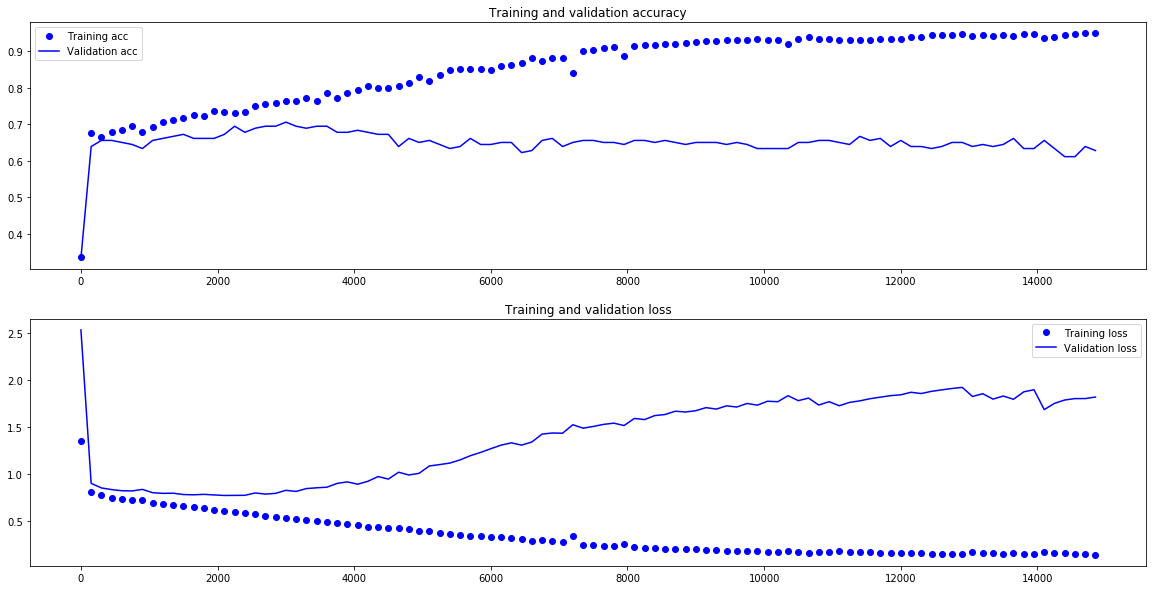

In [88]:
plot_history(history)

## There seems to be a large discrepancy between training and test loss (88% vs 63%) and it seems if we trained for even longer it will still grow

## Our objective is to make the best prediction for unknown samples. This is called generalization. If we perform well on knwon data, but less good on unknown data this is called overfitting. This is to be avoided. Measures taken to avoid overfitting are also known as _regularization_.

### Let's plot the decision boundaries to get a better idea of what is going on
### First for training data

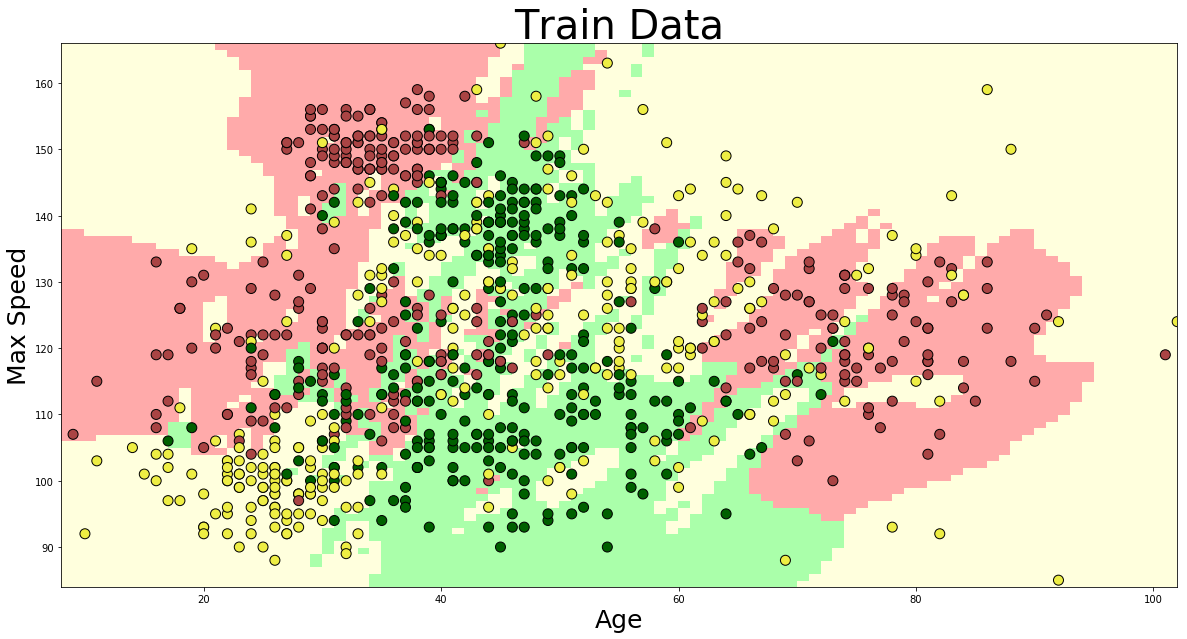

In [85]:
plot_prediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data")

### Then for training data

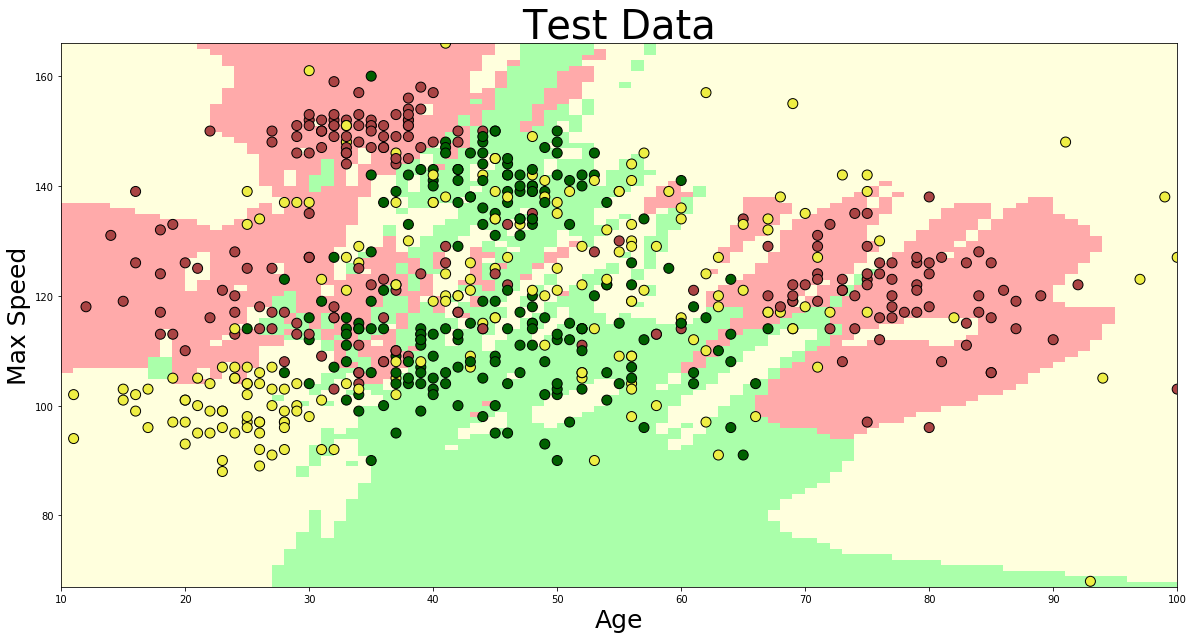

In [86]:
plot_prediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data",
                fname='nn-overfit.png')

### A rule of thumb: Smoother decision boundaries imply less overfitting
This matches our observation: we detect overfitting and the decision boundaries also look rather wild, especially on the upper left side of the plot